# Imports + General

In [ ]:
# Install unrar
!apt-get install -y unrar

In [ ]:
# Define paths
# rar_file_path_test = '/kaggle/input/CASIA-HWDB/test.rar'  # Path to test RAR in /input
# rar_file_path_train = '/kaggle/input/CASIA-HWDB/train.rar'  # Path to train RAR in /input
# rar_file_path_model_stuff = '/kaggle/input/CASIA-HWDB/model_CASIA_HWDB_stuff.rar'  # Path to model stuff RAR in /input
# extraction_path_test = '/kaggle/working/test'  # Writable path test in /working
# extraction_path_train = '/kaggle/working/train'  # Writable path train in /working
# extraction_path_model_stuff = '/kaggle/working/model_CASIA_HWDB_stuff'  # Writable path model stuff in /working

# Unpack RAR files
# !unrar x {rar_file_path_test} {extraction_path_test}
# !unrar x {rar_file_path_train} {extraction_path_train}
# !unrar x {rar_file_path_model_stuff} {extraction_path_model_stuff}

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import torch

import torch.nn as nn

import torch.nn.functional as F

import pickle



import numpy as np

import pandas as pd

import random

import os



from tqdm import tqdm



import torchvision

import torchvision.models as models

from torchvision import transforms, datasets

import torch.utils.data as data

import torchvision.datasets

from torch.utils.data.sampler import WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_fscore_support

from torchvision.models.resnet import conv3x3, _resnet, ResNet18_Weights

import matplotlib.pyplot as plt

from PIL import ImageOps, Image



random.seed(0)

np.random.seed(0)

torch.manual_seed(0)

torch.cuda.manual_seed(0)

torch.backends.cudnn.deterministic = True

# device = 'cpu' 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



# Paths to data

kkanji_150_path = "/kaggle/input/kkanji/kkanji2_150/kkanji2_150"

kkanji_200_path = "/kaggle/input/kkanji/kkanji2_200/kkanji2_200"

kkanji_300_path = "/kaggle/input/kkanji/kkanji2_300/kkanji2_300"

In [29]:
file_path = "/kaggle/working/train_test_indices_150.pkl"

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Deleted: {file_path}")
else:
    print(f"File not found: {file_path}")

Deleted: /kaggle/working/train_test_indices_150.pkl


In [4]:
print(os.cpu_count()) 

4


In [4]:
test_last_epoch = np.load("/kaggle/input/casia-hwdb/model_CASIA_HWDB_stuff/model_CASIA_HWDB_stuff/last_epoch.npy")
print(test_last_epoch)

11

In [ ]:
# Define the path for the new directory
directory_path = '/kaggle/working/model_CASIA_HWDB_stuff'

# Create the directory
os.makedirs(directory_path, exist_ok=True)
print(f"Directory created at: {directory_path}")

In [5]:
dir_pathes = ['/kaggle/working/model_150_stuff', '/kaggle/working/model_200_stuff', '/kaggle/working/model_300_stuff'
              ,'/kaggle/working/model_augmented_150_stuff', '/kaggle/working/model_augmented_200_stuff', '/kaggle/working/model_augmented_300_stuff'
              , '/kaggle/working/model_pretrained_unfreeze_all_150_stuff', '/kaggle/working/model_pretrained_unfreeze_all_200_stuff', '/kaggle/working/model_pretrained_unfreeze_all_300_stuff'
              , '/kaggle/working/model_pretrained_unfreeze_last_150_stuff', '/kaggle/working/model_pretrained_unfreeze_last_200_stuff', '/kaggle/working/model_pretrained_unfreeze_last_300_stuff']

for dir_path in dir_pathes:
    # Create the directory
    os.makedirs(dir_path, exist_ok=True)
    print(f"Directory created at: {dir_path}")

Directory created at: /kaggle/working/model_150_stuff
Directory created at: /kaggle/working/model_200_stuff
Directory created at: /kaggle/working/model_300_stuff
Directory created at: /kaggle/working/model_augmented_150_stuff
Directory created at: /kaggle/working/model_augmented_200_stuff
Directory created at: /kaggle/working/model_augmented_300_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_all_150_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_all_200_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_all_300_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_last_150_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_last_200_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_last_300_stuff


# PreactBasicBlock

In [4]:
class PreactBasicBlock(nn.Module):

    expansion = 1



    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,

                 base_width=64, dilation=1, norm_layer=None):

        super(PreactBasicBlock, self).__init__()



        if norm_layer is None:

            norm_layer = nn.BatchNorm2d



        if groups != 1 or base_width != 64:

            raise ValueError('BasicBlock only supports groups=1 and base_width=64')



        if dilation > 1:

            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")



        # Both self.conv1 and self.downsample layers downsample the input when stride != 1



        self.bn1 = nn.BatchNorm2d(inplanes)

        self.relu1 = nn.ReLU(inplace=True)

        self.conv1 = conv3x3(inplanes, planes, stride)



        self.bn2 = nn.BatchNorm2d(planes)

        self.relu2 = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(planes, planes)

        

        self.downsample = downsample

        self.stride = stride



    def forward(self, x):

        identity = x



        out = self.bn1(x)

        out = self.relu1(out)

        out = self.conv1(out)



        out = self.bn2(out)

        out = self.relu2(out)

        out = self.conv2(out)



        if self.downsample is not None:

            identity = self.downsample(x)



        out += identity



        return out

    

    # Check what is model params and conv3x3. Also normlayer is not used.

# Cycle func

In [7]:
def are_weigths_unequal(old_weigths, new_weigths):

    return bool(len([1 for w1, w2 in zip(old_weigths, new_weigths) if not torch.all(w1.eq(w2))]))



def cycle(model, loader, criterion, train=False, optimizer=None, freeze_base=False):

    overall_loss = []

    overall_accuracy = []

    dataloader_iterator = iter(loader)



    if train:

        model.train()

    else:

        model.eval()

    if freeze_base:

        for param in model.parameters():

            param.requires_grad = False



        for param in model.fc.parameters():

            param.requires_grad = True



    model_weigths = list(model.state_dict().values())



    for batch_id in tqdm(range(len(loader))):   

        try:

            X_batch, y_batch = next(dataloader_iterator)

        except:

            dataloader_iterator = iter(loader)

            X_batch, y_batch = next(dataloader_iterator)



        # if batch_id == 2:

        #     if train:

        #         assert are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Model is not training"

                

        #     else:

        #         assert not are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Weigths are chaning while validating"



        #     del model_weigths

    

        X_batch = X_batch.to(device)

        y_batch = y_batch.to(device)



        if train:

            optimizer.zero_grad()

            preds = model(X_batch)



            # print("Preds require grad: ", preds.requires_grad)



            loss_value = criterion(preds, y_batch)



            # print("Loss value require grad: ", loss_value.requires_grad)

            if batch_id % 100 == 0:
                print("Batch is processing:", batch_id)
            loss_value.backward()



            # Check weights

            # new_model_weights = list(model.state_dict().values())

            # print("Model weights require grad (before step): ", new_model_weights[0].requires_grad)



            # for param in model.parameters():

            #     print(param.grad.data.sum())

    

            optimizer.step()



            # for param in model.parameters():

            #     print(param.grad.data.sum())



            # Check weights again after optimizer step

            # new_model_weights = list(model.state_dict().values())

            # print("Model weights require grad (after step): ", new_model_weights[0].requires_grad)



        else:

            with torch.no_grad():

                preds = model(X_batch)

                loss_value = criterion(preds, y_batch).mean()



        overall_loss.append(loss_value.mean())



        accuracy = (preds.argmax(dim=1) == y_batch).float().mean().data.cpu()

        overall_accuracy.append(accuracy)



    mean_loss = sum(overall_loss) / len(loader)

    mean_accuracy = sum(overall_accuracy) / len(loader)

    

    return mean_loss.item(), mean_accuracy.item()

In [ ]:
w1 = [torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6])]

w2 = [torch.tensor([1, 2, 3]), torch.tensor([4, 6, 6])]

assert are_weigths_unequal(w1, w2), "Weigths are equal"

# Dataloaders

In [8]:
# Dataset initialization



def get_dataloaders(batch_size: int = 16, classamount: int = 150, train_test_indices_path: str = None):



    # Define transformations

    my_transform = transforms.Compose([

                transforms.Grayscale(num_output_channels=3),

                transforms.Resize(64),

                transforms.ToTensor(),

                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)  # Normalize to (-1, 1)

            ])



    if classamount == 150:

        # Load dataset 150

        full_dataset = datasets.ImageFolder(root=kkanji_150_path, transform=my_transform)



    elif classamount == 200:

        # Load dataset 200

        full_dataset = datasets.ImageFolder(root=kkanji_200_path, transform=my_transform)



    elif classamount == 300:

        # Load dataset 300

        full_dataset = datasets.ImageFolder(root=kkanji_300_path, transform=my_transform)


    train_indices = []
    test_indices = []
    # Split dataset into training and testing sets

    if train_test_indices_path is not None and os.path.exists(train_test_indices_path):
        with open(train_test_indices_path, "rb") as f:
            indices = pickle.load(f)
            train_indices = indices["train_indices"]
            test_indices = indices["test_indices"]
                
    else:
    
        train_indices, test_indices = train_test_split(
        
            list(range(len(full_dataset))),
        
            test_size=0.3,
        
            stratify=[label for _, label in full_dataset.samples]
        
        )
        
        # Save indices
        with open(train_test_indices_path, "wb") as f:
            pickle.dump({"train_indices": train_indices, "test_indices": test_indices}, f)

    
    train_dataset = data.Subset(full_dataset, train_indices)

    test_dataset = data.Subset(full_dataset, test_indices)



    # Calculate class weights for the training set

    class_counts = [0] * len(full_dataset.classes)

    for idx in train_indices:

        _, label = full_dataset.samples[idx]

        class_counts[label] += 1



    class_weights = [1.0 / count for count in class_counts]

    sample_weights = [class_weights[full_dataset.samples[idx][1]] for idx in train_indices]



    # Create a WeightedRandomSampler for the training set

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)



    # Create DataLoaders

    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)

    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



    return trainloader, testloader, full_dataset

# Dataloaders CASIA-HWDB

In [5]:
# Dataset CASIA-HWDB initialization



def invert_image(image):

    if isinstance(image, Image.Image):

        return ImageOps.invert(image)

    else:

        raise TypeError("Input should be a PIL Image")



def get_dataloaders_CASIA_HWDB(batch_size: int = 4096):



    # Define transformations

    my_transform = transforms.Compose([

                transforms.Resize(64),  # Resize the smaller edge to 64 while preserving aspect ratio

                transforms.CenterCrop((64, 64)),  # Center crop to 64x64

                transforms.Lambda(invert_image), # invert colors

                transforms.Grayscale(num_output_channels=3),

                transforms.ToTensor(),

                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)  # Normalize to (-1, 1)

            ])



    # Load dataset

    train_dataset = datasets.ImageFolder(root="/kaggle/input/casia-hwdb/train/train", transform=my_transform)

    test_dataset = datasets.ImageFolder(root="/kaggle/input/casia-hwdb/test/test", transform=my_transform)



    # Calculate class weights for the training set

    class_counts = [0] * len(train_dataset.classes)

    for _, label in train_dataset.samples:

        class_counts[label] += 1



    class_weights = [1.0 / count for count in class_counts]

    sample_weights = [class_weights[label] for _, label in train_dataset.samples]



    # Create a WeightedRandomSampler for the training set

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)



    # Create DataLoaders

    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)

    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)



    return trainloader, testloader, train_dataset

# Dataloaders augmented

In [9]:
def get_dataloaders_augmented(batch_size: int = 16, classamount: int = 150, train_test_indices_path: str = None):
    # Define transformations for training and testing
    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomResizedCrop(64, scale=(0.95, 1.05)),
        transforms.RandomAffine(degrees=0, shear=0.05),
        transforms.Resize(64),  # Ensure the image is 64x64
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)
    ])

    test_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)
    ])

    if classamount == 150:
        # Load dataset 150
        full_dataset = datasets.ImageFolder(root=kkanji_150_path, transform=None)
    elif classamount == 200:
        # Load dataset 200
        full_dataset = datasets.ImageFolder(root=kkanji_200_path, transform=None)
    elif classamount == 300:
        # Load dataset 300
        full_dataset = datasets.ImageFolder(root=kkanji_300_path, transform=None)

    train_indices = []
    test_indices = []
    # Split dataset into training and testing sets

    if train_test_indices_path is not None and os.path.exists(train_test_indices_path):
        with open(train_test_indices_path, "rb") as f:
            indices = pickle.load(f)
            train_indices = indices["train_indices"]
            test_indices = indices["test_indices"]
    else:
        train_indices, test_indices = train_test_split(
            list(range(len(full_dataset))),
            test_size=0.3,
            stratify=[label for _, label in full_dataset.samples]
        )

        # Save indices
        with open(train_test_indices_path, "wb") as f:
            pickle.dump({"train_indices": train_indices, "test_indices": test_indices}, f)

    train_dataset = data.Subset(full_dataset, train_indices)
    test_dataset = data.Subset(full_dataset, test_indices)

    # Apply transformations
    train_dataset.dataset.transform = train_transform
    test_dataset.dataset.transform = test_transform

    # Calculate class weights for the training set
    class_counts = [0] * len(full_dataset.classes)
    for idx in train_indices:
        _, label = full_dataset.samples[idx]
        class_counts[label] += 1

    class_weights = [1.0 / count for count in class_counts]
    sample_weights = [class_weights[full_dataset.samples[idx][1]] for idx in train_indices]

    # Create a WeightedRandomSampler for the training set
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create DataLoaders
    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return trainloader, testloader, full_dataset

# Testing models

In [7]:
# Testing loop

def testing_model(class_amount: int = 150, model_suff_path: str = None, train_test_indices_path: str = None):



    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, False) # 'resnet18'

    model.fc = nn.Linear(model.fc.in_features, class_amount)



    if model_suff_path is not None:

        if os.path.exists(f"{model_suff_path}/model.pth"):

            model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))



    else:

        if os.path.exists(f"model_{class_amount}_stuff/model.pth"):

            model.load_state_dict(torch.load(f"model_{class_amount}_stuff/model.pth"))



    criterion = nn.CrossEntropyLoss()


    # For CASIA-HWDB
    # trainloader, testloader, original_dataset = get_dataloaders_CASIA_HWDB(batch_size=4096)

    # For kkanji
    trainloader, testloader, original_dataset = get_dataloaders(batch_size=4096, classamount=class_amount, train_test_indices_path=train_test_indices_path)

    model = model.to(device)
    
    test_loss, test_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion)



    print('Test: loss', test_loss, 'accuracy', test_accuracy)



    #Accuracy for each class

    class_correct = list(0. for i in range(class_amount))



    class_total = list(0. for i in range(class_amount))



    model.eval()



    with torch.no_grad():

        for data in testloader:

            images, labels = data

            images = images.to(device)

            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            c = (predicted == labels).squeeze()

            for i in range(len(labels)):

                label = labels[i]

                class_correct[label] += c[i].item()

                class_total[label] += 1



    # Print accuracy for each class using class names

    class_correct_dict = {}

    class_total_dict = {}



    for i in range(class_amount):

        class_correct_dict[original_dataset.classes[i]] = class_correct[i] / class_total[i]

        class_total_dict[original_dataset.classes[i]] = class_total[i]



    class_correct_dict = dict(sorted(class_correct_dict.items(), key=lambda item: item[1], reverse=True))



    for key, value in class_correct_dict.items():

        print(key, value, class_total_dict[key])



# Getting stuff for training

In [11]:
def getting_stuff_for_training(classamount: int = 150, pathes: dict = None, lr: float = 1e-3, scheduler_step_size: int = 10, scheduler_gamma: float = 0.1, pretrained = False):    

    stuff = {}

    last_epoch = 0

    if os.path.exists(pathes["last_epoch"]):

        last_epoch = np.load(pathes["last_epoch"])

    stuff["last_epoch"] = last_epoch



    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, progress=False) # 'resnet18'

    if pretrained:
        
        model.fc = nn.Linear(model.fc.in_features, 6764)

        if os.path.exists(pathes["model"]):

            model.load_state_dict(torch.load(pathes["model"]))



    if classamount == 150:

        model.fc = nn.Linear(model.fc.in_features, 150)



    elif classamount == 200:

        model.fc = nn.Linear(model.fc.in_features, 200)



    elif classamount == 300:

        model.fc = nn.Linear(model.fc.in_features, 300)



    elif classamount == 6764:

        model.fc = nn.Linear(model.fc.in_features, 6764)

    if not pretrained:

        if os.path.exists(pathes["model"]):

            model.load_state_dict(torch.load(pathes["model"]))



    # if weights is not None:

    #     for param in model.parameters():

    #         param.requires_grad = False



    #     for param in model.fc.parameters():

    #         param.requires_grad = True

    model = model.to(device)
    
    stuff["model"] = model

    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # , weight_decay=0.)

    if os.path.exists(pathes["optimizer"]):

        optimizer.load_state_dict(torch.load(pathes["optimizer"]))

    stuff["optimizer"] = optimizer



    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    if os.path.exists(pathes["scheduler"]):

        scheduler.load_state_dict(torch.load(pathes["scheduler"]))

    stuff["scheduler"] = scheduler



    train_loss_history = []

    if os.path.exists(pathes["train_loss_history"]):

        train_loss_history = list(np.load(pathes["train_loss_history"]))

    stuff["train_loss_history"] = train_loss_history



    train_accuracy_history = []

    if os.path.exists(pathes["train_accuracy_history"]):

        train_accuracy_history = list(np.load(pathes["train_accuracy_history"]))

    stuff["train_accuracy_history"] = train_accuracy_history



    val_loss_history = []

    if os.path.exists(pathes["val_loss_history"]):

        val_loss_history = list(np.load(pathes["val_loss_history"]))

    stuff["val_loss_history"] = val_loss_history



    val_accuracy_history = []

    if os.path.exists(pathes["val_accuracy_history"]):

        val_accuracy_history = list(np.load(pathes["val_accuracy_history"]))

    stuff["val_accuracy_history"] = val_accuracy_history



    max_val_accuracy = 0

    if os.path.exists(pathes["max_val_accuracy"]):

        max_val_accuracy = np.load(pathes["max_val_accuracy"])

    stuff["max_val_accuracy"] = max_val_accuracy



    early_stopping = 5

    if os.path.exists(pathes["early_stopping"]):

        early_stopping = np.load(pathes["early_stopping"])

    stuff["early_stopping"] = early_stopping

    

    return stuff

# Plot func

In [12]:
def custom_plot(train_data : list = None, val_data : list = None, title: str = None,  ylabel: str = None):

    plt.plot(train_data, label="train")

    plt.plot(val_data, label="validation")

    plt.xlabel('Epochs')

    plt.ylabel(ylabel)

    plt.legend()

    plt.title(title)

    return

# Create pathes vocabulary

In [13]:
def create_pathes_vocabulary(path : str = None):
    pathes = {"last_epoch": f"{path}/last_epoch.npy", "model": f"{path}/model.pth", "optimizer": f"{path}/optimizer.pth", 
    "scheduler": f"{path}/scheduler.pth", "train_loss_history": f"{path}/train_loss_history.npy", "train_accuracy_history": f"{path}/train_accuracy_history.npy", 
    "val_loss_history": f"{path}/val_loss_history.npy", "val_accuracy_history": f"{path}/val_accuracy_history.npy", 
    "max_val_accuracy": f"{path}/max_val_accuracy.npy", "early_stopping": f"{path}/early_stopping.npy"}

    return pathes
    

# Train loop

In [14]:
def train_loop(trainloader, testloader, stuff : dict = None, criterion=nn.CrossEntropyLoss(), save_path : str = None, epochs : int = 100, model_name : str = None, freeze_base : bool = False):

    last_epoch = stuff["last_epoch"]

    epochs += last_epoch 



    model = stuff["model"]

    optimizer = stuff["optimizer"]

    scheduler = stuff["scheduler"]



    train_loss_history = stuff["train_loss_history"]

    train_accuracy_history = stuff["train_accuracy_history"]



    val_loss_history = stuff["val_loss_history"]

    val_accuracy_history = stuff["val_accuracy_history"]



    max_val_accuracy = stuff["max_val_accuracy"]

    early_stopping = stuff["early_stopping"]

    for epoch in tqdm(range(last_epoch, epochs)):

        train_loss, train_accuracy = cycle(model, trainloader, criterion, train=True, optimizer=optimizer, freeze_base=freeze_base) #train(model, trainloader, criterion, optimizer, batch_size)

        train_loss_history.append(train_loss)

        train_accuracy_history.append(train_accuracy)



        val_loss, val_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion, batch_size)

        val_loss_history.append(val_loss)

        val_accuracy_history.append(val_accuracy)



        scheduler.step()



        print('Epoch:', epoch+1)

        print('Train: loss', train_loss, 'accuracy', train_accuracy)

        print('Validation: loss', val_loss, 'accuracy', val_accuracy)



        if val_accuracy > max_val_accuracy:

            max_val_accuracy = val_accuracy

            early_stopping = 5



            # Save the model

            torch.save(model.state_dict(), f'{save_path}/model.pth')



            # Save the optimizer

            torch.save(optimizer.state_dict(), f'{save_path}/optimizer.pth')



            # Save the scheduler

            torch.save(scheduler.state_dict(), f'{save_path}/scheduler.pth')



            # Save the loss history

            np.save(f'{save_path}/train_loss_history.npy', train_loss_history)

            np.save(f'{save_path}/val_loss_history.npy', val_loss_history)



            # Save the accuracy history

            np.save(f'{save_path}/train_accuracy_history.npy', train_accuracy_history)

            np.save(f'{save_path}/val_accuracy_history.npy', val_accuracy_history)



            # Save the last epoch

            np.save(f'{save_path}/last_epoch.npy', epoch+1)



            # Save max validation accuracy

            np.save(f'{save_path}/max_val_accuracy.npy', max_val_accuracy)



            # Save early stopping

            np.save(f'{save_path}/early_stopping.npy', early_stopping)



        else:

            early_stopping -= 1



        if early_stopping == 0:

            break

    

    print(f'Best validation accuracy for {model_name}:', max(val_accuracy_history), 'Epoch', val_accuracy_history.index(max(val_accuracy_history))+1)

    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

# Testing models with metrics

In [6]:
def testing_models_metrics(class_amount: int = 300, model_suff_path: str = None, train_test_indices_path: str = None, casia_hwdb: dict = None):

    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, False)  # 'resnet18'
    model.fc = nn.Linear(model.fc.in_features, class_amount)

    # Load model weights
    if model_suff_path is not None:
        if os.path.exists(f"{model_suff_path}/model.pth"):
            model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
    else:
        if os.path.exists(f"model_{class_amount}_stuff/model.pth"):
            model.load_state_dict(torch.load(f"model_{class_amount}_stuff/model.pth"))

    criterion = nn.CrossEntropyLoss()

    # Load 
    if casia_hwdb is None:
        trainloader, testloader, original_dataset = get_dataloaders(batch_size=4096, classamount=class_amount, train_test_indices_path=train_test_indices_path)
    else:
        testloader = casia_hwdb["testloader"]
        original_dataset = casia_hwdb["original_dataset"]
    
    model = model.to(device)

    # Test loss and accuracy
    if casia_hwdb is None:
        test_loss, test_accuracy = cycle(model, testloader, criterion)
        print('Test: loss', test_loss, 'accuracy', test_accuracy)

    # Accuracy for each class
    class_correct = [0. for _ in range(class_amount)]
    class_total = [0. for _ in range(class_amount)]
    all_labels = []
    all_predictions = []
    all_probs = []

    scaler = torch.cuda.amp.GradScaler()
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        for data in tqdm(testloader, desc="Evaluating"):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Save predictions and labels for mAP and mAR calculations
            all_probs.append(outputs.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Calculate per-class accuracy
    class_accuracy = {original_dataset.classes[i]: class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                      for i in range(class_amount)}

    print("Per-class accuracy:")
    for key, value in sorted(class_accuracy.items(), key=lambda item: item[1], reverse=True):
        print(f"{key}: {value:.5f} ")

    # Convert collected data to numpy arrays
    all_probs = np.vstack(all_probs)  # Predicted probabilities for each class
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Compute mAP
    ap_per_class = []
    for i in range(class_amount):
        true_labels = (all_labels == i).astype(int)
        
        # Skip invalid or empty classes
        if np.sum(true_labels) > 0 and not np.isnan(true_labels).any():
            # Ensure probabilities are valid
            class_probs = np.nan_to_num(all_probs[:, i], nan=0.0)
            ap = average_precision_score(true_labels, class_probs)
            ap_per_class.append(ap)
        else:
            ap_per_class.append(0)  # No instances or invalid data for this class
    
    mAP = np.mean(ap_per_class)
    print(f"Mean Average Precision (mAP): {mAP:.5f}")


    # Compute mAR
    precision, recall, _, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None, zero_division=0)
    mAR = np.mean(recall)
    mAP_without_probs = np.mean(precision)
    print(f"Mean Average Precision (mAP withput probs): {mAP:.5f}")
    print(f"Mean Average Recall (mAR): {mAR:.5f}")

    # Compute Mean Average Accuracy (MAA)
    maa = np.mean(list(class_accuracy.values()))
    print(f"Mean Average Accuracy (MAA): {maa:.5f}")

    


# 150 classes logic

In [16]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_150_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size=4096, classamount=150, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

stuff = getting_stuff_for_training(classamount=150, pathes=pathes)

In [17]:
# Train loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_150_stuff", model_name="150 classes")

  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:49<00:00,  3.81s/it]

100%|██████████| 6/6 [00:40<00:00,  6.74s/it]


Epoch: 1
Train: loss 2.63325572013855 accuracy 0.48919472098350525
Validation: loss 8.965192794799805 accuracy 0.06017694249749184


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:37<00:00,  2.89s/it]

100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


Epoch: 2
Train: loss 0.5067117214202881 accuracy 0.8797423839569092
Validation: loss 2.698166847229004 accuracy 0.41273602843284607


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:32<00:00,  2.49s/it]

100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Epoch: 3
Train: loss 0.20761042833328247 accuracy 0.9495687484741211
Validation: loss 0.30100947618484497 accuracy 0.9248886108398438


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.37s/it]

100%|██████████| 6/6 [00:15<00:00,  2.57s/it]


Epoch: 4
Train: loss 0.10736755281686783 accuracy 0.9763303399085999
Validation: loss 0.23777660727500916 accuracy 0.9418333172798157


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.32s/it]

100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Epoch: 5
Train: loss 0.06319741904735565 accuracy 0.9866469502449036
Validation: loss 0.21896398067474365 accuracy 0.946681559085846


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.25s/it]

100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Epoch: 6
Train: loss 0.04066978022456169 accuracy 0.9926506280899048
Validation: loss 0.20128284394741058 accuracy 0.9484944343566895


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.23s/it]

100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


Epoch: 7
Train: loss 0.027124980464577675 accuracy 0.995523989200592
Validation: loss 0.1880597174167633 accuracy 0.9534872174263


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:31<00:00,  2.40s/it]

  8%|▊         | 8/100 [07:06<1:13:55, 48.21s/it]

Epoch: 8
Train: loss 0.016447629779577255 accuracy 0.9972829222679138
Validation: loss 0.19527527689933777 accuracy 0.9531903266906738



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


Epoch: 9
Train: loss 0.01727266050875187 accuracy 0.9968824982643127
Validation: loss 0.17665955424308777 accuracy 0.9594852328300476


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


Epoch: 10
Train: loss 0.011386055499315262 accuracy 0.9982534646987915
Validation: loss 0.15846523642539978 accuracy 0.9635767936706543


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

100%|██████████| 6/6 [00:17<00:00,  2.88s/it]


Epoch: 11
Train: loss 0.007219456601887941 accuracy 0.9988104701042175
Validation: loss 0.1523851752281189 accuracy 0.9654304385185242


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

100%|██████████| 6/6 [00:16<00:00,  2.83s/it]


Epoch: 12
Train: loss 0.0049342080019414425 accuracy 0.999436616897583
Validation: loss 0.15097030997276306 accuracy 0.9660754203796387


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


Epoch: 13
Train: loss 0.004898890852928162 accuracy 0.9993614554405212
Validation: loss 0.15074628591537476 accuracy 0.9662849307060242


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

 14%|█▍        | 14/100 [11:42<1:05:51, 45.95s/it]

Epoch: 14
Train: loss 0.0037454187404364347 accuracy 0.9996243715286255
Validation: loss 0.14938700199127197 accuracy 0.9662442207336426



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

100%|██████████| 6/6 [00:16<00:00,  2.81s/it]


Epoch: 15
Train: loss 0.004037078935652971 accuracy 0.9994741678237915
Validation: loss 0.1485585868358612 accuracy 0.966447651386261


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Epoch: 16
Train: loss 0.003388147335499525 accuracy 0.999436616897583
Validation: loss 0.14780175685882568 accuracy 0.9674589037895203


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


Epoch: 17
Train: loss 0.0033192492555826902 accuracy 0.9996055960655212
Validation: loss 0.1472894549369812 accuracy 0.9676969051361084


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Epoch: 18
Train: loss 0.00389129389077425 accuracy 0.999336302280426
Validation: loss 0.14701297879219055 accuracy 0.9678129553794861


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.19s/it]

100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Epoch: 19
Train: loss 0.0044151353649795055 accuracy 0.9992048740386963
Validation: loss 0.14704936742782593 accuracy 0.9680977463722229


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.20s/it]

 20%|██        | 20/100 [16:13<1:00:14, 45.18s/it]

Epoch: 20
Train: loss 0.004005665425211191 accuracy 0.9992424249649048
Validation: loss 0.14690940082073212 accuracy 0.9680631160736084



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

 21%|██        | 21/100 [16:58<59:20, 45.07s/it]  

Epoch: 21
Train: loss 0.0028554657474160194 accuracy 0.9996619820594788
Validation: loss 0.14742527902126312 accuracy 0.9679064750671387



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


Epoch: 22
Train: loss 0.002710070228204131 accuracy 0.999680757522583
Validation: loss 0.14721044898033142 accuracy 0.96822589635849


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.23s/it]

 23%|██▎       | 23/100 [18:29<57:52, 45.10s/it]

Epoch: 23
Train: loss 0.0026069951709359884 accuracy 0.9997370839118958
Validation: loss 0.14695701003074646 accuracy 0.9681444764137268



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 24%|██▍       | 24/100 [19:14<57:13, 45.18s/it]

Epoch: 24
Train: loss 0.0026413409505039454 accuracy 0.9996243715286255
Validation: loss 0.14706838130950928 accuracy 0.96798175573349



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


Epoch: 25
Train: loss 0.0023309688549488783 accuracy 0.9997934103012085
Validation: loss 0.14701524376869202 accuracy 0.9683072566986084


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 26%|██▌       | 26/100 [20:43<55:24, 44.93s/it]

Epoch: 26
Train: loss 0.003432038938626647 accuracy 0.9994677901268005
Validation: loss 0.14706623554229736 accuracy 0.9681791663169861



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Epoch: 27
Train: loss 0.0030224707443267107 accuracy 0.9995304942131042
Validation: loss 0.146939218044281 accuracy 0.9683418869972229


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


Epoch: 28
Train: loss 0.0026882365345954895 accuracy 0.9996619820594788
Validation: loss 0.14700619876384735 accuracy 0.9683825969696045


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.19s/it]

 29%|██▉       | 29/100 [22:56<52:41, 44.53s/it]

Epoch: 29
Train: loss 0.003545210463926196 accuracy 0.9993926286697388
Validation: loss 0.14648957550525665 accuracy 0.9683825969696045



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


Epoch: 30
Train: loss 0.0030880426056683064 accuracy 0.9992987513542175
Validation: loss 0.1464250534772873 accuracy 0.9685046672821045


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 31%|███       | 31/100 [24:26<51:16, 44.58s/it]

Epoch: 31
Train: loss 0.0028310948982834816 accuracy 0.9996243715286255
Validation: loss 0.1467486321926117 accuracy 0.9683825969696045



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


Epoch: 32
Train: loss 0.0024298091884702444 accuracy 0.999755859375
Validation: loss 0.14666709303855896 accuracy 0.9685453772544861


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

 33%|███▎      | 33/100 [25:55<49:54, 44.69s/it]

Epoch: 33
Train: loss 0.0030997470021247864 accuracy 0.9996432065963745
Validation: loss 0.14689196646213531 accuracy 0.9683418869972229



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.25s/it]

100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


Epoch: 34
Train: loss 0.0023019686341285706 accuracy 0.9997934103012085
Validation: loss 0.1465066820383072 accuracy 0.9687020778656006


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

 35%|███▌      | 35/100 [27:26<48:43, 44.97s/it]

Epoch: 35
Train: loss 0.0025225202552974224 accuracy 0.9996619820594788
Validation: loss 0.14661158621311188 accuracy 0.9683418869972229



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.20s/it]

 36%|███▌      | 36/100 [28:11<47:50, 44.85s/it]

Epoch: 36
Train: loss 0.0029444750398397446 accuracy 0.9995680451393127
Validation: loss 0.14653979241847992 accuracy 0.9682605266571045



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.38s/it]

 37%|███▋      | 37/100 [28:57<47:36, 45.33s/it]

Epoch: 37
Train: loss 0.0027811971958726645 accuracy 0.9995680451393127
Validation: loss 0.14639955759048462 accuracy 0.968539297580719



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 38%|███▊      | 38/100 [29:42<46:37, 45.11s/it]

Epoch: 38
Train: loss 0.002402952639386058 accuracy 0.9997370839118958
Validation: loss 0.14664918184280396 accuracy 0.9687020778656006



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.20s/it]

 38%|███▊      | 38/100 [30:26<49:40, 48.07s/it]

Epoch: 39
Train: loss 0.002642907202243805 accuracy 0.9996432065963745
Validation: loss 0.146537184715271 accuracy 0.9684233069419861
Best validation accuracy for 150 classes: 0.9687020778656006 Epoch 34


In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

In [ ]:
testing_models_metrics(class_amount=150, model_suff_path="/kaggle/working/model_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

# 200 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_200_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size=4096, classamount=200, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

stuff = getting_stuff_for_training(classamount=200, pathes=pathes)

In [ ]:
# Train loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_200_stuff", model_name="200 classes")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_200_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

In [ ]:
testing_models_metrics(class_amount=200, model_suff_path="/kaggle/working/model_200_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

# 300 classes logic

In [33]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_300_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size=4096, classamount=300, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

stuff = getting_stuff_for_training(classamount=300, pathes=pathes)

In [ ]:
# Train loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_300_stuff", model_name="300 classes")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

In [ ]:
testing_models_metrics(class_amount=300, model_suff_path="/kaggle/working/model_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

# Augmented, 150 classes logic

In [23]:
# Getting stuff for training 

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_augmented_150_stuff")

trainloader, testloader, _ = get_dataloaders_augmented(batch_size=4096, classamount=150, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

stuff = getting_stuff_for_training(classamount=150, pathes=pathes)

In [24]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_augmented_150_stuff", model_name="150 classes augmented")

  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:37<00:00,  2.88s/it]

100%|██████████| 6/6 [00:25<00:00,  4.19s/it]


Epoch: 1
Train: loss 2.528752088546753 accuracy 0.5010761022567749
Validation: loss 9.641977310180664 accuracy 0.04254324734210968


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.36s/it]

100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


Epoch: 2
Train: loss 0.4718809425830841 accuracy 0.888169527053833
Validation: loss 2.213681221008301 accuracy 0.4913511276245117


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:27<00:00,  2.10s/it]

100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch: 3
Train: loss 0.18878453969955444 accuracy 0.9536000490188599
Validation: loss 0.4891397953033447 accuracy 0.874769389629364


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.98s/it]

100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch: 4
Train: loss 0.0925801545381546 accuracy 0.9797235727310181
Validation: loss 0.22563588619232178 accuracy 0.9443561434745789


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.03s/it]

100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch: 5
Train: loss 0.05243449658155441 accuracy 0.9892138838768005
Validation: loss 0.21392178535461426 accuracy 0.9459266066551208


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.94s/it]

100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch: 6
Train: loss 0.028372788801789284 accuracy 0.9946600794792175
Validation: loss 0.19884811341762543 accuracy 0.950099527835846


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.94s/it]

100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch: 7
Train: loss 0.02077638916671276 accuracy 0.9967135190963745
Validation: loss 0.18626177310943604 accuracy 0.9564681053161621


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.98s/it]

100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch: 8
Train: loss 0.014270489104092121 accuracy 0.9975022673606873
Validation: loss 0.18672136962413788 accuracy 0.957613468170166


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.94s/it]

100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch: 9
Train: loss 0.009045327082276344 accuracy 0.9985163807868958
Validation: loss 0.1780308336019516 accuracy 0.9579043388366699


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.98s/it]

 10%|█         | 10/100 [06:57<58:31, 39.02s/it]

Epoch: 10
Train: loss 0.007241405081003904 accuracy 0.9987417459487915
Validation: loss 0.18730825185775757 accuracy 0.9577129483222961



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.00s/it]

100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Epoch: 11
Train: loss 0.007249298971146345 accuracy 0.9988356232643127
Validation: loss 0.17532329261302948 accuracy 0.9603578448295593


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.95s/it]

100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch: 12
Train: loss 0.004969626199454069 accuracy 0.9993239045143127
Validation: loss 0.1664738804101944 accuracy 0.9610660672187805


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.97s/it]

100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch: 13
Train: loss 0.005975840613245964 accuracy 0.9991109371185303
Validation: loss 0.16272380948066711 accuracy 0.9625248908996582


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.95s/it]

100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch: 14
Train: loss 0.0042708637192845345 accuracy 0.9993239045143127
Validation: loss 0.16213831305503845 accuracy 0.9631759524345398


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:24<00:00,  1.89s/it]

 15%|█▌        | 15/100 [10:09<54:29, 38.46s/it]

Epoch: 15
Train: loss 0.003046901198104024 accuracy 0.999680757522583
Validation: loss 0.16320395469665527 accuracy 0.9629499316215515



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.03s/it]

 16%|█▌        | 16/100 [10:48<53:59, 38.56s/it]

Epoch: 16
Train: loss 0.0030439766123890877 accuracy 0.9996619820594788
Validation: loss 0.16097058355808258 accuracy 0.9628278613090515



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.93s/it]

100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch: 17
Train: loss 0.004200211260467768 accuracy 0.9992424249649048
Validation: loss 0.16028960049152374 accuracy 0.9633100628852844


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:24<00:00,  1.90s/it]

100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch: 18
Train: loss 0.002838687039911747 accuracy 0.9996619820594788
Validation: loss 0.16053713858127594 accuracy 0.9637923240661621


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.99s/it]

100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Epoch: 19
Train: loss 0.003329362254589796 accuracy 0.9996055960655212
Validation: loss 0.1594126969575882 accuracy 0.9639957547187805


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.95s/it]

100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch: 20
Train: loss 0.0022938044276088476 accuracy 0.9996995329856873
Validation: loss 0.15928982198238373 accuracy 0.9647567868232727


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.93s/it]

 21%|██        | 21/100 [13:58<50:03, 38.03s/it]

Epoch: 21
Train: loss 0.0029516553040593863 accuracy 0.9995304942131042
Validation: loss 0.15939980745315552 accuracy 0.9643966555595398



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

 22%|██▏       | 22/100 [14:37<49:40, 38.21s/it]

Epoch: 22
Train: loss 0.0021887593902647495 accuracy 0.9997370839118958
Validation: loss 0.15958888828754425 accuracy 0.9644780158996582



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:24<00:00,  1.89s/it]

 23%|██▎       | 23/100 [15:15<48:59, 38.17s/it]

Epoch: 23
Train: loss 0.002255138009786606 accuracy 0.999755859375
Validation: loss 0.15910625457763672 accuracy 0.9640771746635437



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.93s/it]

 24%|██▍       | 24/100 [15:52<48:06, 37.98s/it]

Epoch: 24
Train: loss 0.002328132279217243 accuracy 0.999680757522583
Validation: loss 0.15929855406284332 accuracy 0.9643152356147766



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.95s/it]

 24%|██▍       | 24/100 [16:30<52:18, 41.29s/it]

Epoch: 25
Train: loss 0.002234715037047863 accuracy 0.9996995329856873
Validation: loss 0.1595211625099182 accuracy 0.9643152356147766
Best validation accuracy for 150 classes augmented: 0.9647567868232727 Epoch 20


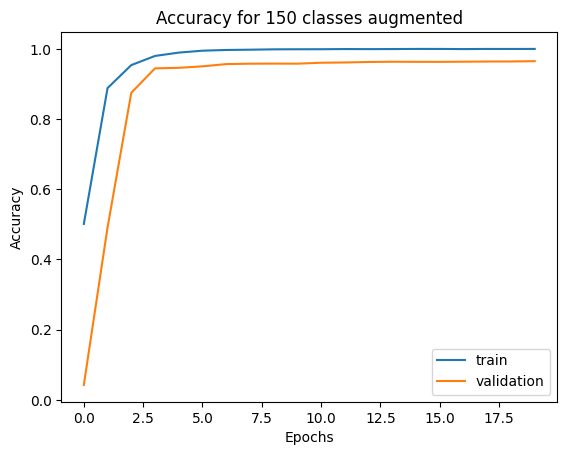

In [28]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes augmented", "Accuracy")

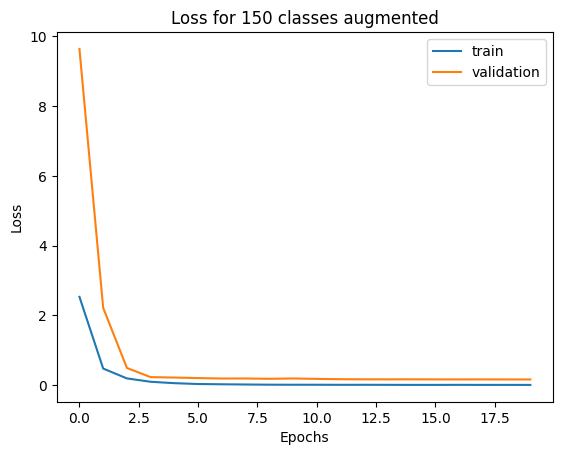

In [29]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes augmented", "Loss")

In [30]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_augmented_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_30/994810850.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.045007213950157166 accuracy 0.9898109436035156


U+4E00 1.0 530.0
U+4E0D 1.0 68.0
U+4EAC 1.0 67.0
U+4F55 1.0 218.0
U+4F5C 1.0 62.0
U+516B 1.0 77.0
U+5185 1.0 106.0
U+51FA 1.0 336.0
U+5207 1.0 94.0
U+5375 1.0 59.0
U+53C8 1.0 435.0
U+53CA 1.0 77.0
U+5473 1.0 98.0
U+56FD 1.0 203.0
U+5869 1.0 67.0
U+5929 1.0 79.0
U+592B 1.0 99.0
U+5C71 1.0 164.0
U+5DE6 1.0 76.0
U+5E74 1.0 100.0
U+5F15 1.0 95.0
U+6216 1.0 60.0
U+6238 1.0 113.0
U+6240 1.0 188.0
U+660E 1.0 60.0
U+6642 1.0 200.0
U+6728 1.0 117.0
U+6851 1.0 88.0
U+6C17 1.0 66.0
U+6C41 1.0 158.0
U+6CBB 1.0 92.0
U+713C 1.0 63.0
U+7528 1.0 79.0
U+7530 1.0 59.0
U+76EE 1.0 99.0
U+795E 1.0 76.0
U+7D19 1.0 79.0
U+805E 1.0 104.0
U+8336 1.0 91.0
U+898B 1.0 320.0
U+90E8 1.0 65.0
U+9152 1.0 130.0
U+9577 1.0 73.0
U+9593 1.0 82.0
U+9B5A 1.0 83.0
U+4E8B 0.99800796812749 502.0
U+7269 0.9972222222222222 360.0
U+5176 0.9966777408637874 301.0
U+5C0F 0.9962825278810409 269.0
U+4E91 0.9962264150943396 530.0
U+4E0A 0.9961538461538462 260.0
U+662F 0.9959349593495935 246.0
U+4E2D 0.9957805907172996 237.0
U+524D 0.9

In [ ]:
testing_models_metrics(class_amount=150, model_suff_path="/kaggle/working/model_augmented_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

# Augmented, 200 classes logic

In [32]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_augmented_200_stuff")

trainloader, testloader, _ = get_dataloaders_augmented(batch_size=4096, classamount=200, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

stuff = getting_stuff_for_training(classamount=200, pathes=pathes)

In [32]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_augmented_200_stuff", model_name="200 classes augmented")

  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:41<00:00,  3.00s/it]

100%|██████████| 6/6 [00:25<00:00,  4.32s/it]


Epoch: 1
Train: loss 2.8031606674194336 accuracy 0.47183316946029663
Validation: loss 9.379919052124023 accuracy 0.05178852006793022


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.44s/it]

100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch: 2
Train: loss 0.4984050393104553 accuracy 0.8861166834831238
Validation: loss 2.457099437713623 accuracy 0.4503810703754425


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.29s/it]

100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch: 3
Train: loss 0.17713502049446106 accuracy 0.9608621001243591
Validation: loss 0.4329680800437927 accuracy 0.8903406262397766


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:30<00:00,  2.14s/it]

100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch: 4
Train: loss 0.07508019357919693 accuracy 0.9847311973571777
Validation: loss 0.24628019332885742 accuracy 0.9402711391448975


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.02s/it]

100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch: 5
Train: loss 0.03742525726556778 accuracy 0.9931148290634155
Validation: loss 0.21462303400039673 accuracy 0.9470379948616028


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.08s/it]

100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch: 6
Train: loss 0.02300521358847618 accuracy 0.9960776567459106
Validation: loss 0.20854249596595764 accuracy 0.9499454498291016


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.09s/it]

100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch: 7
Train: loss 0.01651538722217083 accuracy 0.9970197081565857
Validation: loss 0.19820092618465424 accuracy 0.9516780376434326


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.97s/it]

100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch: 8
Train: loss 0.012120376341044903 accuracy 0.9981005787849426
Validation: loss 0.1939423382282257 accuracy 0.9542179107666016


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.02s/it]

100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch: 9
Train: loss 0.009314711205661297 accuracy 0.9985536336898804
Validation: loss 0.196051225066185 accuracy 0.9549517035484314


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.13s/it]

100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch: 10
Train: loss 0.006608883384615183 accuracy 0.9989539980888367
Validation: loss 0.1897038221359253 accuracy 0.9558875560760498


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.06s/it]

100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch: 11
Train: loss 0.005998820532113314 accuracy 0.9990586638450623
Validation: loss 0.1772761195898056 accuracy 0.9599469304084778


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.99s/it]

100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch: 12
Train: loss 0.0031191965099424124 accuracy 0.9995814561843872
Validation: loss 0.17493866384029388 accuracy 0.9604759216308594


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.07s/it]

100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch: 13
Train: loss 0.002922815503552556 accuracy 0.9996686577796936
Validation: loss 0.17359307408332825 accuracy 0.960882842540741


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.10s/it]

100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch: 14
Train: loss 0.002763670403510332 accuracy 0.9996686577796936
Validation: loss 0.17229412496089935 accuracy 0.9613037705421448


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.96s/it]

 15%|█▌        | 15/100 [11:14<1:00:18, 42.57s/it]

Epoch: 15
Train: loss 0.002858477644622326 accuracy 0.9996337890625
Validation: loss 0.17167189717292786 accuracy 0.9609484672546387



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.04s/it]

100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch: 16
Train: loss 0.002199488691985607 accuracy 0.999755859375
Validation: loss 0.17088983952999115 accuracy 0.9614179730415344


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.07s/it]

100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch: 17
Train: loss 0.0023552868515253067 accuracy 0.9996515512466431
Validation: loss 0.17086532711982727 accuracy 0.9615479111671448


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.14s/it]

100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


Epoch: 18
Train: loss 0.002415058668702841 accuracy 0.9996515512466431
Validation: loss 0.17045125365257263 accuracy 0.962031364440918


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.06s/it]

 19%|█▉        | 19/100 [14:08<58:45, 43.52s/it]

Epoch: 19
Train: loss 0.0020366250537335873 accuracy 0.9997562170028687
Validation: loss 0.17002719640731812 accuracy 0.9617356657981873



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.10s/it]

 20%|██        | 20/100 [14:52<57:51, 43.40s/it]

Epoch: 20
Train: loss 0.002293712692335248 accuracy 0.9996344447135925
Validation: loss 0.16970697045326233 accuracy 0.9617981910705566



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:30<00:00,  2.17s/it]

 21%|██        | 21/100 [15:36<57:26, 43.62s/it]

Epoch: 21
Train: loss 0.001694591366685927 accuracy 0.9998255968093872
Validation: loss 0.16998790204524994 accuracy 0.9619719386100769



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.04s/it]

100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


Epoch: 22
Train: loss 0.001818315708078444 accuracy 0.9997907280921936
Validation: loss 0.169963538646698 accuracy 0.962226927280426


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.02s/it]

 23%|██▎       | 23/100 [17:02<55:24, 43.17s/it]

Epoch: 23
Train: loss 0.00191180978436023 accuracy 0.9996861219406128
Validation: loss 0.1700635403394699 accuracy 0.9620234966278076



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.10s/it]

 24%|██▍       | 24/100 [17:45<54:37, 43.13s/it]

Epoch: 24
Train: loss 0.0019058809848502278 accuracy 0.9996861219406128
Validation: loss 0.16987574100494385 accuracy 0.9621753692626953



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.07s/it]

 25%|██▌       | 25/100 [18:27<53:43, 42.98s/it]

Epoch: 25
Train: loss 0.0018266189144924283 accuracy 0.9997910857200623
Validation: loss 0.16968220472335815 accuracy 0.962123692035675



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.03s/it]

100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch: 26
Train: loss 0.002460458315908909 accuracy 0.999599277973175
Validation: loss 0.16970495879650116 accuracy 0.962245762348175


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.03s/it]

 27%|██▋       | 27/100 [19:52<51:46, 42.56s/it]

Epoch: 27
Train: loss 0.0022519808262586594 accuracy 0.9996690154075623
Validation: loss 0.16961252689361572 accuracy 0.962123692035675



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.08s/it]

 28%|██▊       | 28/100 [20:34<51:00, 42.51s/it]

Epoch: 28
Train: loss 0.0023251764941960573 accuracy 0.999565064907074
Validation: loss 0.1696556806564331 accuracy 0.9622347950935364



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.03s/it]

100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


Epoch: 29
Train: loss 0.00194568803999573 accuracy 0.9997209906578064
Validation: loss 0.16947531700134277 accuracy 0.9623381495475769


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.11s/it]

 30%|███       | 30/100 [22:02<50:34, 43.35s/it]

Epoch: 30
Train: loss 0.0017239695880562067 accuracy 0.9997383952140808
Validation: loss 0.16932275891304016 accuracy 0.9621941447257996



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.12s/it]

 31%|███       | 31/100 [22:46<49:54, 43.40s/it]

Epoch: 31
Train: loss 0.0016784662147983909 accuracy 0.9998430609703064
Validation: loss 0.16953188180923462 accuracy 0.9621127247810364



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.11s/it]

 32%|███▏      | 32/100 [23:29<49:09, 43.38s/it]

Epoch: 32
Train: loss 0.0014501286204904318 accuracy 0.9998782873153687
Validation: loss 0.1695079654455185 accuracy 0.962245762348175



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.03s/it]

 33%|███▎      | 33/100 [24:13<48:25, 43.37s/it]

Epoch: 33
Train: loss 0.0018575644353404641 accuracy 0.9997562170028687
Validation: loss 0.16942058503627777 accuracy 0.962153434753418



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.09s/it]

 33%|███▎      | 33/100 [24:56<50:37, 45.34s/it]

Epoch: 34
Train: loss 0.002037615980952978 accuracy 0.9996686577796936
Validation: loss 0.16944317519664764 accuracy 0.9623162150382996
Best validation accuracy for 200 classes augmented: 0.9623381495475769 Epoch 29


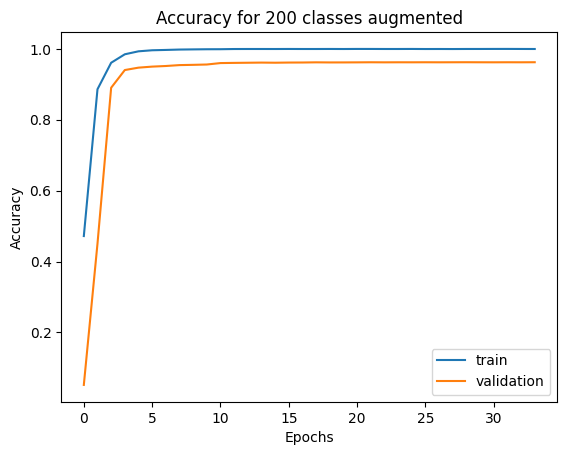

In [33]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes augmented", "Accuracy")

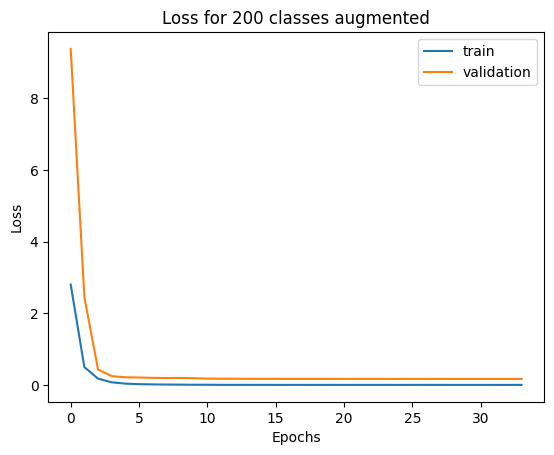

In [34]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes augmented", "Loss")

In [35]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_augmented_200_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

/tmp/ipykernel_30/994810850.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.05715314671397209 accuracy 0.9876511096954346


U+4E5D 1.0 50.0
U+4E8B 1.0 502.0
U+4ED5 1.0 138.0
U+5148 1.0 49.0
U+5165 1.0 378.0
U+516B 1.0 77.0
U+5175 1.0 46.0
U+5207 1.0 94.0
U+52A0 1.0 48.0
U+53C8 1.0 435.0
U+53CA 1.0 77.0
U+53E3 1.0 123.0
U+5409 1.0 147.0
U+571F 1.0 70.0
U+5869 1.0 67.0
U+5916 1.0 80.0
U+591C 1.0 116.0
U+5C0F 1.0 269.0
U+5DDD 1.0 59.0
U+5F15 1.0 95.0
U+5F37 1.0 59.0
U+5F80 1.0 51.0
U+60AA 1.0 48.0
U+6210 1.0 73.0
U+6211 1.0 72.0
U+662F 1.0 246.0
U+6839 1.0 57.0
U+6851 1.0 88.0
U+6C41 1.0 158.0
U+6C5F 1.0 119.0
U+6CBB 1.0 92.0
U+713C 1.0 63.0
U+716E 1.0 73.0
U+7406 1.0 69.0
U+7533 1.0 139.0
U+7537 1.0 70.0
U+76BF 1.0 51.0
U+76EE 1.0 99.0
U+77E5 1.0 50.0
U+79C1 1.0 65.0
U+7ACB 1.0 156.0
U+7AF9 1.0 46.0
U+7D19 1.0 79.0
U+805E 1.0 104.0
U+8272 1.0 112.0
U+8349 1.0 63.0
U+897F 1.0 96.0
U+898B 1.0 320.0
U+8A9E 1.0 61.0
U+8C46 1.0 56.0
U+8FD1 1.0 51.0
U+901A 1.0 63.0
U+91CE 1.0 78.0
U+91D1 1.0 79.0
U+9580 1.0 56.0
U+95A2 1.0 49.0
U+7269 0.9972222222222222 360.0
U+4E00 0.9962264150943396 530.0
U+4E91 0.996226415094339

In [ ]:
testing_models_metrics(class_amount=200, model_suff_path="/kaggle/working/model_augmented_200_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

# Augmented, 300 classes logic

In [36]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_augmented_300_stuff")

trainloader, testloader, _ = get_dataloaders_augmented(batch_size=4096, classamount=300, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

stuff = getting_stuff_for_training(classamount=300, pathes=pathes)

In [37]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_augmented_300_stuff", model_name="300 classes augmented")

  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:54<00:00,  3.40s/it]

100%|██████████| 7/7 [00:34<00:00,  4.99s/it]


Epoch: 1
Train: loss 3.1480681896209717 accuracy 0.4290337860584259
Validation: loss 8.219748497009277 accuracy 0.06748680770397186


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:40<00:00,  2.56s/it]

100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Epoch: 2
Train: loss 0.5592034459114075 accuracy 0.8780413269996643
Validation: loss 1.3914659023284912 accuracy 0.6615513563156128


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Epoch: 3
Train: loss 0.17936290800571442 accuracy 0.962145984172821
Validation: loss 0.34752872586250305 accuracy 0.9145799875259399


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.10s/it]

100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


Epoch: 4
Train: loss 0.0825812891125679 accuracy 0.9836154580116272
Validation: loss 0.2708439528942108 accuracy 0.9333718419075012


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.06s/it]

100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


Epoch: 5
Train: loss 0.04029911011457443 accuracy 0.9926522374153137
Validation: loss 0.2498050183057785 accuracy 0.9390896558761597


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.01s/it]

100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Epoch: 6
Train: loss 0.02635183185338974 accuracy 0.995273232460022
Validation: loss 0.23088817298412323 accuracy 0.9439017176628113


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.05s/it]

100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Epoch: 7
Train: loss 0.016650747507810593 accuracy 0.9975209832191467
Validation: loss 0.2196168303489685 accuracy 0.947462260723114


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.02s/it]

100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Epoch: 8
Train: loss 0.012220914475619793 accuracy 0.9980820417404175
Validation: loss 0.22037547826766968 accuracy 0.9482296109199524


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.99s/it]

  9%|▉         | 9/100 [07:58<1:12:47, 47.99s/it]

Epoch: 9
Train: loss 0.009548352099955082 accuracy 0.9986137747764587
Validation: loss 0.23056700825691223 accuracy 0.9453819990158081



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.98s/it]

100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Epoch: 10
Train: loss 0.006972426548600197 accuracy 0.998998761177063
Validation: loss 0.21807318925857544 accuracy 0.9498637318611145


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.01s/it]

100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Epoch: 11
Train: loss 0.005167297087609768 accuracy 0.9994964599609375
Validation: loss 0.19751949608325958 accuracy 0.9544664621353149


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Epoch: 12
Train: loss 0.005041206255555153 accuracy 0.9993743896484375
Validation: loss 0.19335588812828064 accuracy 0.9551835656166077


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

100%|██████████| 7/7 [00:14<00:00,  2.03s/it]


Epoch: 13
Train: loss 0.00448813708499074 accuracy 0.9994717836380005
Validation: loss 0.1897081732749939 accuracy 0.9554194808006287


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


Epoch: 14
Train: loss 0.003104435047134757 accuracy 0.999670147895813
Validation: loss 0.1890135556459427 accuracy 0.9557795524597168


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.00s/it]

100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Epoch: 15
Train: loss 0.0030212607234716415 accuracy 0.9995880126953125
Validation: loss 0.1888844519853592 accuracy 0.955919086933136


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.01s/it]

 16%|█▌        | 16/100 [13:21<1:04:44, 46.24s/it]

Epoch: 16
Train: loss 0.002561500295996666 accuracy 0.9997100830078125
Validation: loss 0.18799959123134613 accuracy 0.9555087089538574



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.02s/it]

100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Epoch: 17
Train: loss 0.0022829140070825815 accuracy 0.9998074769973755
Validation: loss 0.18681052327156067 accuracy 0.9560431838035583


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:30<00:00,  1.92s/it]

100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


Epoch: 18
Train: loss 0.0021859826520085335 accuracy 0.999786376953125
Validation: loss 0.18681903183460236 accuracy 0.9567561149597168


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

 19%|█▉        | 19/100 [15:38<1:01:56, 45.88s/it]

Epoch: 19
Train: loss 0.0019110282883048058 accuracy 0.9998321533203125
Validation: loss 0.18624000251293182 accuracy 0.9565314650535583



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.01s/it]

100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Epoch: 20
Train: loss 0.0020850165747106075 accuracy 0.999786376953125
Validation: loss 0.1862383335828781 accuracy 0.9569848775863647


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.96s/it]

 21%|██        | 21/100 [17:10<1:00:13, 45.75s/it]

Epoch: 21
Train: loss 0.001942591741681099 accuracy 0.999792218208313
Validation: loss 0.18631838262081146 accuracy 0.9565858244895935



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.95s/it]

 22%|██▏       | 22/100 [17:56<59:32, 45.80s/it]  

Epoch: 22
Train: loss 0.0017486626747995615 accuracy 0.99981689453125
Validation: loss 0.18633529543876648 accuracy 0.9566555619239807



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:30<00:00,  1.92s/it]

 23%|██▎       | 23/100 [18:41<58:25, 45.53s/it]

Epoch: 23
Train: loss 0.001643568743020296 accuracy 0.9998626708984375
Validation: loss 0.186131551861763 accuracy 0.9566206932067871



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.00s/it]

 24%|██▍       | 24/100 [19:26<57:41, 45.55s/it]

Epoch: 24
Train: loss 0.0021281579975038767 accuracy 0.9997370839118958
Validation: loss 0.18606790900230408 accuracy 0.9566709399223328



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.01s/it]

 24%|██▍       | 24/100 [20:12<1:04:00, 50.53s/it]

Epoch: 25
Train: loss 0.0020151014905422926 accuracy 0.9998074769973755
Validation: loss 0.18601733446121216 accuracy 0.9566709399223328
Best validation accuracy for 300 classes augmented: 0.9569848775863647 Epoch 20


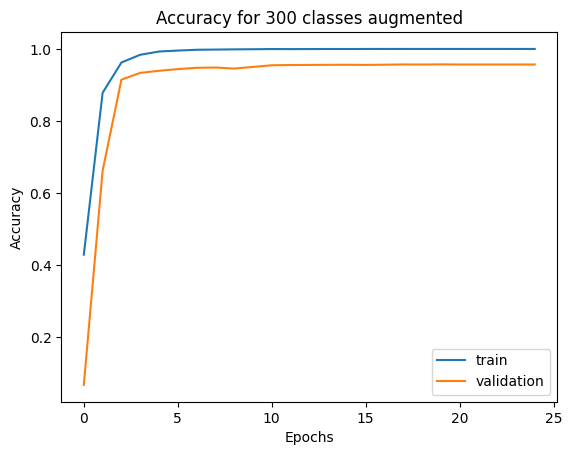

In [38]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes augmented", "Accuracy")

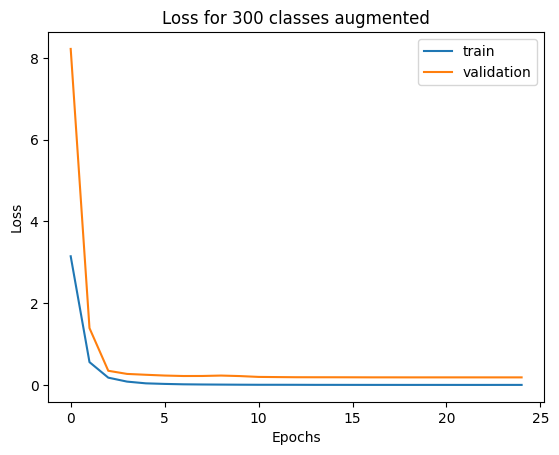

In [39]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes augmented", "Loss")

In [40]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_augmented_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_30/994810850.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:1

Test: loss 0.05720579996705055 accuracy 0.9857473969459534


U+4E00 1.0 530.0
U+4E16 1.0 146.0
U+4E5D 1.0 50.0
U+4ECA 1.0 199.0
U+4ED5 1.0 138.0
U+4EE3 1.0 40.0
U+4F55 1.0 218.0
U+4FE1 1.0 37.0
U+5148 1.0 49.0
U+5150 1.0 34.0
U+516B 1.0 77.0
U+5176 1.0 301.0
U+5341 1.0 161.0
U+5357 1.0 40.0
U+53BB 1.0 34.0
U+541B 1.0 33.0
U+5473 1.0 98.0
U+547D 1.0 32.0
U+55B0 1.0 32.0
U+564C 1.0 40.0
U+591C 1.0 116.0
U+5929 1.0 79.0
U+5B9F 1.0 40.0
U+5BB6 1.0 116.0
U+5BBF 1.0 39.0
U+5BF8 1.0 40.0
U+5C0F 1.0 269.0
U+5C11 1.0 61.0
U+5C3E 1.0 39.0
U+5DDE 1.0 126.0
U+5E2B 1.0 41.0
U+5E73 1.0 64.0
U+5EA7 1.0 46.0
U+5F15 1.0 95.0
U+5F62 1.0 51.0
U+5F7C 1.0 43.0
U+5F80 1.0 51.0
U+601D 1.0 115.0
U+60C5 1.0 38.0
U+61F8 1.0 56.0
U+6211 1.0 72.0
U+6238 1.0 113.0
U+623F 1.0 43.0
U+6268 1.0 40.0
U+6298 1.0 32.0
U+6368 1.0 37.0
U+6599 1.0 40.0
U+660E 1.0 60.0
U+662F 1.0 246.0
U+66FF 1.0 34.0
U+671D 1.0 39.0
U+6839 1.0 57.0
U+6851 1.0 88.0
U+6885 1.0 34.0
U+6A23 1.0 46.0
U+6B63 1.0 37.0
U+6B66 1.0 41.0
U+6C17 1.0 66.0
U+6C41 1.0 158.0
U+6CB9 1.0 40.0
U+6D77 1.0 52.0
U+6E6F 1.

In [ ]:
testing_models_metrics(class_amount=300, model_suff_path="/kaggle/working/model_augmented_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

# Pretrained CASIA-HWDB unfreeze all, 150 classes logic

In [41]:
# Getting stuff for training 

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_150_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 150, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

stuff = getting_stuff_for_training(classamount=150, pathes=pathes, pretrained=True)

/tmp/ipykernel_30/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [42]:
# Training loop 

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_all_150_stuff", model_name="150 classes unfreeze all")

  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:31<00:00,  2.44s/it]

100%|██████████| 6/6 [00:18<00:00,  3.08s/it]


Epoch: 1
Train: loss 1.7089707851409912 accuracy 0.676204264163971
Validation: loss 0.48578569293022156 accuracy 0.8758091926574707


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:27<00:00,  2.10s/it]

100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch: 2
Train: loss 0.1562289148569107 accuracy 0.9610745310783386
Validation: loss 0.1689268797636032 accuracy 0.9593736529350281


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.98s/it]

100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch: 3
Train: loss 0.07227519899606705 accuracy 0.9816074967384338
Validation: loss 0.13512760400772095 accuracy 0.9672026038169861


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.98s/it]

100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch: 4
Train: loss 0.043587252497673035 accuracy 0.9904533624649048
Validation: loss 0.11639456450939178 accuracy 0.9710967540740967


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.95s/it]

100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch: 5
Train: loss 0.025220278650522232 accuracy 0.9951171875
Validation: loss 0.11053198575973511 accuracy 0.9756178259849548


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:24<00:00,  1.91s/it]

100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch: 6
Train: loss 0.018056970089673996 accuracy 0.9961560964584351
Validation: loss 0.10461603850126266 accuracy 0.9761181473731995


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:27<00:00,  2.08s/it]

100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch: 7
Train: loss 0.011973091401159763 accuracy 0.9981032013893127
Validation: loss 0.10466301441192627 accuracy 0.9769726395606995


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

  8%|▊         | 8/100 [05:24<1:00:27, 39.43s/it]

Epoch: 8
Train: loss 0.00833361130207777 accuracy 0.9988168478012085
Validation: loss 0.10675894469022751 accuracy 0.976769208908081



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.95s/it]

100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch: 9
Train: loss 0.006305386312305927 accuracy 0.9989858865737915
Validation: loss 0.10391871631145477 accuracy 0.9784660935401917


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.97s/it]

 10%|█         | 10/100 [06:41<58:24, 38.94s/it]

Epoch: 10
Train: loss 0.005078233312815428 accuracy 0.999267578125
Validation: loss 0.10286300629377365 accuracy 0.9775769710540771



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.95s/it]

 11%|█         | 11/100 [07:19<57:36, 38.84s/it]

Epoch: 11
Train: loss 0.0038973952177911997 accuracy 0.9994929432868958
Validation: loss 0.10237332433462143 accuracy 0.9779024720191956



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.92s/it]

 12%|█▏        | 12/100 [07:57<56:19, 38.40s/it]

Epoch: 12
Train: loss 0.0038237490225583315 accuracy 0.9993802309036255
Validation: loss 0.10180553793907166 accuracy 0.9780245423316956



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.02s/it]

100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch: 13
Train: loss 0.005292925983667374 accuracy 0.9991484880447388
Validation: loss 0.10177000612020493 accuracy 0.9786288738250732


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:24<00:00,  1.88s/it]

 14%|█▍        | 14/100 [09:13<54:54, 38.30s/it]

Epoch: 14
Train: loss 0.0038171056658029556 accuracy 0.999336302280426
Validation: loss 0.10246247053146362 accuracy 0.9784254431724548



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:24<00:00,  1.91s/it]

 15%|█▌        | 15/100 [09:51<53:45, 37.94s/it]

Epoch: 15
Train: loss 0.00402359664440155 accuracy 0.9994178414344788
Validation: loss 0.10185451805591583 accuracy 0.9783847332000732



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.96s/it]

 16%|█▌        | 16/100 [10:29<53:06, 37.94s/it]

Epoch: 16
Train: loss 0.003669602330774069 accuracy 0.9995680451393127
Validation: loss 0.10145923495292664 accuracy 0.9785881638526917



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.93s/it]

100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch: 17
Train: loss 0.0028286059387028217 accuracy 0.9996619820594788
Validation: loss 0.10155297815799713 accuracy 0.9788262844085693


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.94s/it]

 18%|█▊        | 18/100 [11:45<51:55, 37.99s/it]

Epoch: 18
Train: loss 0.0033758985809981823 accuracy 0.9995680451393127
Validation: loss 0.10118140280246735 accuracy 0.9785475134849548



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.96s/it]

100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch: 19
Train: loss 0.0032282513566315174 accuracy 0.9995680451393127
Validation: loss 0.10094642639160156 accuracy 0.978942334651947


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:24<00:00,  1.89s/it]

100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch: 20
Train: loss 0.0030986638739705086 accuracy 0.9996619820594788
Validation: loss 0.10091115534305573 accuracy 0.9790236949920654


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.99s/it]

 21%|██        | 21/100 [13:40<50:19, 38.22s/it]

Epoch: 21
Train: loss 0.0034536924213171005 accuracy 0.999436616897583
Validation: loss 0.10095621645450592 accuracy 0.9788262844085693



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch: 22
Train: loss 0.0031986997928470373 accuracy 0.9996432065963745
Validation: loss 0.10092933475971222 accuracy 0.979064404964447


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.98s/it]

 23%|██▎       | 23/100 [14:58<49:37, 38.67s/it]

Epoch: 23
Train: loss 0.002376674208790064 accuracy 0.9997370839118958
Validation: loss 0.10091949999332428 accuracy 0.9789829850196838



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  2.00s/it]

100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch: 24
Train: loss 0.0024355973582714796 accuracy 0.9996995329856873
Validation: loss 0.1009225994348526 accuracy 0.9791050553321838


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:24<00:00,  1.89s/it]

 25%|██▌       | 25/100 [16:15<48:10, 38.54s/it]

Epoch: 25
Train: loss 0.0032610101625323296 accuracy 0.9994553923606873
Validation: loss 0.10087599605321884 accuracy 0.9787855744361877



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.96s/it]

 26%|██▌       | 26/100 [16:53<47:20, 38.38s/it]

Epoch: 26
Train: loss 0.00267864135093987 accuracy 0.9996995329856873
Validation: loss 0.10087677091360092 accuracy 0.9787855744361877



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.04s/it]

 27%|██▋       | 27/100 [17:33<46:58, 38.61s/it]

Epoch: 27
Train: loss 0.004010739736258984 accuracy 0.999261200428009
Validation: loss 0.10075574368238449 accuracy 0.9791050553321838



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:24<00:00,  1.92s/it]

 28%|██▊       | 28/100 [18:11<46:06, 38.43s/it]

Epoch: 28
Train: loss 0.0030086964834481478 accuracy 0.9996243715286255
Validation: loss 0.10094107687473297 accuracy 0.9786288738250732



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.96s/it]

 28%|██▊       | 28/100 [18:49<48:23, 40.33s/it]

Epoch: 29
Train: loss 0.0028816789854317904 accuracy 0.9995492696762085
Validation: loss 0.10093659162521362 accuracy 0.9790236949920654
Best validation accuracy for 150 classes unfreeze all: 0.9791050553321838 Epoch 24


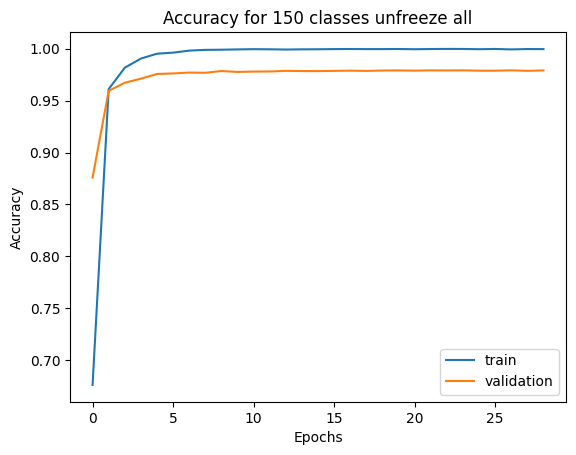

In [43]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes unfreeze all", "Accuracy")

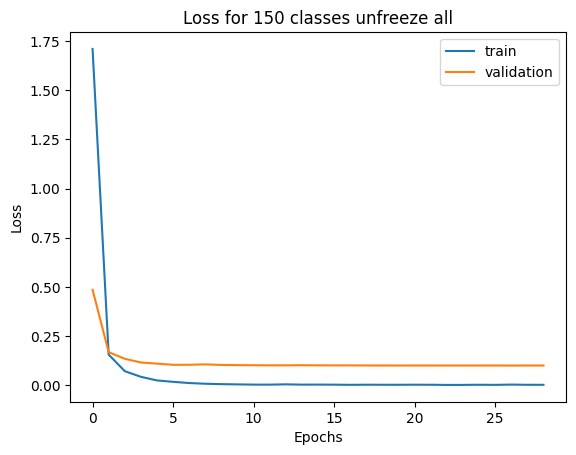

In [44]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes unfreeze all", "Loss")

In [45]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_30/994810850.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.04281336069107056 accuracy 0.9922177195549011


U+4E00 1.0 530.0
U+4E03 1.0 77.0
U+4E09 1.0 238.0
U+4E0B 1.0 150.0
U+4E2D 1.0 237.0
U+4E94 1.0 165.0
U+4ED5 1.0 138.0
U+4ED8 1.0 86.0
U+4F55 1.0 218.0
U+4F5C 1.0 62.0
U+5185 1.0 106.0
U+5375 1.0 59.0
U+53CA 1.0 77.0
U+5473 1.0 98.0
U+56DB 1.0 131.0
U+571F 1.0 70.0
U+5869 1.0 67.0
U+5929 1.0 79.0
U+592B 1.0 99.0
U+5C4B 1.0 82.0
U+5C71 1.0 164.0
U+5DDE 1.0 126.0
U+5DE6 1.0 76.0
U+5E73 1.0 64.0
U+5F15 1.0 95.0
U+5FC3 1.0 184.0
U+601D 1.0 115.0
U+6211 1.0 72.0
U+6216 1.0 60.0
U+6238 1.0 113.0
U+6240 1.0 188.0
U+624B 1.0 157.0
U+660E 1.0 60.0
U+662F 1.0 246.0
U+66F8 1.0 68.0
U+6851 1.0 88.0
U+6C41 1.0 158.0
U+6CBB 1.0 92.0
U+713C 1.0 63.0
U+7406 1.0 69.0
U+751F 1.0 128.0
U+7528 1.0 79.0
U+7530 1.0 59.0
U+7537 1.0 70.0
U+795E 1.0 76.0
U+7A0B 1.0 73.0
U+7A2E 1.0 73.0
U+7D19 1.0 79.0
U+7F6E 1.0 95.0
U+8005 1.0 67.0
U+805E 1.0 104.0
U+8336 1.0 91.0
U+8A9E 1.0 61.0
U+901A 1.0 63.0
U+9053 1.0 83.0
U+91CE 1.0 78.0
U+9B5A 1.0 83.0
U+53C8 0.9977011494252873 435.0
U+7269 0.9972222222222222 360.0
U+51

In [ ]:
testing_models_metrics(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

# Pretrained CASIA-HWDB unfreeze all, 200 classes logic

In [46]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_200_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 200, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

stuff = getting_stuff_for_training(classamount=200, pathes=pathes, pretrained=True)

/tmp/ipykernel_30/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [47]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_all_200_stuff", model_name="200 classes unfreeze all")

  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.49s/it]

100%|██████████| 6/6 [00:21<00:00,  3.52s/it]


Epoch: 1
Train: loss 1.9130823612213135 accuracy 0.6540305018424988
Validation: loss 0.5280226469039917 accuracy 0.8656523823738098


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.25s/it]

100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch: 2
Train: loss 0.1698814481496811 accuracy 0.9597879648208618
Validation: loss 0.17869114875793457 accuracy 0.9535046219825745


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.14s/it]

100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch: 3
Train: loss 0.07182633131742477 accuracy 0.9835443496704102
Validation: loss 0.12994489073753357 accuracy 0.9678736329078674


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:29<00:00,  2.08s/it]

100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch: 4
Train: loss 0.03981709107756615 accuracy 0.9922062754631042
Validation: loss 0.11635394394397736 accuracy 0.9708768725395203


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.96s/it]

100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch: 5
Train: loss 0.024621831253170967 accuracy 0.9951373338699341
Validation: loss 0.11163315176963806 accuracy 0.9720849394798279


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.00s/it]

100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch: 6
Train: loss 0.01733512245118618 accuracy 0.996618926525116
Validation: loss 0.10599832981824875 accuracy 0.9739487767219543


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.07s/it]

100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch: 7
Train: loss 0.011411608196794987 accuracy 0.9982048273086548
Validation: loss 0.10205113887786865 accuracy 0.975020706653595


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.94s/it]

100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch: 8
Train: loss 0.008663701824843884 accuracy 0.9986760020256042
Validation: loss 0.10134275257587433 accuracy 0.9762038588523865


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.01s/it]

100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch: 9
Train: loss 0.00592331076040864 accuracy 0.9992682337760925
Validation: loss 0.10081484913825989 accuracy 0.9762852191925049


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.00s/it]

100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch: 10
Train: loss 0.0044668931514024734 accuracy 0.9993721842765808
Validation: loss 0.10180243849754333 accuracy 0.9764917492866516


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.95s/it]

100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch: 11
Train: loss 0.004290659446269274 accuracy 0.9994768500328064
Validation: loss 0.1011352464556694 accuracy 0.9765027165412903


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.94s/it]

100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch: 12
Train: loss 0.00415795436128974 accuracy 0.9993732571601868
Validation: loss 0.10062931478023529 accuracy 0.9765105247497559


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.06s/it]

100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch: 13
Train: loss 0.004003888927400112 accuracy 0.9994597434997559
Validation: loss 0.10014252364635468 accuracy 0.9767953753471375


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.98s/it]

100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch: 14
Train: loss 0.0037457707803696394 accuracy 0.9996515512466431
Validation: loss 0.09945723414421082 accuracy 0.9768689274787903


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.99s/it]

100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch: 15
Train: loss 0.0027957549318671227 accuracy 0.9997035264968872
Validation: loss 0.09940463304519653 accuracy 0.9769580960273743


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.05s/it]

100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch: 16
Train: loss 0.003367423312738538 accuracy 0.9996163249015808
Validation: loss 0.09916277229785919 accuracy 0.9772648811340332


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.06s/it]

100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch: 17
Train: loss 0.0034270198084414005 accuracy 0.9995640516281128
Validation: loss 0.09915560483932495 accuracy 0.9773055911064148


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.94s/it]

100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch: 18
Train: loss 0.003446647198870778 accuracy 0.9995818138122559
Validation: loss 0.09919329732656479 accuracy 0.9773869514465332


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.00s/it]

100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch: 19
Train: loss 0.0029499144293367863 accuracy 0.9997035264968872
Validation: loss 0.09880062937736511 accuracy 0.9774088263511658


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.06s/it]

 20%|██        | 20/100 [14:15<55:49, 41.87s/it]

Epoch: 20
Train: loss 0.003379303030669689 accuracy 0.9995469450950623
Validation: loss 0.09851731359958649 accuracy 0.9770832657814026



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.98s/it]

 21%|██        | 21/100 [14:56<55:01, 41.80s/it]

Epoch: 21
Train: loss 0.0027520833536982536 accuracy 0.9997733235359192
Validation: loss 0.09850414842367172 accuracy 0.9771239757537842



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.98s/it]

 22%|██▏       | 22/100 [15:37<53:52, 41.45s/it]

Epoch: 22
Train: loss 0.0035350474063307047 accuracy 0.9995294809341431
Validation: loss 0.09844177216291428 accuracy 0.9771646857261658



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:28<00:00,  2.06s/it]

 23%|██▎       | 23/100 [16:19<53:32, 41.72s/it]

Epoch: 23
Train: loss 0.0033412063494324684 accuracy 0.9997383952140808
Validation: loss 0.09839751571416855 accuracy 0.9772460460662842



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.99s/it]

 23%|██▎       | 23/100 [17:01<56:59, 44.41s/it]

Epoch: 24
Train: loss 0.0029246245976537466 accuracy 0.9997209906578064
Validation: loss 0.0984324961900711 accuracy 0.9771646857261658
Best validation accuracy for 200 classes unfreeze all: 0.9774088263511658 Epoch 19


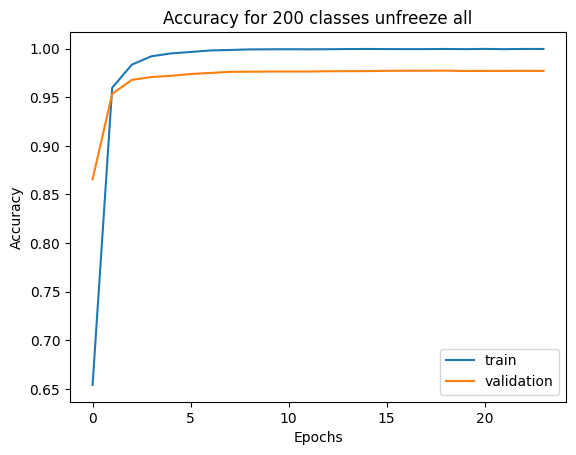

In [48]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes unfreeze all", "Accuracy")

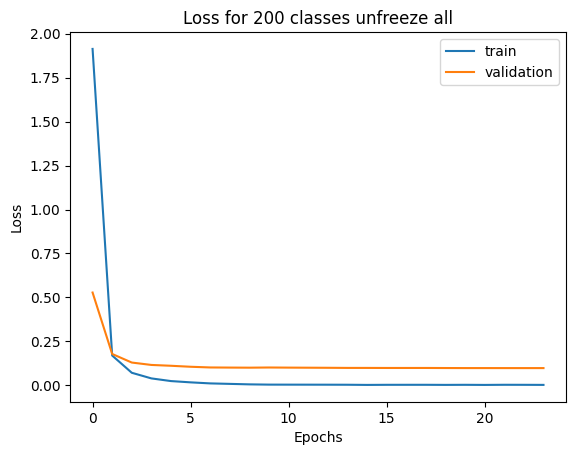

In [49]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes unfreeze all", "Loss")

In [50]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_200_stuff", train_test_indices_path="/kaggle/working/train_test_indices_200.pkl")

/tmp/ipykernel_30/994810850.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.03513100743293762 accuracy 0.9926416277885437


U+4E00 1.0 530.0
U+4E03 1.0 77.0
U+4E0B 1.0 150.0
U+4E4B 1.0 151.0
U+4E5D 1.0 50.0
U+4EAC 1.0 67.0
U+4ECA 1.0 199.0
U+4F5C 1.0 62.0
U+4F8D 1.0 48.0
U+5148 1.0 49.0
U+516D 1.0 121.0
U+5171 1.0 48.0
U+5175 1.0 46.0
U+5207 1.0 94.0
U+524D 1.0 178.0
U+52A0 1.0 48.0
U+5375 1.0 59.0
U+53CA 1.0 77.0
U+53E3 1.0 123.0
U+53E4 1.0 64.0
U+53F3 1.0 114.0
U+5408 1.0 175.0
U+5409 1.0 147.0
U+540D 1.0 129.0
U+5473 1.0 98.0
U+547C 1.0 52.0
U+5869 1.0 67.0
U+5916 1.0 80.0
U+591C 1.0 116.0
U+5929 1.0 79.0
U+592A 1.0 66.0
U+592B 1.0 99.0
U+5965 1.0 48.0
U+5BB6 1.0 116.0
U+5C0F 1.0 269.0
U+5C45 1.0 115.0
U+5C71 1.0 164.0
U+5DDD 1.0 59.0
U+5DE6 1.0 76.0
U+5E73 1.0 64.0
U+5EA7 1.0 46.0
U+5F15 1.0 95.0
U+5F62 1.0 51.0
U+5F80 1.0 51.0
U+5F97 1.0 45.0
U+5FC3 1.0 184.0
U+601D 1.0 115.0
U+60AA 1.0 48.0
U+61F8 1.0 56.0
U+6210 1.0 73.0
U+6211 1.0 72.0
U+6216 1.0 60.0
U+6238 1.0 113.0
U+624B 1.0 157.0
U+6545 1.0 49.0
U+65B9 1.0 261.0
U+660E 1.0 60.0
U+662F 1.0 246.0
U+6642 1.0 200.0
U+6708 1.0 133.0
U+672C 1.0 76.0


In [ ]:
testing_models_metrics(class_amount=200, model_suff_path="/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_200_stuff", train_test_indices_path="/kaggle/working/train_test_indices_200.pkl")

# Pretrained CASIA-HWDB unfreeze all, 300 classes logic

In [51]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_300_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 300, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

stuff = getting_stuff_for_training(classamount=300, pathes=pathes, pretrained=True)

/tmp/ipykernel_30/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [52]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_all_300_stuff", model_name="300 classes unfreeze all")

  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:40<00:00,  2.53s/it]

100%|██████████| 7/7 [00:20<00:00,  2.98s/it]


Epoch: 1
Train: loss 1.997125506401062 accuracy 0.6488614082336426
Validation: loss 0.5180945992469788 accuracy 0.8691439032554626


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:34<00:00,  2.17s/it]

100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Epoch: 2
Train: loss 0.17762334644794464 accuracy 0.9583748579025269
Validation: loss 0.18853166699409485 accuracy 0.9539473652839661


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.08s/it]

100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Epoch: 3
Train: loss 0.06905154883861542 accuracy 0.9854782223701477
Validation: loss 0.1426224410533905 accuracy 0.9654784798622131


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


Epoch: 4
Train: loss 0.039049047976732254 accuracy 0.9918810129165649
Validation: loss 0.12977223098278046 accuracy 0.9688031077384949


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.94s/it]

100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


Epoch: 5
Train: loss 0.023382052779197693 accuracy 0.9960620403289795
Validation: loss 0.11964774876832962 accuracy 0.9712312817573547


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Epoch: 6
Train: loss 0.01610066182911396 accuracy 0.997501015663147
Validation: loss 0.114951953291893 accuracy 0.9726458191871643


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.02s/it]

100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Epoch: 7
Train: loss 0.011597986333072186 accuracy 0.9982076287269592
Validation: loss 0.11527703702449799 accuracy 0.9730951189994812


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


Epoch: 8
Train: loss 0.008494805544614792 accuracy 0.998671293258667
Validation: loss 0.11585011333227158 accuracy 0.9741373062133789


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

  9%|▉         | 9/100 [07:14<1:10:31, 46.50s/it]

Epoch: 9
Train: loss 0.005803548265248537 accuracy 0.9992393851280212
Validation: loss 0.11573447287082672 accuracy 0.9737926721572876



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Epoch: 10
Train: loss 0.0052054147236049175 accuracy 0.9992851614952087
Validation: loss 0.11355125904083252 accuracy 0.9749045968055725


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.05s/it]

100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Epoch: 11
Train: loss 0.004931638017296791 accuracy 0.9993497133255005
Validation: loss 0.11218269914388657 accuracy 0.9750595092773438


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  2.00s/it]

100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Epoch: 12
Train: loss 0.004529195372015238 accuracy 0.999456524848938
Validation: loss 0.11161507666110992 accuracy 0.9754780530929565


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:30<00:00,  1.92s/it]

 13%|█▎        | 13/100 [10:19<1:06:50, 46.10s/it]

Epoch: 13
Train: loss 0.0038303108885884285 accuracy 0.99957275390625
Validation: loss 0.11159180104732513 accuracy 0.9753498435020447



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.94s/it]

100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Epoch: 14
Train: loss 0.003352648578584194 accuracy 0.999603271484375
Validation: loss 0.11135145276784897 accuracy 0.9755396246910095


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

 15%|█▌        | 15/100 [11:49<1:04:39, 45.64s/it]

Epoch: 15
Train: loss 0.0031197909265756607 accuracy 0.9996818900108337
Validation: loss 0.11133959889411926 accuracy 0.9754893183708191



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.00s/it]

 16%|█▌        | 16/100 [12:35<1:03:59, 45.71s/it]

Epoch: 16
Train: loss 0.003320949152112007 accuracy 0.999639630317688
Validation: loss 0.11088880151510239 accuracy 0.9753888249397278



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:30<00:00,  1.93s/it]

 17%|█▋        | 17/100 [13:21<1:03:22, 45.81s/it]

Epoch: 17
Train: loss 0.002830746816471219 accuracy 0.999700665473938
Validation: loss 0.11065368354320526 accuracy 0.9754042029380798



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Epoch: 18
Train: loss 0.0032332120463252068 accuracy 0.9996150135993958
Validation: loss 0.11061510443687439 accuracy 0.9757294058799744


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

 19%|█▉        | 19/100 [14:52<1:01:44, 45.73s/it]

Epoch: 19
Train: loss 0.0029091148171573877 accuracy 0.9996607899665833
Validation: loss 0.11066761612892151 accuracy 0.9755396246910095



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.03s/it]

 20%|██        | 20/100 [15:39<1:01:06, 45.83s/it]

Epoch: 20
Train: loss 0.002636904362589121 accuracy 0.9996854066848755
Validation: loss 0.11061492562294006 accuracy 0.9755047559738159



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.97s/it]

 21%|██        | 21/100 [16:25<1:00:37, 46.05s/it]

Epoch: 21
Train: loss 0.0025528327096253633 accuracy 0.9997406005859375
Validation: loss 0.11056280881166458 accuracy 0.9754155278205872



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:30<00:00,  1.94s/it]

 22%|██▏       | 22/100 [17:11<59:44, 45.95s/it]  

Epoch: 22
Train: loss 0.0026571904309093952 accuracy 0.99969482421875
Validation: loss 0.11053843051195145 accuracy 0.9754155278205872



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.02s/it]

 22%|██▏       | 22/100 [17:57<1:03:39, 48.97s/it]

Epoch: 23
Train: loss 0.003351495834067464 accuracy 0.9995082020759583
Validation: loss 0.11055614799261093 accuracy 0.9754155278205872
Best validation accuracy for 300 classes unfreeze all: 0.9757294058799744 Epoch 18


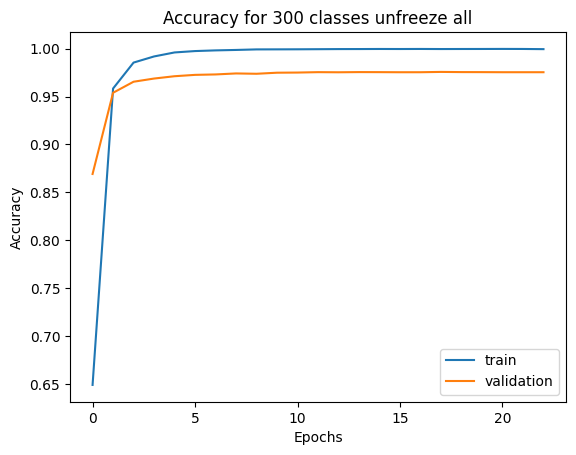

In [53]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes unfreeze all", "Accuracy")

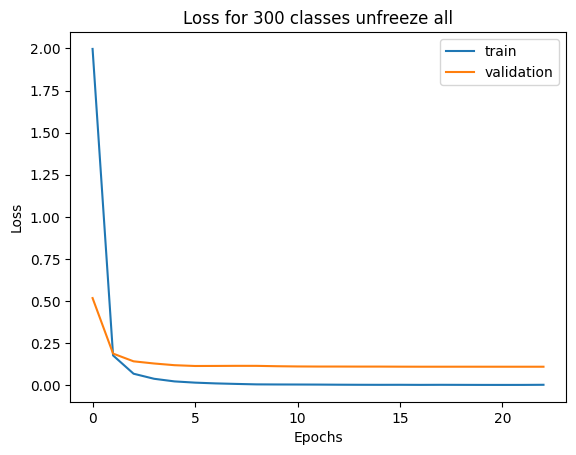

In [54]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes unfreeze all", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

In [ ]:
testing_models_metrics(class_amount=300, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

# Pretrained CASIA-HWDB unfreeze last, 150 classes logic

In [56]:
# Getting stuff for training 

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_150_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 150, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

stuff = getting_stuff_for_training(classamount=150, pathes=pathes, pretrained=True)

/tmp/ipykernel_30/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [57]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_last_150_stuff", model_name="150 classes unfreeze last", freeze_base=True)

  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

  1%|          | 1/100 [00:51<1:24:57, 51.49s/it]

Epoch: 1
Train: loss 3.3649256229400635 accuracy 0.34598538279533386
Validation: loss 1.5747575759887695 accuracy 0.7149497866630554



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:23<00:00,  1.83s/it]

  2%|▏         | 2/100 [01:28<1:10:18, 43.05s/it]

Epoch: 2
Train: loss 0.950308084487915 accuracy 0.820933997631073
Validation: loss 0.648256242275238 accuracy 0.8642475605010986



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:23<00:00,  1.79s/it]

  3%|▎         | 3/100 [02:04<1:04:34, 39.95s/it]

Epoch: 3
Train: loss 0.5056447982788086 accuracy 0.8933823108673096
Validation: loss 0.4552220106124878 accuracy 0.896880567073822



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.68s/it]

  4%|▍         | 4/100 [02:40<1:01:09, 38.23s/it]

Epoch: 4
Train: loss 0.368130087852478 accuracy 0.9190985560417175
Validation: loss 0.3837704658508301 accuracy 0.9113509058952332



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.67s/it]

  5%|▌         | 5/100 [03:14<58:15, 36.79s/it]  

Epoch: 5
Train: loss 0.30165383219718933 accuracy 0.9349493384361267
Validation: loss 0.3423755168914795 accuracy 0.9217026829719543



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:22<00:00,  1.73s/it]

  6%|▌         | 6/100 [03:50<56:56, 36.35s/it]

Epoch: 6
Train: loss 0.2695203721523285 accuracy 0.9438323378562927
Validation: loss 0.31950801610946655 accuracy 0.9264903664588928



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.66s/it]

  7%|▋         | 7/100 [04:24<55:28, 35.79s/it]

Epoch: 7
Train: loss 0.24296556413173676 accuracy 0.9490348100662231
Validation: loss 0.30231308937072754 accuracy 0.9289786219596863



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:22<00:00,  1.77s/it]

  8%|▊         | 8/100 [05:00<54:47, 35.74s/it]

Epoch: 8
Train: loss 0.21557049453258514 accuracy 0.956241250038147
Validation: loss 0.28660738468170166 accuracy 0.931751549243927



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.65s/it]

  9%|▉         | 9/100 [05:35<53:41, 35.40s/it]

Epoch: 9
Train: loss 0.20189684629440308 accuracy 0.9597402811050415
Validation: loss 0.2787143588066101 accuracy 0.9331696629524231



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.67s/it]

 10%|█         | 10/100 [06:09<52:34, 35.05s/it]

Epoch: 10
Train: loss 0.1829986423254013 accuracy 0.9646422863006592
Validation: loss 0.2706955373287201 accuracy 0.9351513385772705



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:22<00:00,  1.70s/it]

 11%|█         | 11/100 [06:44<52:09, 35.16s/it]

Epoch: 11
Train: loss 0.17440353333950043 accuracy 0.9653871059417725
Validation: loss 0.27000927925109863 accuracy 0.9352673888206482



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.68s/it]

 12%|█▏        | 12/100 [07:19<51:12, 34.91s/it]

Epoch: 12
Train: loss 0.17942187190055847 accuracy 0.9631577730178833
Validation: loss 0.26747918128967285 accuracy 0.9355582594871521



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.69s/it]

 13%|█▎        | 13/100 [07:53<50:34, 34.88s/it]

Epoch: 13
Train: loss 0.17593634128570557 accuracy 0.9654810428619385
Validation: loss 0.26688098907470703 accuracy 0.9360058307647705



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:20<00:00,  1.61s/it]

 14%|█▍        | 14/100 [08:27<49:33, 34.57s/it]

Epoch: 14
Train: loss 0.17353364825248718 accuracy 0.9670025706291199
Validation: loss 0.2661588788032532 accuracy 0.9359998106956482



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.68s/it]

 15%|█▌        | 15/100 [09:02<48:54, 34.52s/it]

Epoch: 15
Train: loss 0.17098255455493927 accuracy 0.9679040312767029
Validation: loss 0.26504337787628174 accuracy 0.9359651207923889



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.69s/it]

 16%|█▌        | 16/100 [09:37<48:42, 34.79s/it]

Epoch: 16
Train: loss 0.171460822224617 accuracy 0.9667640328407288
Validation: loss 0.2633306384086609 accuracy 0.9368075728416443



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.65s/it]

 17%|█▋        | 17/100 [10:11<47:38, 34.44s/it]

Epoch: 17
Train: loss 0.16054803133010864 accuracy 0.9702204465866089
Validation: loss 0.26211944222450256 accuracy 0.936650812625885



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.67s/it]

 18%|█▊        | 18/100 [10:46<47:13, 34.56s/it]

Epoch: 18
Train: loss 0.16305434703826904 accuracy 0.9707902073860168
Validation: loss 0.2613130807876587 accuracy 0.9371737837791443



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.64s/it]

 19%|█▉        | 19/100 [11:19<46:15, 34.26s/it]

Epoch: 19
Train: loss 0.16611531376838684 accuracy 0.967997133731842
Validation: loss 0.2609589695930481 accuracy 0.9376213550567627



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:22<00:00,  1.72s/it]

 20%|██        | 20/100 [11:54<45:55, 34.44s/it]

Epoch: 20
Train: loss 0.16131439805030823 accuracy 0.9691934585571289
Validation: loss 0.2593025863170624 accuracy 0.9377374053001404



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.64s/it]

 21%|██        | 21/100 [12:28<45:10, 34.31s/it]

Epoch: 21
Train: loss 0.16676513850688934 accuracy 0.9675588011741638
Validation: loss 0.25856995582580566 accuracy 0.9377374053001404



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.69s/it]

 22%|██▏       | 22/100 [13:02<44:35, 34.31s/it]

Epoch: 22
Train: loss 0.1627202033996582 accuracy 0.9690995812416077
Validation: loss 0.2586893141269684 accuracy 0.9380221962928772



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.64s/it]

 23%|██▎       | 23/100 [13:37<44:02, 34.32s/it]

Epoch: 23
Train: loss 0.1630108654499054 accuracy 0.9697129130363464
Validation: loss 0.259331077337265 accuracy 0.9377374053001404



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.66s/it]

 24%|██▍       | 24/100 [14:10<43:14, 34.14s/it]

Epoch: 24
Train: loss 0.15826979279518127 accuracy 0.9703450798988342
Validation: loss 0.25916963815689087 accuracy 0.9379408359527588



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:21<00:00,  1.68s/it]

 25%|██▌       | 25/100 [14:45<42:56, 34.35s/it]

Epoch: 25
Train: loss 0.1573895514011383 accuracy 0.9709716439247131
Validation: loss 0.25924426317214966 accuracy 0.9379001259803772



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:20<00:00,  1.60s/it]

 26%|██▌       | 26/100 [15:19<41:59, 34.04s/it]

Epoch: 26
Train: loss 0.15460526943206787 accuracy 0.9704580903053284
Validation: loss 0.25874531269073486 accuracy 0.9380221962928772



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:22<00:00,  1.71s/it]

 26%|██▌       | 26/100 [15:53<45:15, 36.69s/it]

Epoch: 27
Train: loss 0.16468992829322815 accuracy 0.97057044506073
Validation: loss 0.2586207389831543 accuracy 0.9379408359527588
Best validation accuracy for 150 classes unfreeze last: 0.9380221962928772 Epoch 22


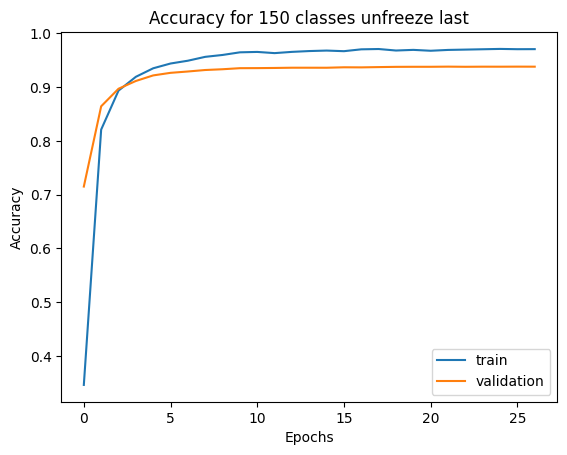

In [58]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes unfreeze last", "Accuracy")

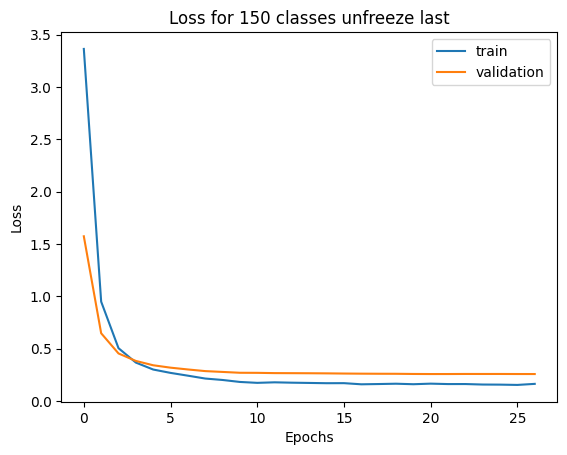

In [59]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes unfreeze last", "Loss")

In [60]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_30/994810850.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.19264362752437592 accuracy 0.9582403302192688


U+4E03 1.0 77.0
U+4ED8 1.0 86.0
U+5207 1.0 94.0
U+53CA 1.0 77.0
U+5DE6 1.0 76.0
U+6C41 1.0 158.0
U+6C5F 1.0 119.0
U+7406 1.0 69.0
U+7537 1.0 70.0
U+795E 1.0 76.0
U+901A 1.0 63.0
U+9577 1.0 73.0
U+662F 0.9959349593495935 246.0
U+5408 0.9942857142857143 175.0
U+4ED5 0.9927536231884058 138.0
U+4E00 0.9924528301886792 530.0
U+6728 0.9914529914529915 117.0
U+9CE5 0.9905660377358491 106.0
U+5473 0.9897959183673469 98.0
U+897F 0.9895833333333334 96.0
U+548C 0.9893617021276596 94.0
U+9B5A 0.9879518072289156 83.0
U+7528 0.9873417721518988 79.0
U+8695 0.9871794871794872 156.0
U+516B 0.987012987012987 77.0
U+6210 0.9863013698630136 73.0
U+7A2E 0.9863013698630136 73.0
U+4EAC 0.9850746268656716 67.0
U+5869 0.9850746268656716 67.0
U+9152 0.9846153846153847 130.0
U+540D 0.9844961240310077 129.0
U+6771 0.9841269841269841 126.0
U+713C 0.9841269841269841 63.0
U+5C11 0.9836065573770492 61.0
U+706B 0.9836065573770492 61.0
U+7B2C 0.9836065573770492 61.0
U+6216 0.9833333333333333 60.0
U+660E 0.9833333333333

In [ ]:
testing_models_metrics(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

# Pretrained CASIA-HWDB unfreeze last, 200 classes logic

In [61]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_200_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 200, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

stuff = getting_stuff_for_training(classamount=200, pathes=pathes, pretrained=True)

/tmp/ipykernel_30/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [62]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_last_200_stuff", model_name="200 classes unfreeze last", freeze_base=True)

  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:36<00:00,  2.63s/it]

  1%|          | 1/100 [00:58<1:36:56, 58.75s/it]

Epoch: 1
Train: loss 3.516693115234375 accuracy 0.3474362790584564
Validation: loss 1.5590342283248901 accuracy 0.7289919853210449



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:30<00:00,  2.17s/it]

  2%|▏         | 2/100 [01:42<1:21:25, 49.86s/it]

Epoch: 2
Train: loss 0.9324818253517151 accuracy 0.8257555365562439
Validation: loss 0.6460895538330078 accuracy 0.8660712838172913



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.99s/it]

  3%|▎         | 3/100 [02:24<1:14:56, 46.36s/it]

Epoch: 3
Train: loss 0.49107325077056885 accuracy 0.8978649973869324
Validation: loss 0.45613932609558105 accuracy 0.8993570804595947



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:26<00:00,  1.91s/it]

  4%|▍         | 4/100 [03:04<1:10:01, 43.77s/it]

Epoch: 4
Train: loss 0.35895392298698425 accuracy 0.9258314967155457
Validation: loss 0.3863876760005951 accuracy 0.9129455089569092



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.97s/it]

  5%|▌         | 5/100 [03:45<1:07:31, 42.65s/it]

Epoch: 5
Train: loss 0.28893333673477173 accuracy 0.9421744346618652
Validation: loss 0.34670621156692505 accuracy 0.9195120334625244



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:26<00:00,  1.88s/it]

  6%|▌         | 6/100 [04:25<1:05:35, 41.87s/it]

Epoch: 6
Train: loss 0.2528701424598694 accuracy 0.95106440782547
Validation: loss 0.3239586353302002 accuracy 0.9244587421417236



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:25<00:00,  1.85s/it]

  7%|▋         | 7/100 [05:04<1:03:31, 40.99s/it]

Epoch: 7
Train: loss 0.2293291538953781 accuracy 0.9579653739929199
Validation: loss 0.3090231418609619 accuracy 0.9276527762413025



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.94s/it]

  8%|▊         | 8/100 [05:44<1:02:30, 40.77s/it]

Epoch: 8
Train: loss 0.19857051968574524 accuracy 0.9627589583396912
Validation: loss 0.2955220937728882 accuracy 0.9306183457374573



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:26<00:00,  1.87s/it]

  9%|▉         | 9/100 [06:25<1:01:32, 40.58s/it]

Epoch: 9
Train: loss 0.18679827451705933 accuracy 0.9670602083206177
Validation: loss 0.28323522210121155 accuracy 0.9329031109809875



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:25<00:00,  1.84s/it]

 10%|█         | 10/100 [07:03<1:00:00, 40.01s/it]

Epoch: 10
Train: loss 0.16879470646381378 accuracy 0.9701975584030151
Validation: loss 0.2763252854347229 accuracy 0.9345932602882385



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.94s/it]

 11%|█         | 11/100 [07:44<59:28, 40.10s/it]  

Epoch: 11
Train: loss 0.16274183988571167 accuracy 0.9713323712348938
Validation: loss 0.27465176582336426 accuracy 0.9345635771751404



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:25<00:00,  1.84s/it]

 12%|█▏        | 12/100 [08:23<58:39, 40.00s/it]

Epoch: 12
Train: loss 0.15862810611724854 accuracy 0.9720986485481262
Validation: loss 0.2734830379486084 accuracy 0.9351253509521484



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:26<00:00,  1.87s/it]

 13%|█▎        | 13/100 [09:02<57:34, 39.71s/it]

Epoch: 13
Train: loss 0.15567797422409058 accuracy 0.9721154570579529
Validation: loss 0.2727195620536804 accuracy 0.9356136322021484



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.94s/it]

 14%|█▍        | 14/100 [09:43<57:06, 39.85s/it]

Epoch: 14
Train: loss 0.15657122433185577 accuracy 0.9727298021316528
Validation: loss 0.2714972198009491 accuracy 0.9356026649475098



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:26<00:00,  1.87s/it]

 15%|█▌        | 15/100 [10:23<56:42, 40.03s/it]

Epoch: 15
Train: loss 0.1511467546224594 accuracy 0.9741061329841614
Validation: loss 0.27017349004745483 accuracy 0.9359579682350159



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:25<00:00,  1.84s/it]

 16%|█▌        | 16/100 [11:02<55:30, 39.65s/it]

Epoch: 16
Train: loss 0.15237019956111908 accuracy 0.9740705490112305
Validation: loss 0.26892903447151184 accuracy 0.9358577728271484



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.96s/it]

 17%|█▋        | 17/100 [11:42<55:14, 39.94s/it]

Epoch: 17
Train: loss 0.1512518674135208 accuracy 0.9743294715881348
Validation: loss 0.26839080452919006 accuracy 0.9365306496620178



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:26<00:00,  1.86s/it]

 18%|█▊        | 18/100 [12:22<54:29, 39.87s/it]

Epoch: 18
Train: loss 0.14785847067832947 accuracy 0.9754109978675842
Validation: loss 0.2674708664417267 accuracy 0.9364383816719055



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:26<00:00,  1.88s/it]

 19%|█▉        | 19/100 [13:02<53:45, 39.82s/it]

Epoch: 19
Train: loss 0.14677929878234863 accuracy 0.9746792912483215
Validation: loss 0.2670886218547821 accuracy 0.9365604519844055



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.94s/it]

 20%|██        | 20/100 [13:42<53:16, 39.95s/it]

Epoch: 20
Train: loss 0.14754289388656616 accuracy 0.9755823016166687
Validation: loss 0.26564109325408936 accuracy 0.936734139919281



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:25<00:00,  1.85s/it]

 21%|██        | 21/100 [14:22<52:46, 40.08s/it]

Epoch: 21
Train: loss 0.1497763693332672 accuracy 0.9749944806098938
Validation: loss 0.26548337936401367 accuracy 0.9367747902870178



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:26<00:00,  1.86s/it]

 22%|██▏       | 22/100 [15:02<51:44, 39.81s/it]

Epoch: 22
Train: loss 0.14856158196926117 accuracy 0.9746466875076294
Validation: loss 0.2649385929107666 accuracy 0.9368968605995178



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.97s/it]

 23%|██▎       | 23/100 [15:42<51:25, 40.07s/it]

Epoch: 23
Train: loss 0.145476296544075 accuracy 0.9753764867782593
Validation: loss 0.2656993567943573 accuracy 0.9366825222969055



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:26<00:00,  1.87s/it]

 24%|██▍       | 24/100 [16:22<50:44, 40.06s/it]

Epoch: 24
Train: loss 0.14843426644802094 accuracy 0.9751299619674683
Validation: loss 0.26590466499328613 accuracy 0.9365306496620178



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:25<00:00,  1.85s/it]

 25%|██▌       | 25/100 [17:01<49:44, 39.79s/it]

Epoch: 25
Train: loss 0.1501726359128952 accuracy 0.9753576517105103
Validation: loss 0.2655123472213745 accuracy 0.9368453025817871



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:27<00:00,  1.95s/it]

 26%|██▌       | 26/100 [17:42<49:21, 40.02s/it]

Epoch: 26
Train: loss 0.14483502507209778 accuracy 0.9758278131484985
Validation: loss 0.2651022672653198 accuracy 0.93663090467453



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:25<00:00,  1.86s/it]

 26%|██▌       | 26/100 [18:22<52:18, 42.42s/it]

Epoch: 27
Train: loss 0.14460432529449463 accuracy 0.9764922261238098
Validation: loss 0.2648443579673767 accuracy 0.9366199374198914
Best validation accuracy for 200 classes unfreeze last: 0.9368968605995178 Epoch 22


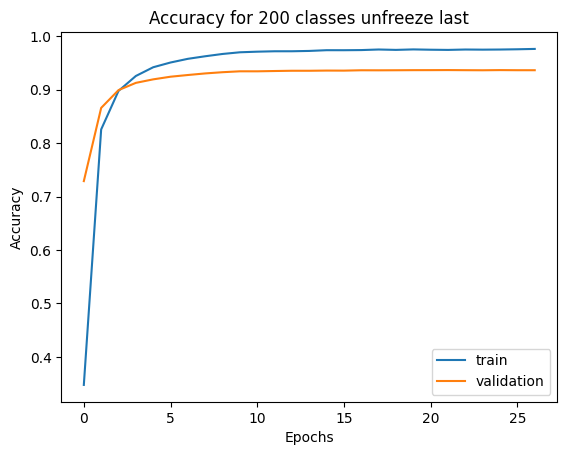

In [64]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes unfreeze last", "Accuracy")

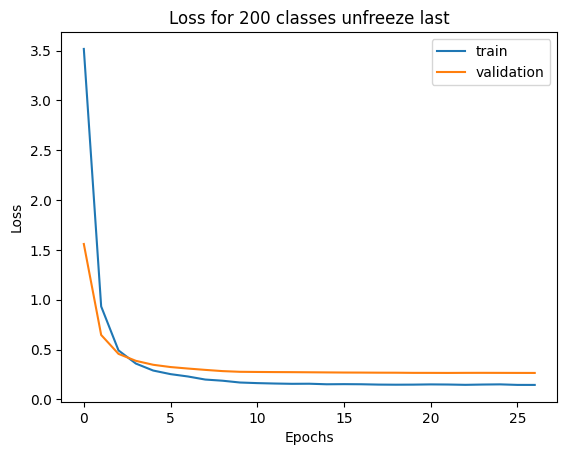

In [65]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes unfreeze last", "Loss")

In [66]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_200_stuff", train_test_indices_path="/kaggle/working/train_test_indices_200.pkl")

/tmp/ipykernel_30/994810850.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.19748809933662415 accuracy 0.9583163261413574


U+5375 1.0 59.0
U+53CA 1.0 77.0
U+5730 1.0 55.0
U+5DDD 1.0 59.0
U+5F15 1.0 95.0
U+60AA 1.0 48.0
U+6216 1.0 60.0
U+660E 1.0 60.0
U+6851 1.0 88.0
U+6E6F 1.0 55.0
U+6F2C 1.0 52.0
U+706B 1.0 61.0
U+7530 1.0 59.0
U+7537 1.0 70.0
U+76BF 1.0 51.0
U+7A0B 1.0 73.0
U+7A2E 1.0 73.0
U+7B2C 1.0 61.0
U+80FD 1.0 53.0
U+8349 1.0 63.0
U+897F 1.0 96.0
U+8A9E 1.0 61.0
U+8C46 1.0 56.0
U+8D8A 1.0 55.0
U+9063 1.0 47.0
U+95A2 1.0 49.0
U+4E00 0.9962264150943396 530.0
U+8695 0.9935897435897436 156.0
U+6C5F 0.9915966386554622 119.0
U+5C45 0.991304347826087 115.0
U+6238 0.9911504424778761 113.0
U+5473 0.9897959183673469 98.0
U+4ED8 0.9883720930232558 86.0
U+6C41 0.9873417721518988 158.0
U+7528 0.9873417721518988 79.0
U+4E03 0.987012987012987 77.0
U+795E 0.9868421052631579 76.0
U+6210 0.9863013698630136 73.0
U+716E 0.9863013698630136 73.0
U+571F 0.9857142857142858 70.0
U+4ED5 0.9855072463768116 138.0
U+7406 0.9855072463768116 69.0
U+5869 0.9850746268656716 67.0
U+79C1 0.9846153846153847 65.0
U+9152 0.984615384615

In [ ]:
testing_models_metrics(class_amount=200, model_suff_path="/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_200_stuff", train_test_indices_path="/kaggle/working/train_test_indices_200.pkl")

# Pretrained CASIA-HWDB unfreeze last, 300 classes logic

In [67]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_300_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 300, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

stuff = getting_stuff_for_training(classamount=300, pathes=pathes, pretrained=True)

/tmp/ipykernel_30/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [68]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_last_300_stuff", model_name="300 classes unfreeze last", freeze_base=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:39<00:00,  2.48s/it]

  1%|          | 1/100 [01:05<1:48:21, 65.68s/it]

Epoch: 1
Train: loss 3.585634469985962 accuracy 0.37106412649154663
Validation: loss 1.5547245740890503 accuracy 0.7426854372024536



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.94s/it]

  2%|▏         | 2/100 [01:51<1:28:02, 53.91s/it]

Epoch: 2
Train: loss 0.8840012550354004 accuracy 0.841234028339386
Validation: loss 0.6879853010177612 accuracy 0.855494499206543



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:30<00:00,  1.90s/it]

  3%|▎         | 3/100 [02:36<1:20:35, 49.85s/it]

Epoch: 3
Train: loss 0.4762006402015686 accuracy 0.903623104095459
Validation: loss 0.5033683180809021 accuracy 0.8896097540855408



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:29<00:00,  1.87s/it]

  4%|▍         | 4/100 [03:20<1:16:12, 47.63s/it]

Epoch: 4
Train: loss 0.3545067608356476 accuracy 0.9283684492111206
Validation: loss 0.4348147213459015 accuracy 0.9021872282028198



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.79s/it]

  5%|▌         | 5/100 [04:04<1:13:09, 46.20s/it]

Epoch: 5
Train: loss 0.28439122438430786 accuracy 0.9459503889083862
Validation: loss 0.39882633090019226 accuracy 0.9101556539535522



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:27<00:00,  1.75s/it]

  6%|▌         | 6/100 [04:46<1:10:15, 44.85s/it]

Epoch: 6
Train: loss 0.24584610760211945 accuracy 0.9554507732391357
Validation: loss 0.36982378363609314 accuracy 0.915580153465271



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:29<00:00,  1.83s/it]

  7%|▋         | 7/100 [05:29<1:08:35, 44.25s/it]

Epoch: 7
Train: loss 0.21690407395362854 accuracy 0.9615601301193237
Validation: loss 0.3497557044029236 accuracy 0.9198833703994751



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.81s/it]

  8%|▊         | 8/100 [06:12<1:07:24, 43.96s/it]

Epoch: 8
Train: loss 0.1945115178823471 accuracy 0.9662539958953857
Validation: loss 0.33632156252861023 accuracy 0.9213595390319824



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.75s/it]

  9%|▉         | 9/100 [06:55<1:06:08, 43.61s/it]

Epoch: 9
Train: loss 0.17399294674396515 accuracy 0.9716253280639648
Validation: loss 0.3254603445529938 accuracy 0.9243466258049011



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.80s/it]

 10%|█         | 10/100 [07:38<1:05:00, 43.34s/it]

Epoch: 10
Train: loss 0.15766641497612 accuracy 0.9734763503074646
Validation: loss 0.3150080442428589 accuracy 0.9263490438461304



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:29<00:00,  1.84s/it]

 11%|█         | 11/100 [08:22<1:04:25, 43.43s/it]

Epoch: 11
Train: loss 0.15014149248600006 accuracy 0.9758919477462769
Validation: loss 0.31364747881889343 accuracy 0.9265931844711304



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.78s/it]

 12%|█▏        | 12/100 [09:05<1:03:46, 43.48s/it]

Epoch: 12
Train: loss 0.147391214966774 accuracy 0.9770551323890686
Validation: loss 0.3120933771133423 accuracy 0.926689624786377



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.77s/it]

 13%|█▎        | 13/100 [09:48<1:02:35, 43.16s/it]

Epoch: 13
Train: loss 0.14533911645412445 accuracy 0.9775810837745667
Validation: loss 0.3106776773929596 accuracy 0.9269953370094299



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:29<00:00,  1.84s/it]

 14%|█▍        | 14/100 [10:31<1:02:07, 43.34s/it]

Epoch: 14
Train: loss 0.14083220064640045 accuracy 0.9777441620826721
Validation: loss 0.3096573054790497 accuracy 0.9272938370704651



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.79s/it]

 15%|█▌        | 15/100 [11:15<1:01:28, 43.39s/it]

Epoch: 15
Train: loss 0.14353957772254944 accuracy 0.9775397777557373
Validation: loss 0.3087630271911621 accuracy 0.9275769591331482



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.75s/it]

 16%|█▌        | 16/100 [11:58<1:00:43, 43.38s/it]

Epoch: 16
Train: loss 0.1395852118730545 accuracy 0.9781902432441711
Validation: loss 0.3074450194835663 accuracy 0.9278713464736938



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:29<00:00,  1.85s/it]

 17%|█▋        | 17/100 [12:43<1:00:28, 43.71s/it]

Epoch: 17
Train: loss 0.13996969163417816 accuracy 0.9788169264793396
Validation: loss 0.30646055936813354 accuracy 0.9282006621360779



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:31<00:00,  1.98s/it]

 18%|█▊        | 18/100 [13:29<1:00:47, 44.49s/it]

Epoch: 18
Train: loss 0.13642381131649017 accuracy 0.9796080589294434
Validation: loss 0.30577728152275085 accuracy 0.9285258054733276



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:29<00:00,  1.82s/it]

 19%|█▉        | 19/100 [14:13<59:44, 44.25s/it]  

Epoch: 19
Train: loss 0.132332906126976 accuracy 0.9804273843765259
Validation: loss 0.30513840913772583 accuracy 0.9283207058906555



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.78s/it]

 20%|██        | 20/100 [14:56<58:38, 43.98s/it]

Epoch: 20
Train: loss 0.13179145753383636 accuracy 0.9806293249130249
Validation: loss 0.30421996116638184 accuracy 0.9280959963798523



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:28<00:00,  1.78s/it]

 21%|██        | 21/100 [15:38<57:16, 43.51s/it]

Epoch: 21
Train: loss 0.1339079737663269 accuracy 0.9808253049850464
Validation: loss 0.30442970991134644 accuracy 0.9282006621360779



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:29<00:00,  1.83s/it]

 22%|██▏       | 22/100 [16:22<56:33, 43.50s/it]

Epoch: 22
Train: loss 0.13151982426643372 accuracy 0.9803088903427124
Validation: loss 0.30424657464027405 accuracy 0.9281309247016907



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:27<00:00,  1.75s/it]

 22%|██▏       | 22/100 [17:05<1:00:36, 46.62s/it]

Epoch: 23
Train: loss 0.1341928094625473 accuracy 0.9801762104034424
Validation: loss 0.30386075377464294 accuracy 0.9283555746078491
Best validation accuracy for 300 classes unfreeze last: 0.9285258054733276 Epoch 18


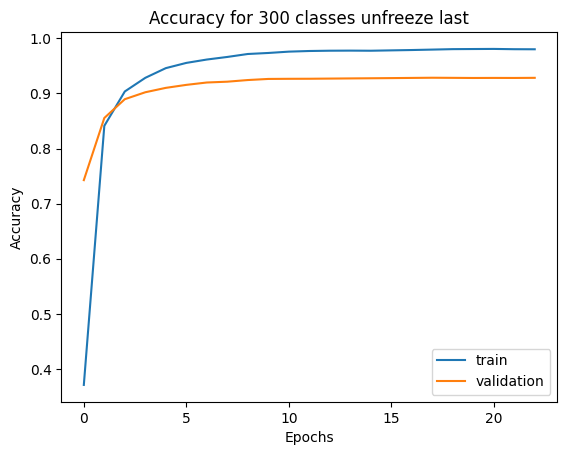

In [69]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes unfreeze last", "Accuracy")

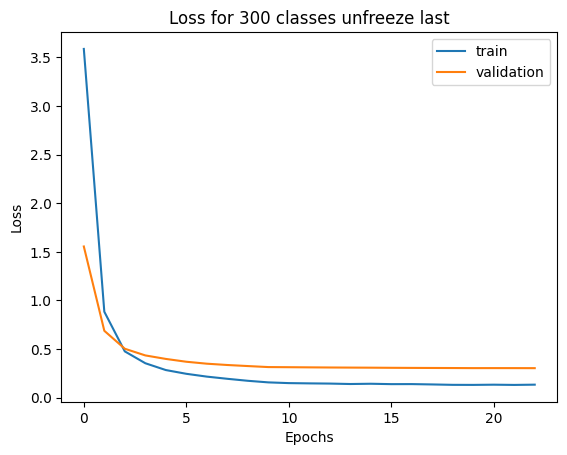

In [70]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes unfreeze last", "Loss")

In [71]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_30/994810850.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:1

Test: loss 0.21906259655952454 accuracy 0.9553671479225159


U+4E5D 1.0 50.0
U+4ECB 1.0 40.0
U+4EE3 1.0 40.0
U+4F46 1.0 39.0
U+4F8D 1.0 48.0
U+5148 1.0 49.0
U+5150 1.0 34.0
U+5207 1.0 94.0
U+521D 1.0 46.0
U+52A0 1.0 48.0
U+52E2 1.0 36.0
U+5347 1.0 35.0
U+53CA 1.0 77.0
U+547C 1.0 52.0
U+547D 1.0 32.0
U+55B0 1.0 32.0
U+564C 1.0 40.0
U+5B9F 1.0 40.0
U+5BBF 1.0 39.0
U+5C11 1.0 61.0
U+5C3E 1.0 39.0
U+5DDD 1.0 59.0
U+5EA6 1.0 50.0
U+5F35 1.0 33.0
U+5F37 1.0 59.0
U+5F7C 1.0 43.0
U+60C5 1.0 38.0
U+6216 1.0 60.0
U+623F 1.0 43.0
U+6298 1.0 32.0
U+6301 1.0 32.0
U+6368 1.0 37.0
U+66FF 1.0 34.0
U+6B63 1.0 37.0
U+6BCD 1.0 33.0
U+6CB9 1.0 40.0
U+6D25 1.0 35.0
U+6D77 1.0 52.0
U+6E6F 1.0 55.0
U+7136 1.0 39.0
U+713C 1.0 63.0
U+7236 1.0 36.0
U+7406 1.0 69.0
U+753A 1.0 37.0
U+757F 1.0 36.0
U+795E 1.0 76.0
U+79C1 1.0 65.0
U+7AF9 1.0 46.0
U+7B2C 1.0 61.0
U+7C89 1.0 44.0
U+7CF8 1.0 32.0
U+7D19 1.0 79.0
U+7D30 1.0 34.0
U+7DCF 1.0 55.0
U+7FA9 1.0 43.0
U+80FD 1.0 53.0
U+8179 1.0 37.0
U+81EA 1.0 53.0
U+8584 1.0 41.0
U+89AA 1.0 40.0
U+89D2 1.0 35.0
U+8D64 1.0 33.0
U+8D77 1

In [41]:
testing_models_metrics(class_amount=300, model_suff_path="/kaggle/input/kkanji/stuff_for_models/model_augmented_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_30/127551886.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:14

Test: loss 0.058888450264930725 accuracy 0.9868091344833374


Per-class accuracy:
U+4E00: 1.00 
U+4E03: 1.00 
U+4E09: 1.00 
U+4E5D: 1.00 
U+4E91: 1.00 
U+4EAC: 1.00 
U+4ED5: 1.00 
U+4F0A: 1.00 
U+4F55: 1.00 
U+4F5C: 1.00 
U+4FE1: 1.00 
U+5148: 1.00 
U+5150: 1.00 
U+5171: 1.00 
U+5185: 1.00 
U+5225: 1.00 
U+5341: 1.00 
U+5357: 1.00 
U+5375: 1.00 
U+541B: 1.00 
U+5473: 1.00 
U+547C: 1.00 
U+56DB: 1.00 
U+5869: 1.00 
U+5965: 1.00 
U+5B9F: 1.00 
U+5BBF: 1.00 
U+5BF8: 1.00 
U+5C3E: 1.00 
U+5C45: 1.00 
U+5DDD: 1.00 
U+5DE6: 1.00 
U+5E73: 1.00 
U+5EA7: 1.00 
U+5F15: 1.00 
U+5F35: 1.00 
U+5F62: 1.00 
U+5F7C: 1.00 
U+601D: 1.00 
U+60AA: 1.00 
U+60C5: 1.00 
U+610F: 1.00 
U+61F8: 1.00 
U+6211: 1.00 
U+6238: 1.00 
U+623F: 1.00 
U+6268: 1.00 
U+6368: 1.00 
U+6545: 1.00 
U+6587: 1.00 
U+6599: 1.00 
U+660E: 1.00 
U+6642: 1.00 
U+66F8: 1.00 
U+66FF: 1.00 
U+671D: 1.00 
U+6728: 1.00 
U+6771: 1.00 
U+6885: 1.00 
U+6B63: 1.00 
U+6C17: 1.00 
U+6C41: 1.00 
U+6C5F: 1.00 
U+6CB9: 1.00 
U+6CBB: 1.00 
U+6D77: 1.00 
U+6E6F: 1.00 
U+713C: 1.00 
U+7236: 1.00 
U+7389: 1.00 


# CASIA-HWDB logic

In [ ]:
# Getting stuff for training
pathes = create_pathes_vocabulary("/kaggle/input/casia-hwdb/model_CASIA_HWDB_stuff/model_CASIA_HWDB_stuff")

trainloader, testloader, _ = get_dataloaders_CASIA_HWDB(batch_size=4096)

stuff = getting_stuff_for_training(classamount=6764, pathes=pathes)

/tmp/ipykernel_30/4290371203.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.  model.load_state_dict(torch.load(pathes["model"]))/tmp/ipykernel_30/4290371203.py:69: Future

In [ ]:
# Training loop 

train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_CASIA_HWDB_stuff", model_name="CASIA_HWDB")

  0%|          | 0/100 [00:00<?, ?it/s]  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:23<4:38:25, 23.76s/it]  0%|          | 2/704 [00:24<2:01:36, 10.39s/it]  0%|          | 3/704 [00:25<1:11:31,  6.12s/it]  1%|          | 4/704 [00:26<48:01,  4.12s/it]    1%|          | 5/704 [00:44<1:42:55,  8.83s/it]  1%|          | 6/704 [00:45<1:11:56,  6.18s/it]  1%|          | 7/704 [00:46<52:17,  4.50s/it]    1%|          | 8/704 [00:47<39:25,  3.40s/it]  1%|▏         | 9/704 [01:04<1:28:50,  7.67s/it]  1%|▏         | 10/704 [01:05<1:05:01,  5.62s/it]  2%|▏         | 11/704 [01:06<48:43,  4.22s/it]    2%|▏         | 12/704 [01:07<37:30,  3.25s/it]  2%|▏         | 13/704 [01:26<1:32:17,  8.01s/it]  2%|▏         | 14/704 [01:27<1:07:55,  5.91s/it]  2%|▏         | 15/704 [01:28<50:58,  4.44s/it]    2%|▏         | 16/704 [01:29<39:10,  3.42s/it]  2%|▏         | 17/704 [01:46<1:27:31,  7.64s/it]  3%|▎         | 18/704 [01:47<1:04:42,  5.66s/it]  3%|▎         | 19/704 [01:49<48:45,  4.27s/it]    3%|▎         | 20/704 [01:50<37:37,  3.30s/it]  3%|▎         | 

Batch is processing: 100

 14%|█▍        | 101/704 [08:46<1:14:54,  7.45s/it] 14%|█▍        | 102/704 [08:47<55:29,  5.53s/it]   15%|█▍        | 103/704 [08:48<41:53,  4.18s/it] 15%|█▍        | 104/704 [08:49<32:23,  3.24s/it] 15%|█▍        | 105/704 [09:06<1:12:47,  7.29s/it] 15%|█▌        | 106/704 [09:07<53:58,  5.42s/it]   15%|█▌        | 107/704 [09:08<40:48,  4.10s/it] 15%|█▌        | 108/704 [09:09<31:37,  3.18s/it] 15%|█▌        | 109/704 [09:25<1:11:12,  7.18s/it] 16%|█▌        | 110/704 [09:26<52:50,  5.34s/it]   16%|█▌        | 111/704 [09:28<40:00,  4.05s/it] 16%|█▌        | 112/704 [09:29<31:01,  3.15s/it] 16%|█▌        | 113/704 [09:45<1:09:29,  7.05s/it] 16%|█▌        | 114/704 [09:46<51:37,  5.25s/it]   16%|█▋        | 115/704 [09:47<39:07,  3.99s/it] 16%|█▋        | 116/704 [09:48<30:24,  3.10s/it] 17%|█▋        | 117/704 [10:03<1:06:06,  6.76s/it] 17%|█▋        | 118/704 [10:04<49:14,  5.04s/it]   17%|█▋        | 119/704 [10:05<37:26,  3.84s/it] 17%|█▋        | 120/704 [10:06<29:12,  3.00s/it]

Batch is processing: 200

 29%|██▊       | 201/704 [16:45<56:20,  6.72s/it] 29%|██▊       | 202/704 [16:46<41:58,  5.02s/it] 29%|██▉       | 203/704 [16:47<31:54,  3.82s/it] 29%|██▉       | 204/704 [16:48<24:53,  2.99s/it] 29%|██▉       | 205/704 [17:03<55:11,  6.64s/it] 29%|██▉       | 206/704 [17:04<41:08,  4.96s/it] 29%|██▉       | 207/704 [17:05<31:19,  3.78s/it] 30%|██▉       | 208/704 [17:06<24:27,  2.96s/it] 30%|██▉       | 209/704 [17:22<55:52,  6.77s/it] 30%|██▉       | 210/704 [17:23<41:35,  5.05s/it] 30%|██▉       | 211/704 [17:24<31:37,  3.85s/it] 30%|███       | 212/704 [17:25<24:38,  3.00s/it] 30%|███       | 213/704 [17:41<55:59,  6.84s/it] 30%|███       | 214/704 [17:42<41:39,  5.10s/it] 31%|███       | 215/704 [17:43<31:38,  3.88s/it] 31%|███       | 216/704 [17:44<24:38,  3.03s/it] 31%|███       | 217/704 [17:59<52:32,  6.47s/it] 31%|███       | 218/704 [18:00<39:13,  4.84s/it] 31%|███       | 219/704 [18:01<29:55,  3.70s/it] 31%|███▏      | 220/704 [18:02<23:24,  2.90s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [24:21<43:20,  6.45s/it] 43%|████▎     | 302/704 [24:22<32:20,  4.83s/it] 43%|████▎     | 303/704 [24:23<24:40,  3.69s/it] 43%|████▎     | 304/704 [24:24<19:18,  2.90s/it] 43%|████▎     | 305/704 [24:39<42:46,  6.43s/it] 43%|████▎     | 306/704 [24:40<31:55,  4.81s/it] 44%|████▎     | 307/704 [24:41<24:21,  3.68s/it] 44%|████▍     | 308/704 [24:42<19:03,  2.89s/it] 44%|████▍     | 309/704 [24:56<41:05,  6.24s/it] 44%|████▍     | 310/704 [24:57<30:44,  4.68s/it] 44%|████▍     | 311/704 [24:58<23:29,  3.59s/it] 44%|████▍     | 312/704 [24:59<18:26,  2.82s/it] 44%|████▍     | 313/704 [25:13<40:23,  6.20s/it] 45%|████▍     | 314/704 [25:14<30:13,  4.65s/it] 45%|████▍     | 315/704 [25:16<23:07,  3.57s/it] 45%|████▍     | 316/704 [25:17<18:09,  2.81s/it] 45%|████▌     | 317/704 [25:32<41:59,  6.51s/it] 45%|████▌     | 318/704 [25:33<31:19,  4.87s/it] 45%|████▌     | 319/704 [25:34<23:51,  3.72s/it] 45%|████▌     | 320/704 [25:35<18:39,  2.91s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [31:36<32:16,  6.39s/it] 57%|█████▋    | 402/704 [31:37<24:05,  4.79s/it] 57%|█████▋    | 403/704 [31:38<18:21,  3.66s/it] 57%|█████▋    | 404/704 [31:39<14:22,  2.88s/it] 58%|█████▊    | 405/704 [31:52<30:24,  6.10s/it] 58%|█████▊    | 406/704 [31:53<22:45,  4.58s/it] 58%|█████▊    | 407/704 [31:54<17:25,  3.52s/it] 58%|█████▊    | 408/704 [31:55<13:41,  2.78s/it] 58%|█████▊    | 409/704 [32:09<29:54,  6.08s/it] 58%|█████▊    | 410/704 [32:10<22:23,  4.57s/it] 58%|█████▊    | 411/704 [32:11<17:08,  3.51s/it] 59%|█████▊    | 412/704 [32:12<13:28,  2.77s/it] 59%|█████▊    | 413/704 [32:27<30:18,  6.25s/it] 59%|█████▉    | 414/704 [32:28<22:38,  4.69s/it] 59%|█████▉    | 415/704 [32:29<17:17,  3.59s/it] 59%|█████▉    | 416/704 [32:30<13:33,  2.83s/it] 59%|█████▉    | 417/704 [32:43<28:35,  5.98s/it] 59%|█████▉    | 418/704 [32:44<21:26,  4.50s/it] 60%|█████▉    | 419/704 [32:45<16:25,  3.46s/it] 60%|█████▉    | 420/704 [32:46<12:56,  2.73s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [38:39<20:25,  6.04s/it] 71%|███████▏  | 502/704 [38:40<15:16,  4.54s/it] 71%|███████▏  | 503/704 [38:41<11:41,  3.49s/it] 72%|███████▏  | 504/704 [38:43<09:10,  2.75s/it] 72%|███████▏  | 505/704 [38:56<19:18,  5.82s/it] 72%|███████▏  | 506/704 [38:57<14:28,  4.39s/it] 72%|███████▏  | 507/704 [38:58<11:06,  3.38s/it] 72%|███████▏  | 508/704 [38:59<08:45,  2.68s/it] 72%|███████▏  | 509/704 [39:12<19:06,  5.88s/it] 72%|███████▏  | 510/704 [39:13<14:19,  4.43s/it] 73%|███████▎  | 511/704 [39:14<10:58,  3.41s/it] 73%|███████▎  | 512/704 [39:15<08:38,  2.70s/it] 73%|███████▎  | 513/704 [39:29<19:27,  6.11s/it] 73%|███████▎  | 514/704 [39:30<14:31,  4.59s/it] 73%|███████▎  | 515/704 [39:31<11:06,  3.52s/it] 73%|███████▎  | 516/704 [39:32<08:42,  2.78s/it] 73%|███████▎  | 517/704 [39:45<18:18,  5.87s/it] 74%|███████▎  | 518/704 [39:46<13:42,  4.42s/it] 74%|███████▎  | 519/704 [39:47<10:30,  3.41s/it] 74%|███████▍  | 520/704 [39:48<08:16,  2.70s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [45:29<10:02,  5.85s/it] 86%|████████▌ | 602/704 [45:30<07:29,  4.41s/it] 86%|████████▌ | 603/704 [45:31<05:43,  3.40s/it] 86%|████████▌ | 604/704 [45:32<04:28,  2.69s/it] 86%|████████▌ | 605/704 [45:45<09:41,  5.87s/it] 86%|████████▌ | 606/704 [45:46<07:13,  4.42s/it] 86%|████████▌ | 607/704 [45:47<05:30,  3.41s/it] 86%|████████▋ | 608/704 [45:48<04:18,  2.70s/it] 87%|████████▋ | 609/704 [46:02<09:22,  5.92s/it] 87%|████████▋ | 610/704 [46:03<06:58,  4.45s/it] 87%|████████▋ | 611/704 [46:04<05:18,  3.43s/it] 87%|████████▋ | 612/704 [46:05<04:09,  2.71s/it] 87%|████████▋ | 613/704 [46:18<08:42,  5.74s/it] 87%|████████▋ | 614/704 [46:19<06:29,  4.33s/it] 87%|████████▋ | 615/704 [46:20<04:57,  3.34s/it] 88%|████████▊ | 616/704 [46:21<03:53,  2.65s/it] 88%|████████▊ | 617/704 [46:35<08:41,  5.99s/it] 88%|████████▊ | 618/704 [46:36<06:27,  4.51s/it] 88%|████████▊ | 619/704 [46:37<04:54,  3.47s/it] 88%|████████▊ | 620/704 [46:38<03:49,  2.74s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [52:09<00:15,  5.23s/it]100%|█████████▉| 702/704 [52:10<00:07,  3.97s/it]100%|██████████| 704/704 [52:11<00:00,  4.45s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:25<1:14:32, 25.56s/it]  1%|          | 2/176 [00:26<31:21, 10.82s/it]    2%|▏         | 3/176 [00:26<17:19,  6.01s/it]  2%|▏         | 4/176 [00:26<10:44,  3.75s/it]  3%|▎         | 5/176 [00:49<30:09, 10.58s/it]  3%|▎         | 6/176 [00:49<20:07,  7.10s/it]  4%|▍         | 7/176 [00:49<13:43,  4.87s/it]  5%|▍         | 8/176 [00:50<09:33,  3.41s/it]  5%|▌         | 9/176 [01:14<27:19,  9.81s/it]  6%|▌         | 10/176 [01:14<19:10,  6.93s/it]  6%|▋         | 11/176 [01:14<13:28,  4.90s/it]  7%|▋         | 12/176 [01:15<09:33,  3.50s/it]  7%|▋         | 13/176 [01:38<26:10,  9.64s/it]  8%|▊         | 14/176 [01:39<18:38,  6.91s/it]  9%|▊         | 15/176 [01:39<13:10,  4.91s/it]  9%|▉         | 16/176 [01:40<09:23,  3.52s/it] 10%|▉         | 17/176 [02:03<25:31,  9.63s/it] 10

Epoch: 12Train: loss 0.024677976965904236 accuracy 0.9938468933105469Validation: loss 0.3320419192314148 accuracy 0.932234525680542

  1%|          | 1/100 [1:11:03<117:14:14, 4263.18s/it]  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:19<3:49:54, 19.62s/it]  0%|          | 2/704 [00:20<1:41:39,  8.69s/it]  0%|          | 3/704 [00:21<1:00:41,  5.19s/it]  1%|          | 4/704 [00:22<41:28,  3.55s/it]    1%|          | 5/704 [00:37<1:29:42,  7.70s/it]  1%|          | 6/704 [00:38<1:03:13,  5.43s/it]  1%|          | 7/704 [00:39<46:25,  4.00s/it]    1%|          | 8/704 [00:40<35:26,  3.05s/it]  1%|▏         | 9/704 [00:55<1:17:55,  6.73s/it]  1%|▏         | 10/704 [00:56<57:29,  4.97s/it]   2%|▏         | 11/704 [00:57<43:30,  3.77s/it]  2%|▏         | 12/704 [00:58<33:52,  2.94s/it]  2%|▏         | 13/704 [01:13<1:14:45,  6.49s/it]  2%|▏         | 14/704 [01:14<55:42,  4.84s/it]    2%|▏         | 15/704 [01:15<42:27,  3.70s/it]  2%|▏         | 16/704 [01:16<33:12,  2.90s/it]  2%|▏         | 17/704 [01:31<1:14:01,  6.47s/it]  3%|▎         | 18/704 [01:32<55:16,  4.83s/it]    3%|▎         | 19/704 [01:33<42:10,  3.69s/it]  3%|▎         | 20/704 [01:34<33:02,  2.90s/it]  3%|▎         | 21/704 

Batch is processing: 100

 14%|█▍        | 101/704 [07:26<1:02:15,  6.20s/it] 14%|█▍        | 102/704 [07:27<46:37,  4.65s/it]   15%|█▍        | 103/704 [07:28<35:42,  3.56s/it] 15%|█▍        | 104/704 [07:29<28:03,  2.81s/it] 15%|█▍        | 105/704 [07:43<1:00:17,  6.04s/it] 15%|█▌        | 106/704 [07:44<45:13,  4.54s/it]   15%|█▌        | 107/704 [07:45<34:42,  3.49s/it] 15%|█▌        | 108/704 [07:46<27:20,  2.75s/it] 15%|█▌        | 109/704 [07:59<57:16,  5.78s/it] 16%|█▌        | 110/704 [08:00<43:06,  4.35s/it] 16%|█▌        | 111/704 [08:01<33:11,  3.36s/it] 16%|█▌        | 112/704 [08:02<26:17,  2.66s/it] 16%|█▌        | 113/704 [08:15<57:40,  5.85s/it] 16%|█▌        | 114/704 [08:16<43:21,  4.41s/it] 16%|█▋        | 115/704 [08:17<33:21,  3.40s/it] 16%|█▋        | 116/704 [08:18<26:21,  2.69s/it] 17%|█▋        | 117/704 [08:32<59:22,  6.07s/it] 17%|█▋        | 118/704 [08:33<44:32,  4.56s/it] 17%|█▋        | 119/704 [08:34<34:09,  3.50s/it] 17%|█▋        | 120/704 [08:35<26:54,  2.76s/it] 17%|█▋     

Batch is processing: 200

 29%|██▊       | 201/704 [14:22<52:02,  6.21s/it] 29%|██▊       | 202/704 [14:23<38:58,  4.66s/it] 29%|██▉       | 203/704 [14:24<29:49,  3.57s/it] 29%|██▉       | 204/704 [14:25<23:25,  2.81s/it] 29%|██▉       | 205/704 [14:40<53:24,  6.42s/it] 29%|██▉       | 206/704 [14:41<39:54,  4.81s/it] 29%|██▉       | 207/704 [14:42<30:26,  3.68s/it] 30%|██▉       | 208/704 [14:43<23:50,  2.88s/it] 30%|██▉       | 209/704 [14:58<52:18,  6.34s/it] 30%|██▉       | 210/704 [14:59<39:06,  4.75s/it] 30%|██▉       | 211/704 [15:00<29:52,  3.64s/it] 30%|███       | 212/704 [15:01<23:25,  2.86s/it] 30%|███       | 213/704 [15:15<51:13,  6.26s/it] 30%|███       | 214/704 [15:16<38:20,  4.69s/it] 31%|███       | 215/704 [15:17<29:18,  3.60s/it] 31%|███       | 216/704 [15:18<23:00,  2.83s/it] 31%|███       | 217/704 [15:34<53:33,  6.60s/it] 31%|███       | 218/704 [15:35<39:56,  4.93s/it] 31%|███       | 219/704 [15:36<30:24,  3.76s/it] 31%|███▏      | 220/704 [15:37<23:45,  2.95s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [21:30<42:20,  6.30s/it] 43%|████▎     | 302/704 [21:31<31:39,  4.73s/it] 43%|████▎     | 303/704 [21:32<24:11,  3.62s/it] 43%|████▎     | 304/704 [21:33<18:57,  2.84s/it] 43%|████▎     | 305/704 [21:46<39:46,  5.98s/it] 43%|████▎     | 306/704 [21:47<29:51,  4.50s/it] 44%|████▎     | 307/704 [21:48<22:53,  3.46s/it] 44%|████▍     | 308/704 [21:49<18:02,  2.73s/it] 44%|████▍     | 309/704 [22:03<39:34,  6.01s/it] 44%|████▍     | 310/704 [22:04<29:40,  4.52s/it] 44%|████▍     | 311/704 [22:05<22:45,  3.47s/it] 44%|████▍     | 312/704 [22:06<17:55,  2.74s/it] 44%|████▍     | 313/704 [22:21<41:07,  6.31s/it] 45%|████▍     | 314/704 [22:22<30:44,  4.73s/it] 45%|████▍     | 315/704 [22:23<23:28,  3.62s/it] 45%|████▍     | 316/704 [22:24<18:24,  2.85s/it] 45%|████▌     | 317/704 [22:38<40:56,  6.35s/it] 45%|████▌     | 318/704 [22:39<30:35,  4.75s/it] 45%|████▌     | 319/704 [22:41<23:21,  3.64s/it] 45%|████▌     | 320/704 [22:42<18:17,  2.86s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [28:35<30:33,  6.05s/it] 57%|█████▋    | 402/704 [28:36<22:53,  4.55s/it] 57%|█████▋    | 403/704 [28:37<17:31,  3.49s/it] 57%|█████▋    | 404/704 [28:38<13:47,  2.76s/it] 58%|█████▊    | 405/704 [28:51<29:01,  5.82s/it] 58%|█████▊    | 406/704 [28:52<21:47,  4.39s/it] 58%|█████▊    | 407/704 [28:53<16:44,  3.38s/it] 58%|█████▊    | 408/704 [28:54<13:13,  2.68s/it] 58%|█████▊    | 409/704 [29:07<28:01,  5.70s/it] 58%|█████▊    | 410/704 [29:08<21:04,  4.30s/it] 58%|█████▊    | 411/704 [29:09<16:13,  3.32s/it] 59%|█████▊    | 412/704 [29:10<12:49,  2.64s/it] 59%|█████▊    | 413/704 [29:23<28:13,  5.82s/it] 59%|█████▉    | 414/704 [29:24<21:11,  4.39s/it] 59%|█████▉    | 415/704 [29:25<16:17,  3.38s/it] 59%|█████▉    | 416/704 [29:26<12:51,  2.68s/it] 59%|█████▉    | 417/704 [29:40<28:04,  5.87s/it] 59%|█████▉    | 418/704 [29:41<21:04,  4.42s/it] 60%|█████▉    | 419/704 [29:42<16:10,  3.41s/it] 60%|█████▉    | 420/704 [29:43<12:45,  2.70s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [35:31<22:07,  6.54s/it] 71%|███████▏  | 502/704 [35:32<16:27,  4.89s/it] 71%|███████▏  | 503/704 [35:33<12:30,  3.73s/it] 72%|███████▏  | 504/704 [35:34<09:45,  2.93s/it] 72%|███████▏  | 505/704 [35:49<20:52,  6.29s/it] 72%|███████▏  | 506/704 [35:50<15:33,  4.72s/it] 72%|███████▏  | 507/704 [35:51<11:51,  3.61s/it] 72%|███████▏  | 508/704 [35:52<09:16,  2.84s/it] 72%|███████▏  | 509/704 [36:06<20:36,  6.34s/it] 72%|███████▏  | 510/704 [36:07<15:22,  4.75s/it] 73%|███████▎  | 511/704 [36:08<11:42,  3.64s/it] 73%|███████▎  | 512/704 [36:09<09:08,  2.86s/it] 73%|███████▎  | 513/704 [36:25<21:07,  6.64s/it] 73%|███████▎  | 514/704 [36:26<15:41,  4.96s/it] 73%|███████▎  | 515/704 [36:27<11:54,  3.78s/it] 73%|███████▎  | 516/704 [36:28<09:16,  2.96s/it] 73%|███████▎  | 517/704 [36:42<19:34,  6.28s/it] 74%|███████▎  | 518/704 [36:43<14:35,  4.71s/it] 74%|███████▎  | 519/704 [36:44<11:07,  3.61s/it] 74%|███████▍  | 520/704 [36:45<08:42,  2.84s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [42:28<10:18,  6.01s/it] 86%|████████▌ | 602/704 [42:29<07:40,  4.52s/it] 86%|████████▌ | 603/704 [42:30<05:50,  3.47s/it] 86%|████████▌ | 604/704 [42:31<04:34,  2.75s/it] 86%|████████▌ | 605/704 [42:45<09:52,  5.98s/it] 86%|████████▌ | 606/704 [42:46<07:21,  4.50s/it] 86%|████████▌ | 607/704 [42:47<05:35,  3.46s/it] 86%|████████▋ | 608/704 [42:48<04:22,  2.74s/it] 87%|████████▋ | 609/704 [43:00<08:55,  5.64s/it] 87%|████████▋ | 610/704 [43:01<06:40,  4.26s/it] 87%|████████▋ | 611/704 [43:02<05:06,  3.29s/it] 87%|████████▋ | 612/704 [43:03<04:00,  2.62s/it] 87%|████████▋ | 613/704 [43:17<08:54,  5.88s/it] 87%|████████▋ | 614/704 [43:18<06:38,  4.42s/it] 87%|████████▋ | 615/704 [43:19<05:03,  3.41s/it] 88%|████████▊ | 616/704 [43:20<03:57,  2.70s/it] 88%|████████▊ | 617/704 [43:33<08:35,  5.92s/it] 88%|████████▊ | 618/704 [43:34<06:23,  4.46s/it] 88%|████████▊ | 619/704 [43:35<04:51,  3.43s/it] 88%|████████▊ | 620/704 [43:36<03:47,  2.71s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [49:07<00:15,  5.31s/it]100%|█████████▉| 702/704 [49:08<00:08,  4.03s/it]100%|██████████| 704/704 [49:10<00:00,  4.19s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:12<35:00, 12.00s/it]  1%|          | 2/176 [00:12<14:52,  5.13s/it]  2%|▏         | 3/176 [00:12<08:25,  2.92s/it]  2%|▏         | 4/176 [00:12<05:23,  1.88s/it]  3%|▎         | 5/176 [00:23<14:19,  5.02s/it]  3%|▎         | 6/176 [00:23<09:40,  3.42s/it]  4%|▍         | 7/176 [00:24<06:44,  2.39s/it]  5%|▍         | 8/176 [00:24<04:49,  1.72s/it]  5%|▌         | 9/176 [00:34<12:12,  4.39s/it]  6%|▌         | 10/176 [00:35<08:43,  3.16s/it]  6%|▋         | 11/176 [00:35<06:16,  2.28s/it]  7%|▋         | 12/176 [00:35<04:34,  1.67s/it]  7%|▋         | 13/176 [00:46<11:49,  4.35s/it]  8%|▊         | 14/176 [00:46<08:53,  3.29s/it]  9%|▊         | 15/176 [00:47<06:24,  2.39s/it]  9%|▉         | 16/176 [00:47<04:41,  1.76s/it] 10%|▉         | 17/176 [00:57<11:22,  4.29s/it] 10%|█ 

Epoch: 13Train: loss 0.01859004609286785 accuracy 0.9956491589546204Validation: loss 0.33840808272361755 accuracy 0.932299017906189

  2%|▏         | 2/100 [2:08:47<103:15:43, 3793.31s/it]  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:17<3:26:25, 17.62s/it]  0%|          | 2/704 [00:18<1:32:00,  7.86s/it]  0%|          | 3/704 [00:19<55:27,  4.75s/it]    1%|          | 4/704 [00:20<38:17,  3.28s/it]  1%|          | 5/704 [00:33<1:17:29,  6.65s/it]  1%|          | 6/704 [00:34<55:10,  4.74s/it]    1%|          | 7/704 [00:35<41:01,  3.53s/it]  1%|          | 8/704 [00:36<31:45,  2.74s/it]  1%|▏         | 9/704 [00:49<1:08:59,  5.96s/it]  1%|▏         | 10/704 [00:50<51:19,  4.44s/it]   2%|▏         | 11/704 [00:51<39:14,  3.40s/it]  2%|▏         | 12/704 [00:52<30:54,  2.68s/it]  2%|▏         | 13/704 [01:04<1:03:43,  5.53s/it]  2%|▏         | 14/704 [01:05<48:01,  4.18s/it]    2%|▏         | 15/704 [01:06<37:05,  3.23s/it]  2%|▏         | 16/704 [01:07<29:28,  2.57s/it]  2%|▏         | 17/704 [01:20<1:05:00,  5.68s/it]  3%|▎         | 18/704 [01:21<48:59,  4.28s/it]    3%|▎         | 19/704 [01:22<37:46,  3.31s/it]  3%|▎         | 20/704 [01:23<29:57,  2.63s/it]  3%|▎         | 21/704 [01:

Batch is processing: 100

 14%|█▍        | 101/704 [06:48<57:43,  5.74s/it] 14%|█▍        | 102/704 [06:49<43:28,  4.33s/it] 15%|█▍        | 103/704 [06:50<33:29,  3.34s/it] 15%|█▍        | 104/704 [06:51<26:31,  2.65s/it] 15%|█▍        | 105/704 [07:03<54:07,  5.42s/it] 15%|█▌        | 106/704 [07:04<40:55,  4.11s/it] 15%|█▌        | 107/704 [07:05<31:41,  3.19s/it] 15%|█▌        | 108/704 [07:06<25:14,  2.54s/it] 15%|█▌        | 109/704 [07:18<53:50,  5.43s/it] 16%|█▌        | 110/704 [07:19<40:42,  4.11s/it] 16%|█▌        | 111/704 [07:20<31:31,  3.19s/it] 16%|█▌        | 112/704 [07:21<25:06,  2.55s/it] 16%|█▌        | 113/704 [07:34<54:17,  5.51s/it] 16%|█▌        | 114/704 [07:35<41:00,  4.17s/it] 16%|█▋        | 115/704 [07:36<31:43,  3.23s/it] 16%|█▋        | 116/704 [07:37<25:13,  2.57s/it] 17%|█▋        | 117/704 [07:49<54:24,  5.56s/it] 17%|█▋        | 118/704 [07:50<41:04,  4.20s/it] 17%|█▋        | 119/704 [07:51<31:44,  3.26s/it] 17%|█▋        | 120/704 [07:52<25:12,  2.59s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [13:12<44:38,  5.32s/it] 29%|██▊       | 202/704 [13:14<33:47,  4.04s/it] 29%|██▉       | 203/704 [13:15<26:12,  3.14s/it] 29%|██▉       | 204/704 [13:16<20:53,  2.51s/it] 29%|██▉       | 205/704 [13:27<44:12,  5.32s/it] 29%|██▉       | 206/704 [13:28<33:28,  4.03s/it] 29%|██▉       | 207/704 [13:30<25:57,  3.13s/it] 30%|██▉       | 208/704 [13:31<20:43,  2.51s/it] 30%|██▉       | 209/704 [13:43<45:41,  5.54s/it] 30%|██▉       | 210/704 [13:44<34:29,  4.19s/it] 30%|██▉       | 211/704 [13:45<26:39,  3.24s/it] 30%|███       | 212/704 [13:46<21:10,  2.58s/it] 30%|███       | 213/704 [13:58<43:50,  5.36s/it] 30%|███       | 214/704 [13:59<33:10,  4.06s/it] 31%|███       | 215/704 [14:00<25:42,  3.15s/it] 31%|███       | 216/704 [14:01<20:29,  2.52s/it] 31%|███       | 217/704 [14:13<44:08,  5.44s/it] 31%|███       | 218/704 [14:15<33:21,  4.12s/it] 31%|███       | 219/704 [14:16<25:48,  3.19s/it] 31%|███▏      | 220/704 [14:17<20:32,  2.55s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [19:29<34:45,  5.17s/it] 43%|████▎     | 302/704 [19:30<26:21,  3.93s/it] 43%|████▎     | 303/704 [19:31<20:29,  3.06s/it] 43%|████▎     | 304/704 [19:32<16:22,  2.46s/it] 43%|████▎     | 305/704 [19:43<34:35,  5.20s/it] 43%|████▎     | 306/704 [19:44<26:12,  3.95s/it] 44%|████▎     | 307/704 [19:45<20:21,  3.08s/it] 44%|████▍     | 308/704 [19:46<16:16,  2.47s/it] 44%|████▍     | 309/704 [19:58<33:46,  5.13s/it] 44%|████▍     | 310/704 [19:59<25:37,  3.90s/it] 44%|████▍     | 311/704 [20:00<19:55,  3.04s/it] 44%|████▍     | 312/704 [20:01<15:57,  2.44s/it] 44%|████▍     | 313/704 [20:12<32:11,  4.94s/it] 45%|████▍     | 314/704 [20:13<24:30,  3.77s/it] 45%|████▍     | 315/704 [20:14<19:07,  2.95s/it] 45%|████▍     | 316/704 [20:15<15:22,  2.38s/it] 45%|████▌     | 317/704 [20:26<31:58,  4.96s/it] 45%|████▌     | 318/704 [20:27<24:21,  3.79s/it] 45%|████▌     | 319/704 [20:28<19:00,  2.96s/it] 45%|████▌     | 320/704 [20:29<15:15,  2.38s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [25:28<25:56,  5.14s/it] 57%|█████▋    | 402/704 [25:29<19:40,  3.91s/it] 57%|█████▋    | 403/704 [25:30<15:17,  3.05s/it] 57%|█████▋    | 404/704 [25:31<12:13,  2.44s/it] 58%|█████▊    | 405/704 [25:43<26:10,  5.25s/it] 58%|█████▊    | 406/704 [25:44<19:48,  3.99s/it] 58%|█████▊    | 407/704 [25:45<15:21,  3.10s/it] 58%|█████▊    | 408/704 [25:46<12:15,  2.48s/it] 58%|█████▊    | 409/704 [25:57<24:52,  5.06s/it] 58%|█████▊    | 410/704 [25:58<18:52,  3.85s/it] 58%|█████▊    | 411/704 [25:59<14:41,  3.01s/it] 59%|█████▊    | 412/704 [26:00<11:46,  2.42s/it] 59%|█████▊    | 413/704 [26:11<23:57,  4.94s/it] 59%|█████▉    | 414/704 [26:12<18:13,  3.77s/it] 59%|█████▉    | 415/704 [26:13<14:12,  2.95s/it] 59%|█████▉    | 416/704 [26:14<11:24,  2.38s/it] 59%|█████▉    | 417/704 [26:26<23:56,  5.00s/it] 59%|█████▉    | 418/704 [26:27<18:10,  3.81s/it] 60%|█████▉    | 419/704 [26:28<14:09,  2.98s/it] 60%|█████▉    | 420/704 [26:29<11:21,  2.40s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [31:27<17:10,  5.07s/it] 71%|███████▏  | 502/704 [31:28<13:00,  3.86s/it] 71%|███████▏  | 503/704 [31:29<10:06,  3.02s/it] 72%|███████▏  | 504/704 [31:30<08:04,  2.42s/it] 72%|███████▏  | 505/704 [31:43<17:57,  5.42s/it] 72%|███████▏  | 506/704 [31:44<13:32,  4.10s/it] 72%|███████▏  | 507/704 [31:45<10:27,  3.18s/it] 72%|███████▏  | 508/704 [31:46<08:17,  2.54s/it] 72%|███████▏  | 509/704 [31:57<16:24,  5.05s/it] 72%|███████▏  | 510/704 [31:58<12:26,  3.85s/it] 73%|███████▎  | 511/704 [31:59<09:40,  3.01s/it] 73%|███████▎  | 512/704 [32:00<07:43,  2.41s/it] 73%|███████▎  | 513/704 [32:11<15:46,  4.95s/it] 73%|███████▎  | 514/704 [32:12<11:57,  3.78s/it] 73%|███████▎  | 515/704 [32:13<09:18,  2.96s/it] 73%|███████▎  | 516/704 [32:14<07:27,  2.38s/it] 73%|███████▎  | 517/704 [32:26<16:16,  5.22s/it] 74%|███████▎  | 518/704 [32:27<12:18,  3.97s/it] 74%|███████▎  | 519/704 [32:28<09:31,  3.09s/it] 74%|███████▍  | 520/704 [32:29<07:35,  2.47s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [37:28<08:45,  5.11s/it] 86%|████████▌ | 602/704 [37:29<06:36,  3.89s/it] 86%|████████▌ | 603/704 [37:30<05:06,  3.03s/it] 86%|████████▌ | 604/704 [37:31<04:03,  2.43s/it] 86%|████████▌ | 605/704 [37:43<08:37,  5.22s/it] 86%|████████▌ | 606/704 [37:44<06:29,  3.97s/it] 86%|████████▌ | 607/704 [37:45<04:59,  3.09s/it] 86%|████████▋ | 608/704 [37:46<03:57,  2.47s/it] 87%|████████▋ | 609/704 [37:57<08:04,  5.10s/it] 87%|████████▋ | 610/704 [37:58<06:05,  3.88s/it] 87%|████████▋ | 611/704 [37:59<04:41,  3.03s/it] 87%|████████▋ | 612/704 [38:00<03:43,  2.43s/it] 87%|████████▋ | 613/704 [38:12<07:46,  5.13s/it] 87%|████████▋ | 614/704 [38:13<05:51,  3.90s/it] 87%|████████▋ | 615/704 [38:14<04:30,  3.04s/it] 88%|████████▊ | 616/704 [38:15<03:34,  2.44s/it] 88%|████████▊ | 617/704 [38:26<07:15,  5.01s/it] 88%|████████▊ | 618/704 [38:27<05:28,  3.82s/it] 88%|████████▊ | 619/704 [38:28<04:13,  2.99s/it] 88%|████████▊ | 620/704 [38:29<03:21,  2.40s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [43:27<00:13,  4.49s/it]100%|█████████▉| 702/704 [43:28<00:06,  3.45s/it]100%|██████████| 704/704 [43:29<00:00,  3.71s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:13<40:22, 13.84s/it]  1%|          | 2/176 [00:14<17:01,  5.87s/it]  2%|▏         | 3/176 [00:14<09:34,  3.32s/it]  2%|▏         | 4/176 [00:14<06:05,  2.12s/it]  3%|▎         | 5/176 [00:27<16:33,  5.81s/it]  3%|▎         | 6/176 [00:27<11:08,  3.94s/it]  4%|▍         | 7/176 [00:27<07:43,  2.74s/it]  5%|▍         | 8/176 [00:27<05:29,  1.96s/it]  5%|▌         | 9/176 [00:40<14:35,  5.25s/it]  6%|▌         | 10/176 [00:40<10:16,  3.71s/it]  6%|▋         | 11/176 [00:40<07:19,  2.67s/it]  7%|▋         | 12/176 [00:41<05:18,  1.94s/it]  7%|▋         | 13/176 [00:53<13:45,  5.06s/it]  8%|▊         | 14/176 [00:53<09:49,  3.64s/it]  9%|▊         | 15/176 [00:54<07:03,  2.63s/it]  9%|▉         | 16/176 [00:54<05:07,  1.92s/it] 10%|▉         | 17/176 [01:06<13:33,  5.12s/it] 10%|█ 

Epoch: 14Train: loss 0.012146293185651302 accuracy 0.9973730444908142Validation: loss 0.3478907644748688 accuracy 0.9325065612792969

  3%|▎         | 3/100 [3:03:01<95:34:42, 3547.24s/it]   0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:18<3:31:56, 18.09s/it]  0%|          | 2/704 [00:19<1:34:17,  8.06s/it]  0%|          | 3/704 [00:20<56:42,  4.85s/it]    1%|          | 4/704 [00:21<39:03,  3.35s/it]  1%|          | 5/704 [00:34<1:20:55,  6.95s/it]  1%|          | 6/704 [00:35<57:26,  4.94s/it]    1%|          | 7/704 [00:36<42:32,  3.66s/it]  1%|          | 8/704 [00:37<32:46,  2.83s/it]  1%|▏         | 9/704 [00:49<1:06:43,  5.76s/it]  1%|▏         | 10/704 [00:50<49:45,  4.30s/it]   2%|▏         | 11/704 [00:51<38:09,  3.30s/it]  2%|▏         | 12/704 [00:52<30:09,  2.61s/it]  2%|▏         | 13/704 [01:04<1:01:50,  5.37s/it]  2%|▏         | 14/704 [01:05<46:41,  4.06s/it]    2%|▏         | 15/704 [01:06<36:10,  3.15s/it]  2%|▏         | 16/704 [01:07<28:49,  2.51s/it]  2%|▏         | 17/704 [01:21<1:06:31,  5.81s/it]  3%|▎         | 18/704 [01:22<50:01,  4.38s/it]    3%|▎         | 19/704 [01:23<38:31,  3.37s/it]  3%|▎         | 20/704 [01:24<30:28,  2.67s/it]  3%|▎         | 21/704 [01:

Batch is processing: 100

 14%|█▍        | 101/704 [06:43<53:22,  5.31s/it] 14%|█▍        | 102/704 [06:45<41:57,  4.18s/it] 15%|█▍        | 103/704 [06:46<32:56,  3.29s/it] 15%|█▍        | 104/704 [06:47<26:07,  2.61s/it] 15%|█▍        | 105/704 [06:58<49:58,  5.01s/it] 15%|█▌        | 106/704 [06:59<40:48,  4.09s/it] 15%|█▌        | 107/704 [07:01<32:40,  3.28s/it] 15%|█▌        | 108/704 [07:02<25:55,  2.61s/it] 15%|█▌        | 109/704 [07:12<48:35,  4.90s/it] 16%|█▌        | 110/704 [07:15<41:12,  4.16s/it] 16%|█▌        | 111/704 [07:16<33:31,  3.39s/it] 16%|█▌        | 112/704 [07:17<26:29,  2.69s/it] 16%|█▌        | 113/704 [07:27<47:51,  4.86s/it] 16%|█▌        | 114/704 [07:30<40:33,  4.12s/it] 16%|█▋        | 115/704 [07:31<32:06,  3.27s/it] 16%|█▋        | 116/704 [07:32<25:29,  2.60s/it] 17%|█▋        | 117/704 [07:41<44:08,  4.51s/it] 17%|█▋        | 118/704 [07:43<38:12,  3.91s/it] 17%|█▋        | 119/704 [07:45<30:16,  3.11s/it] 17%|█▋        | 120/704 [07:46<24:12,  2.49s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [12:38<39:35,  4.72s/it] 29%|██▊       | 202/704 [12:42<37:28,  4.48s/it] 29%|██▉       | 203/704 [12:43<28:46,  3.45s/it] 29%|██▉       | 204/704 [12:44<22:41,  2.72s/it] 29%|██▉       | 205/704 [12:53<38:11,  4.59s/it] 29%|██▉       | 206/704 [12:56<36:14,  4.37s/it] 29%|██▉       | 207/704 [12:57<27:54,  3.37s/it] 30%|██▉       | 208/704 [12:59<22:04,  2.67s/it] 30%|██▉       | 209/704 [13:07<36:02,  4.37s/it] 30%|██▉       | 210/704 [13:10<34:05,  4.14s/it] 30%|██▉       | 211/704 [13:11<26:22,  3.21s/it] 30%|███       | 212/704 [13:13<20:58,  2.56s/it] 30%|███       | 213/704 [13:21<35:49,  4.38s/it] 30%|███       | 214/704 [13:26<36:01,  4.41s/it] 31%|███       | 215/704 [13:27<27:42,  3.40s/it] 31%|███       | 216/704 [13:28<21:52,  2.69s/it] 31%|███       | 217/704 [13:37<36:50,  4.54s/it] 31%|███       | 218/704 [13:40<34:35,  4.27s/it] 31%|███       | 219/704 [13:41<26:41,  3.30s/it] 31%|███▏      | 220/704 [13:42<21:09,  2.62s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [18:37<29:55,  4.45s/it] 43%|████▎     | 302/704 [18:40<27:44,  4.14s/it] 43%|████▎     | 303/704 [18:41<21:27,  3.21s/it] 43%|████▎     | 304/704 [18:42<17:03,  2.56s/it] 43%|████▎     | 305/704 [18:51<29:21,  4.41s/it] 43%|████▎     | 306/704 [18:55<27:53,  4.21s/it] 44%|████▎     | 307/704 [18:56<21:32,  3.26s/it] 44%|████▍     | 308/704 [18:57<17:05,  2.59s/it] 44%|████▍     | 309/704 [19:06<29:29,  4.48s/it] 44%|████▍     | 310/704 [19:09<27:15,  4.15s/it] 44%|████▍     | 311/704 [19:10<21:03,  3.22s/it] 44%|████▍     | 312/704 [19:11<16:44,  2.56s/it] 44%|████▍     | 313/704 [19:20<29:06,  4.47s/it] 45%|████▍     | 314/704 [19:24<27:24,  4.22s/it] 45%|████▍     | 315/704 [19:25<21:09,  3.26s/it] 45%|████▍     | 316/704 [19:26<16:47,  2.60s/it] 45%|████▌     | 317/704 [19:35<28:34,  4.43s/it] 45%|████▌     | 318/704 [19:38<27:09,  4.22s/it] 45%|████▌     | 319/704 [19:39<20:57,  3.27s/it] 45%|████▌     | 320/704 [19:40<16:37,  2.60s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [24:35<20:49,  4.12s/it] 57%|█████▋    | 402/704 [24:39<21:17,  4.23s/it] 57%|█████▋    | 403/704 [24:40<16:25,  3.27s/it] 57%|█████▋    | 404/704 [24:41<13:00,  2.60s/it] 58%|█████▊    | 405/704 [24:49<20:13,  4.06s/it] 58%|█████▊    | 406/704 [24:54<21:15,  4.28s/it] 58%|█████▊    | 407/704 [24:55<16:22,  3.31s/it] 58%|█████▊    | 408/704 [24:56<12:57,  2.63s/it] 58%|█████▊    | 409/704 [25:03<19:31,  3.97s/it] 58%|█████▊    | 410/704 [25:08<20:26,  4.17s/it] 58%|█████▊    | 411/704 [25:09<15:46,  3.23s/it] 59%|█████▊    | 412/704 [25:10<12:31,  2.57s/it] 59%|█████▊    | 413/704 [25:17<19:35,  4.04s/it] 59%|█████▉    | 414/704 [25:22<20:40,  4.28s/it] 59%|█████▉    | 415/704 [25:23<15:55,  3.31s/it] 59%|█████▉    | 416/704 [25:24<12:36,  2.63s/it] 59%|█████▉    | 417/704 [25:32<19:47,  4.14s/it] 59%|█████▉    | 418/704 [25:36<20:12,  4.24s/it] 60%|█████▉    | 419/704 [25:37<15:34,  3.28s/it] 60%|█████▉    | 420/704 [25:38<12:20,  2.61s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [30:33<13:10,  3.89s/it] 71%|███████▏  | 502/704 [30:39<15:14,  4.53s/it] 71%|███████▏  | 503/704 [30:40<11:39,  3.48s/it] 72%|███████▏  | 504/704 [30:41<09:09,  2.75s/it] 72%|███████▏  | 505/704 [30:48<13:04,  3.94s/it] 72%|███████▏  | 506/704 [30:54<14:41,  4.45s/it] 72%|███████▏  | 507/704 [30:55<11:15,  3.43s/it] 72%|███████▏  | 508/704 [30:56<08:51,  2.71s/it] 72%|███████▏  | 509/704 [31:02<12:39,  3.90s/it] 72%|███████▏  | 510/704 [31:08<14:22,  4.45s/it] 73%|███████▎  | 511/704 [31:09<11:01,  3.43s/it] 73%|███████▎  | 512/704 [31:10<08:40,  2.71s/it] 73%|███████▎  | 513/704 [31:17<12:27,  3.91s/it] 73%|███████▎  | 514/704 [31:23<14:19,  4.52s/it] 73%|███████▎  | 515/704 [31:24<10:57,  3.48s/it] 73%|███████▎  | 516/704 [31:25<08:36,  2.75s/it] 73%|███████▎  | 517/704 [31:32<12:31,  4.02s/it] 74%|███████▎  | 518/704 [31:38<14:44,  4.75s/it] 74%|███████▎  | 519/704 [31:39<11:13,  3.64s/it] 74%|███████▍  | 520/704 [31:40<08:45,  2.86s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [36:33<05:47,  3.37s/it] 86%|████████▌ | 602/704 [36:41<08:08,  4.79s/it] 86%|████████▌ | 603/704 [36:42<06:09,  3.66s/it] 86%|████████▌ | 604/704 [36:43<04:47,  2.88s/it] 86%|████████▌ | 605/704 [36:47<05:17,  3.21s/it] 86%|████████▌ | 606/704 [36:55<07:35,  4.65s/it] 86%|████████▌ | 607/704 [36:57<05:45,  3.57s/it] 86%|████████▋ | 608/704 [36:58<04:29,  2.81s/it] 87%|████████▋ | 609/704 [37:02<05:03,  3.20s/it] 87%|████████▋ | 610/704 [37:10<07:31,  4.81s/it] 87%|████████▋ | 611/704 [37:11<05:41,  3.68s/it] 87%|████████▋ | 612/704 [37:12<04:25,  2.89s/it] 87%|████████▋ | 613/704 [37:16<04:47,  3.16s/it] 87%|████████▋ | 614/704 [37:24<07:04,  4.72s/it] 87%|████████▋ | 615/704 [37:26<05:21,  3.62s/it] 88%|████████▊ | 616/704 [37:27<04:10,  2.84s/it] 88%|████████▊ | 617/704 [37:30<04:29,  3.10s/it] 88%|████████▊ | 618/704 [37:39<06:46,  4.72s/it] 88%|████████▊ | 619/704 [37:40<05:07,  3.62s/it] 88%|████████▊ | 620/704 [37:41<03:58,  2.84s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [42:22<00:08,  2.83s/it]100%|█████████▉| 702/704 [42:29<00:08,  4.34s/it]100%|██████████| 704/704 [42:31<00:00,  3.62s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:11<34:42, 11.90s/it]  1%|          | 2/176 [00:12<14:42,  5.07s/it]  2%|▏         | 3/176 [00:12<08:19,  2.89s/it]  2%|▏         | 4/176 [00:12<05:19,  1.86s/it]  3%|▎         | 5/176 [00:23<14:01,  4.92s/it]  3%|▎         | 6/176 [00:23<09:28,  3.34s/it]  4%|▍         | 7/176 [00:23<06:36,  2.34s/it]  5%|▍         | 8/176 [00:23<04:43,  1.69s/it]  5%|▌         | 9/176 [00:34<12:10,  4.38s/it]  6%|▌         | 10/176 [00:34<08:36,  3.11s/it]  6%|▋         | 11/176 [00:34<06:11,  2.25s/it]  7%|▋         | 12/176 [00:35<04:31,  1.65s/it]  7%|▋         | 13/176 [00:45<11:37,  4.28s/it]  8%|▊         | 14/176 [00:45<08:18,  3.07s/it]  9%|▊         | 15/176 [00:46<05:59,  2.23s/it]  9%|▉         | 16/176 [00:46<04:23,  1.65s/it] 10%|▉         | 17/176 [00:57<11:46,  4.44s/it] 10%|█ 

Epoch: 15Train: loss 0.01988203637301922 accuracy 0.9956651329994202Validation: loss 0.3538207411766052 accuracy 0.9316055774688721

  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:16<3:10:43, 16.28s/it]  0%|          | 2/704 [00:17<1:25:33,  7.31s/it]  0%|          | 3/704 [00:18<51:57,  4.45s/it]    1%|          | 4/704 [00:19<36:10,  3.10s/it]  1%|          | 5/704 [00:30<1:10:32,  6.05s/it]  1%|          | 6/704 [00:31<50:35,  4.35s/it]    1%|          | 7/704 [00:32<37:56,  3.27s/it]  1%|          | 8/704 [00:33<29:39,  2.56s/it]  1%|▏         | 9/704 [00:44<59:11,  5.11s/it]  1%|▏         | 10/704 [00:45<44:34,  3.85s/it]  2%|▏         | 11/704 [00:46<34:33,  2.99s/it]  2%|▏         | 12/704 [00:47<27:38,  2.40s/it]  2%|▏         | 13/704 [00:58<57:10,  4.96s/it]  2%|▏         | 14/704 [00:59<43:27,  3.78s/it]  2%|▏         | 15/704 [01:00<33:54,  2.95s/it]  2%|▏         | 16/704 [01:01<27:14,  2.38s/it]  2%|▏         | 17/704 [01:12<55:35,  4.86s/it]  3%|▎         | 18/704 [01:13<42:24,  3.71s/it]  3%|▎         | 19/704 [01:14<33:11,  2.91s/it]  3%|▎         | 20/704 [01:15<26:44,  2.35s/it]  3%|▎         | 21/704 [01:26<57:28,  

Batch is processing: 100

 14%|█▍        | 101/704 [06:14<49:09,  4.89s/it] 14%|█▍        | 102/704 [06:15<37:28,  3.74s/it] 15%|█▍        | 103/704 [06:16<29:18,  2.93s/it] 15%|█▍        | 104/704 [06:17<23:35,  2.36s/it] 15%|█▍        | 105/704 [06:28<49:38,  4.97s/it] 15%|█▌        | 106/704 [06:29<37:47,  3.79s/it] 15%|█▌        | 107/704 [06:30<29:30,  2.97s/it] 15%|█▌        | 108/704 [06:31<23:42,  2.39s/it] 15%|█▌        | 109/704 [06:42<48:33,  4.90s/it] 16%|█▌        | 110/704 [06:43<37:00,  3.74s/it] 16%|█▌        | 111/704 [06:44<28:56,  2.93s/it] 16%|█▌        | 112/704 [06:45<23:17,  2.36s/it] 16%|█▌        | 113/704 [06:55<47:39,  4.84s/it] 16%|█▌        | 114/704 [06:57<36:21,  3.70s/it] 16%|█▋        | 115/704 [06:58<28:28,  2.90s/it] 16%|█▋        | 116/704 [06:59<22:56,  2.34s/it] 17%|█▋        | 117/704 [07:09<46:54,  4.79s/it] 17%|█▋        | 118/704 [07:10<35:49,  3.67s/it] 17%|█▋        | 119/704 [07:11<28:03,  2.88s/it] 17%|█▋        | 120/704 [07:12<22:38,  2.33s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [12:03<39:34,  4.72s/it] 29%|██▊       | 202/704 [12:04<30:16,  3.62s/it] 29%|██▉       | 203/704 [12:05<23:45,  2.85s/it] 29%|██▉       | 204/704 [12:06<19:11,  2.30s/it] 29%|██▉       | 205/704 [12:17<39:37,  4.76s/it] 29%|██▉       | 206/704 [12:18<30:15,  3.65s/it] 29%|██▉       | 207/704 [12:19<23:43,  2.86s/it] 30%|██▉       | 208/704 [12:20<19:08,  2.32s/it] 30%|██▉       | 209/704 [12:31<39:33,  4.79s/it] 30%|██▉       | 210/704 [12:32<30:12,  3.67s/it] 30%|██▉       | 211/704 [12:33<23:39,  2.88s/it] 30%|███       | 212/704 [12:34<19:04,  2.33s/it] 30%|███       | 213/704 [12:44<38:19,  4.68s/it] 30%|███       | 214/704 [12:45<29:19,  3.59s/it] 31%|███       | 215/704 [12:46<23:01,  2.82s/it] 31%|███       | 216/704 [12:47<18:37,  2.29s/it] 31%|███       | 217/704 [12:58<38:49,  4.78s/it] 31%|███       | 218/704 [12:59<29:38,  3.66s/it] 31%|███       | 219/704 [13:00<23:13,  2.87s/it] 31%|███▏      | 220/704 [13:01<18:44,  2.32s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [17:40<31:00,  4.62s/it] 43%|████▎     | 302/704 [17:41<23:44,  3.54s/it] 43%|████▎     | 303/704 [17:42<18:39,  2.79s/it] 43%|████▎     | 304/704 [17:43<15:38,  2.35s/it] 43%|████▎     | 305/704 [17:53<29:57,  4.51s/it] 43%|████▎     | 306/704 [17:54<22:59,  3.47s/it] 44%|████▎     | 307/704 [17:55<18:06,  2.74s/it] 44%|████▍     | 308/704 [17:56<15:52,  2.40s/it] 44%|████▍     | 309/704 [18:06<30:04,  4.57s/it] 44%|████▍     | 310/704 [18:07<23:02,  3.51s/it] 44%|████▍     | 311/704 [18:08<18:07,  2.77s/it] 44%|████▍     | 312/704 [18:09<14:55,  2.28s/it] 44%|████▍     | 313/704 [18:20<31:04,  4.77s/it] 45%|████▍     | 314/704 [18:21<23:43,  3.65s/it] 45%|████▍     | 315/704 [18:22<18:35,  2.87s/it] 45%|████▍     | 316/704 [18:23<15:41,  2.43s/it] 45%|████▌     | 317/704 [18:34<31:28,  4.88s/it] 45%|████▌     | 318/704 [18:35<23:58,  3.73s/it] 45%|████▌     | 319/704 [18:36<18:44,  2.92s/it] 45%|████▌     | 320/704 [18:37<15:14,  2.38s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [23:13<21:39,  4.29s/it] 57%|█████▋    | 402/704 [23:14<16:40,  3.31s/it] 57%|█████▋    | 403/704 [23:15<13:11,  2.63s/it] 57%|█████▋    | 404/704 [23:19<14:49,  2.96s/it] 58%|█████▊    | 405/704 [23:27<22:41,  4.55s/it] 58%|█████▊    | 406/704 [23:28<17:22,  3.50s/it] 58%|█████▊    | 407/704 [23:29<13:40,  2.76s/it] 58%|█████▊    | 408/704 [23:33<14:37,  2.96s/it] 58%|█████▊    | 409/704 [23:40<21:21,  4.34s/it] 58%|█████▊    | 410/704 [23:41<16:25,  3.35s/it] 58%|█████▊    | 411/704 [23:42<12:58,  2.66s/it] 59%|█████▊    | 412/704 [23:46<13:56,  2.87s/it] 59%|█████▊    | 413/704 [23:53<20:44,  4.28s/it] 59%|█████▉    | 414/704 [23:54<15:58,  3.31s/it] 59%|█████▉    | 415/704 [23:55<12:38,  2.63s/it] 59%|█████▉    | 416/704 [23:59<13:38,  2.84s/it] 59%|█████▉    | 417/704 [24:06<19:53,  4.16s/it] 59%|█████▉    | 418/704 [24:07<15:21,  3.22s/it] 60%|█████▉    | 419/704 [24:08<12:11,  2.57s/it] 60%|█████▉    | 420/704 [24:11<13:42,  2.89s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [28:49<14:41,  4.34s/it] 71%|███████▏  | 502/704 [28:50<11:16,  3.35s/it] 71%|███████▏  | 503/704 [28:51<08:54,  2.66s/it] 72%|███████▏  | 504/704 [28:54<09:58,  2.99s/it] 72%|███████▏  | 505/704 [29:02<14:24,  4.35s/it] 72%|███████▏  | 506/704 [29:03<11:03,  3.35s/it] 72%|███████▏  | 507/704 [29:04<08:43,  2.66s/it] 72%|███████▏  | 508/704 [29:08<10:00,  3.06s/it] 72%|███████▏  | 509/704 [29:15<14:11,  4.37s/it] 72%|███████▏  | 510/704 [29:17<10:53,  3.37s/it] 73%|███████▎  | 511/704 [29:18<08:35,  2.67s/it] 73%|███████▎  | 512/704 [29:22<10:07,  3.16s/it] 73%|███████▎  | 513/704 [29:29<14:11,  4.46s/it] 73%|███████▎  | 514/704 [29:30<10:52,  3.43s/it] 73%|███████▎  | 515/704 [29:31<08:33,  2.71s/it] 73%|███████▎  | 516/704 [29:36<09:49,  3.13s/it] 73%|███████▎  | 517/704 [29:43<13:55,  4.47s/it] 74%|███████▎  | 518/704 [29:44<10:39,  3.44s/it] 74%|███████▎  | 519/704 [29:45<08:22,  2.72s/it] 74%|███████▍  | 520/704 [29:49<09:29,  3.10s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [34:26<07:30,  4.37s/it] 86%|████████▌ | 602/704 [34:28<05:43,  3.37s/it] 86%|████████▌ | 603/704 [34:29<04:29,  2.67s/it] 86%|████████▌ | 604/704 [34:34<05:36,  3.37s/it] 86%|████████▌ | 605/704 [34:40<07:05,  4.30s/it] 86%|████████▌ | 606/704 [34:41<05:25,  3.32s/it] 86%|████████▌ | 607/704 [34:42<04:15,  2.63s/it] 86%|████████▋ | 608/704 [34:47<05:11,  3.24s/it] 87%|████████▋ | 609/704 [34:54<06:56,  4.38s/it] 87%|████████▋ | 610/704 [34:55<05:17,  3.38s/it] 87%|████████▋ | 611/704 [34:56<04:08,  2.67s/it] 87%|████████▋ | 612/704 [35:01<05:14,  3.42s/it] 87%|████████▋ | 613/704 [35:07<06:33,  4.33s/it] 87%|████████▋ | 614/704 [35:09<05:00,  3.34s/it] 87%|████████▋ | 615/704 [35:10<03:55,  2.65s/it] 88%|████████▊ | 616/704 [35:15<05:03,  3.45s/it] 88%|████████▊ | 617/704 [35:21<06:17,  4.34s/it] 88%|████████▊ | 618/704 [35:22<04:48,  3.35s/it] 88%|████████▊ | 619/704 [35:23<03:45,  2.66s/it] 88%|████████▊ | 620/704 [35:29<05:01,  3.59s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [40:02<00:11,  3.76s/it]100%|█████████▉| 702/704 [40:03<00:05,  2.94s/it]100%|██████████| 704/704 [40:04<00:00,  3.42s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:14<41:58, 14.39s/it]  1%|          | 2/176 [00:14<17:40,  6.10s/it]  2%|▏         | 3/176 [00:14<09:55,  3.44s/it]  2%|▏         | 4/176 [00:15<06:18,  2.20s/it]  3%|▎         | 5/176 [00:28<17:30,  6.14s/it]  3%|▎         | 6/176 [00:28<11:46,  4.15s/it]  4%|▍         | 7/176 [00:29<08:13,  2.92s/it]  5%|▍         | 8/176 [00:29<05:49,  2.08s/it]  5%|▌         | 9/176 [00:41<14:44,  5.30s/it]  6%|▌         | 10/176 [00:42<10:22,  3.75s/it]  6%|▋         | 11/176 [00:42<07:24,  2.69s/it]  7%|▋         | 12/176 [00:42<05:21,  1.96s/it]  7%|▋         | 13/176 [00:55<14:05,  5.19s/it]  8%|▊         | 14/176 [00:55<10:00,  3.71s/it]  9%|▊         | 15/176 [00:55<07:12,  2.69s/it]  9%|▉         | 16/176 [00:56<05:14,  1.96s/it] 10%|▉         | 17/176 [01:08<13:30,  5.10s/it] 10%|█ 

Epoch: 16Train: loss 0.018592318519949913 accuracy 0.9960979223251343Validation: loss 0.3647560179233551 accuracy 0.9312732219696045

  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:16<3:14:36, 16.61s/it]  0%|          | 2/704 [00:17<1:27:09,  7.45s/it]  0%|          | 3/704 [00:18<52:49,  4.52s/it]    1%|          | 4/704 [00:19<36:43,  3.15s/it]  1%|          | 5/704 [00:30<1:08:02,  5.84s/it]  1%|          | 6/704 [00:31<48:56,  4.21s/it]    1%|          | 7/704 [00:32<36:50,  3.17s/it]  1%|          | 8/704 [00:33<28:55,  2.49s/it]  1%|▏         | 9/704 [00:44<58:47,  5.08s/it]  1%|▏         | 10/704 [00:45<44:17,  3.83s/it]  2%|▏         | 11/704 [00:46<34:21,  2.98s/it]  2%|▏         | 12/704 [00:47<27:31,  2.39s/it]  2%|▏         | 13/704 [00:57<56:21,  4.89s/it]  2%|▏         | 14/704 [00:59<42:53,  3.73s/it]  2%|▏         | 15/704 [01:00<33:30,  2.92s/it]  2%|▏         | 16/704 [01:01<26:58,  2.35s/it]  2%|▏         | 17/704 [01:12<57:37,  5.03s/it]  3%|▎         | 18/704 [01:13<43:48,  3.83s/it]  3%|▎         | 19/704 [01:14<34:10,  2.99s/it]  3%|▎         | 20/704 [01:15<27:25,  2.41s/it]  3%|▎         | 21/704 [01:25<54:12,  

Batch is processing: 100

 14%|█▍        | 101/704 [05:56<46:30,  4.63s/it] 14%|█▍        | 102/704 [05:57<35:37,  3.55s/it] 15%|█▍        | 103/704 [05:58<28:00,  2.80s/it] 15%|█▍        | 104/704 [05:59<22:40,  2.27s/it] 15%|█▍        | 105/704 [06:09<47:05,  4.72s/it] 15%|█▌        | 106/704 [06:10<36:00,  3.61s/it] 15%|█▌        | 107/704 [06:11<28:15,  2.84s/it] 15%|█▌        | 108/704 [06:12<22:51,  2.30s/it] 15%|█▌        | 109/704 [06:22<45:07,  4.55s/it] 16%|█▌        | 110/704 [06:23<34:36,  3.50s/it] 16%|█▌        | 111/704 [06:24<27:16,  2.76s/it] 16%|█▌        | 112/704 [06:25<22:08,  2.24s/it] 16%|█▌        | 113/704 [06:35<44:51,  4.55s/it] 16%|█▌        | 114/704 [06:36<34:24,  3.50s/it] 16%|█▋        | 115/704 [06:37<27:06,  2.76s/it] 16%|█▋        | 116/704 [06:38<21:59,  2.24s/it] 17%|█▋        | 117/704 [06:48<44:31,  4.55s/it] 17%|█▋        | 118/704 [06:49<34:09,  3.50s/it] 17%|█▋        | 119/704 [06:50<26:54,  2.76s/it] 17%|█▋        | 120/704 [06:51<21:50,  2.24s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [11:24<40:35,  4.84s/it] 29%|██▊       | 202/704 [11:25<30:57,  3.70s/it] 29%|██▉       | 203/704 [11:26<24:13,  2.90s/it] 29%|██▉       | 204/704 [11:27<19:31,  2.34s/it] 29%|██▉       | 205/704 [11:37<40:21,  4.85s/it] 29%|██▉       | 206/704 [11:38<30:46,  3.71s/it] 29%|██▉       | 207/704 [11:39<24:05,  2.91s/it] 30%|██▉       | 208/704 [11:41<19:23,  2.35s/it] 30%|██▉       | 209/704 [11:52<40:45,  4.94s/it] 30%|██▉       | 210/704 [11:53<31:02,  3.77s/it] 30%|██▉       | 211/704 [11:54<24:14,  2.95s/it] 30%|███       | 212/704 [11:55<19:29,  2.38s/it] 30%|███       | 213/704 [12:06<42:38,  5.21s/it] 30%|███       | 214/704 [12:07<32:19,  3.96s/it] 31%|███       | 215/704 [12:09<25:07,  3.08s/it] 31%|███       | 216/704 [12:10<20:04,  2.47s/it] 31%|███       | 217/704 [12:21<41:30,  5.11s/it] 31%|███       | 218/704 [12:22<31:31,  3.89s/it] 31%|███       | 219/704 [12:23<24:32,  3.04s/it] 31%|███▏      | 220/704 [12:24<19:38,  2.44s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [17:10<31:36,  4.71s/it] 43%|████▎     | 302/704 [17:11<24:09,  3.61s/it] 43%|████▎     | 303/704 [17:12<18:56,  2.84s/it] 43%|████▎     | 304/704 [17:13<15:18,  2.30s/it] 43%|████▎     | 305/704 [17:23<30:37,  4.60s/it] 43%|████▎     | 306/704 [17:24<23:26,  3.53s/it] 44%|████▎     | 307/704 [17:25<18:25,  2.79s/it] 44%|████▍     | 308/704 [17:26<14:55,  2.26s/it] 44%|████▍     | 309/704 [17:36<29:23,  4.46s/it] 44%|████▍     | 310/704 [17:37<22:33,  3.44s/it] 44%|████▍     | 311/704 [17:38<17:47,  2.72s/it] 44%|████▍     | 312/704 [17:39<14:28,  2.21s/it] 44%|████▍     | 313/704 [17:49<28:37,  4.39s/it] 45%|████▍     | 314/704 [17:50<22:00,  3.39s/it] 45%|████▍     | 315/704 [17:51<17:23,  2.68s/it] 45%|████▍     | 316/704 [17:52<14:09,  2.19s/it] 45%|████▌     | 317/704 [18:02<29:06,  4.51s/it] 45%|████▌     | 318/704 [18:03<22:19,  3.47s/it] 45%|████▌     | 319/704 [18:04<17:35,  2.74s/it] 45%|████▌     | 320/704 [18:05<14:16,  2.23s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [22:40<24:07,  4.78s/it] 57%|█████▋    | 402/704 [22:41<18:23,  3.66s/it] 57%|█████▋    | 403/704 [22:42<14:23,  2.87s/it] 57%|█████▋    | 404/704 [22:43<11:36,  2.32s/it] 58%|█████▊    | 405/704 [22:53<22:59,  4.61s/it] 58%|█████▊    | 406/704 [22:54<17:35,  3.54s/it] 58%|█████▊    | 407/704 [22:55<13:48,  2.79s/it] 58%|█████▊    | 408/704 [22:56<11:10,  2.26s/it] 58%|█████▊    | 409/704 [23:07<23:48,  4.84s/it] 58%|█████▊    | 410/704 [23:08<18:08,  3.70s/it] 58%|█████▊    | 411/704 [23:09<14:10,  2.90s/it] 59%|█████▊    | 412/704 [23:10<11:24,  2.34s/it] 59%|█████▊    | 413/704 [23:20<22:24,  4.62s/it] 59%|█████▉    | 414/704 [23:21<17:08,  3.55s/it] 59%|█████▉    | 415/704 [23:22<13:27,  2.79s/it] 59%|█████▉    | 416/704 [23:23<10:52,  2.27s/it] 59%|█████▉    | 417/704 [23:33<21:52,  4.57s/it] 59%|█████▉    | 418/704 [23:34<16:45,  3.51s/it] 60%|█████▉    | 419/704 [23:35<13:09,  2.77s/it] 60%|█████▉    | 420/704 [23:36<10:39,  2.25s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [28:12<15:39,  4.63s/it] 71%|███████▏  | 502/704 [28:13<11:57,  3.55s/it] 71%|███████▏  | 503/704 [28:14<09:22,  2.80s/it] 72%|███████▏  | 504/704 [28:15<07:34,  2.27s/it] 72%|███████▏  | 505/704 [28:25<15:06,  4.55s/it] 72%|███████▏  | 506/704 [28:26<11:32,  3.50s/it] 72%|███████▏  | 507/704 [28:27<09:04,  2.76s/it] 72%|███████▏  | 508/704 [28:28<07:20,  2.25s/it] 72%|███████▏  | 509/704 [28:37<14:26,  4.45s/it] 72%|███████▏  | 510/704 [28:38<11:04,  3.42s/it] 73%|███████▎  | 511/704 [28:40<08:42,  2.71s/it] 73%|███████▎  | 512/704 [28:41<07:03,  2.21s/it] 73%|███████▎  | 513/704 [28:50<14:14,  4.48s/it] 73%|███████▎  | 514/704 [28:51<10:54,  3.44s/it] 73%|███████▎  | 515/704 [28:52<08:34,  2.72s/it] 73%|███████▎  | 516/704 [28:53<06:56,  2.22s/it] 73%|███████▎  | 517/704 [29:04<14:42,  4.72s/it] 74%|███████▎  | 518/704 [29:05<11:12,  3.61s/it] 74%|███████▎  | 519/704 [29:06<08:45,  2.84s/it] 74%|███████▍  | 520/704 [29:07<07:03,  2.30s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [33:39<07:42,  4.49s/it] 86%|████████▌ | 602/704 [33:40<05:52,  3.45s/it] 86%|████████▌ | 603/704 [33:41<04:35,  2.73s/it] 86%|████████▌ | 604/704 [33:42<03:42,  2.22s/it] 86%|████████▌ | 605/704 [33:51<07:13,  4.38s/it] 86%|████████▌ | 606/704 [33:52<05:30,  3.37s/it] 86%|████████▌ | 607/704 [33:53<04:19,  2.67s/it] 86%|████████▋ | 608/704 [33:55<03:29,  2.18s/it] 87%|████████▋ | 609/704 [34:04<07:05,  4.47s/it] 87%|████████▋ | 610/704 [34:05<05:23,  3.44s/it] 87%|████████▋ | 611/704 [34:06<04:13,  2.72s/it] 87%|████████▋ | 612/704 [34:07<03:23,  2.22s/it] 87%|████████▋ | 613/704 [34:17<06:53,  4.55s/it] 87%|████████▋ | 614/704 [34:18<05:14,  3.49s/it] 87%|████████▋ | 615/704 [34:20<04:05,  2.76s/it] 88%|████████▊ | 616/704 [34:21<03:17,  2.24s/it] 88%|████████▊ | 617/704 [34:30<06:24,  4.42s/it] 88%|████████▊ | 618/704 [34:31<04:52,  3.40s/it] 88%|████████▊ | 619/704 [34:32<03:48,  2.69s/it] 88%|████████▊ | 620/704 [34:33<03:04,  2.20s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [39:07<00:13,  4.44s/it]100%|█████████▉| 702/704 [39:08<00:06,  3.42s/it]100%|██████████| 704/704 [39:09<00:00,  3.34s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:11<34:31, 11.84s/it]  1%|          | 2/176 [00:12<14:37,  5.04s/it]  2%|▏         | 3/176 [00:12<08:17,  2.87s/it]  2%|▏         | 4/176 [00:12<05:18,  1.85s/it]  3%|▎         | 5/176 [00:23<14:18,  5.02s/it]  3%|▎         | 6/176 [00:23<09:39,  3.41s/it]  4%|▍         | 7/176 [00:23<06:43,  2.39s/it]  5%|▍         | 8/176 [00:24<04:49,  1.72s/it]  5%|▌         | 9/176 [00:34<12:22,  4.44s/it]  6%|▌         | 10/176 [00:34<08:44,  3.16s/it]  6%|▋         | 11/176 [00:35<06:16,  2.28s/it]  7%|▋         | 12/176 [00:35<04:34,  1.68s/it]  7%|▋         | 13/176 [00:45<11:46,  4.33s/it]  8%|▊         | 14/176 [00:46<08:24,  3.11s/it]  9%|▊         | 15/176 [00:46<06:03,  2.26s/it]  9%|▉         | 16/176 [00:46<04:26,  1.67s/it] 10%|▉         | 17/176 [00:57<11:54,  4.49s/it] 10%|█ 

Epoch: 17Train: loss 0.014550569467246532 accuracy 0.9970085620880127Validation: loss 0.3707795739173889 accuracy 0.9314289093017578

  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:15<2:57:08, 15.12s/it]  0%|          | 2/704 [00:16<1:19:58,  6.84s/it]  0%|          | 3/704 [00:17<48:55,  4.19s/it]    1%|          | 4/704 [00:18<34:20,  2.94s/it]  1%|          | 5/704 [00:29<1:08:53,  5.91s/it]  1%|          | 6/704 [00:30<49:30,  4.26s/it]    1%|          | 7/704 [00:31<37:12,  3.20s/it]  1%|          | 8/704 [00:32<29:09,  2.51s/it]  1%|▏         | 9/704 [00:43<58:42,  5.07s/it]  1%|▏         | 10/704 [00:44<44:13,  3.82s/it]  2%|▏         | 11/704 [00:45<34:18,  2.97s/it]  2%|▏         | 12/704 [00:46<27:29,  2.38s/it]  2%|▏         | 13/704 [00:56<54:56,  4.77s/it]  2%|▏         | 14/704 [00:57<41:53,  3.64s/it]  2%|▏         | 15/704 [00:58<32:49,  2.86s/it]  2%|▏         | 16/704 [00:59<26:29,  2.31s/it]  2%|▏         | 17/704 [01:10<55:28,  4.85s/it]  3%|▎         | 18/704 [01:11<42:18,  3.70s/it]  3%|▎         | 19/704 [01:12<33:06,  2.90s/it]  3%|▎         | 20/704 [01:13<26:41,  2.34s/it]  3%|▎         | 21/704 [01:24<54:58,  

Batch is processing: 100

 14%|█▍        | 101/704 [05:57<46:52,  4.66s/it] 14%|█▍        | 102/704 [05:58<35:53,  3.58s/it] 15%|█▍        | 103/704 [05:59<28:12,  2.82s/it] 15%|█▍        | 104/704 [06:01<22:49,  2.28s/it] 15%|█▍        | 105/704 [06:11<46:23,  4.65s/it] 15%|█▌        | 106/704 [06:12<35:31,  3.56s/it] 15%|█▌        | 107/704 [06:13<27:55,  2.81s/it] 15%|█▌        | 108/704 [06:14<22:36,  2.28s/it] 15%|█▌        | 109/704 [06:24<45:10,  4.56s/it] 16%|█▌        | 110/704 [06:25<34:39,  3.50s/it] 16%|█▌        | 111/704 [06:26<27:17,  2.76s/it] 16%|█▌        | 112/704 [06:27<22:09,  2.24s/it] 16%|█▌        | 113/704 [06:37<45:20,  4.60s/it] 16%|█▌        | 114/704 [06:38<34:44,  3.53s/it] 16%|█▋        | 115/704 [06:39<27:20,  2.79s/it] 16%|█▋        | 116/704 [06:40<22:09,  2.26s/it] 17%|█▋        | 117/704 [06:50<43:35,  4.46s/it] 17%|█▋        | 118/704 [06:51<33:30,  3.43s/it] 17%|█▋        | 119/704 [06:52<26:27,  2.71s/it] 17%|█▋        | 120/704 [06:53<21:31,  2.21s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [11:21<37:03,  4.42s/it] 29%|██▊       | 202/704 [11:22<28:29,  3.41s/it] 29%|██▉       | 203/704 [11:23<22:30,  2.70s/it] 29%|██▉       | 204/704 [11:24<18:19,  2.20s/it] 29%|██▉       | 205/704 [11:35<38:42,  4.65s/it] 29%|██▉       | 206/704 [11:36<29:37,  3.57s/it] 29%|██▉       | 207/704 [11:37<23:16,  2.81s/it] 30%|██▉       | 208/704 [11:38<18:50,  2.28s/it] 30%|██▉       | 209/704 [11:48<37:28,  4.54s/it] 30%|██▉       | 210/704 [11:49<28:45,  3.49s/it] 30%|██▉       | 211/704 [11:50<22:39,  2.76s/it] 30%|███       | 212/704 [11:51<18:22,  2.24s/it] 30%|███       | 213/704 [12:00<36:02,  4.40s/it] 30%|███       | 214/704 [12:01<27:43,  3.39s/it] 31%|███       | 215/704 [12:02<21:54,  2.69s/it] 31%|███       | 216/704 [12:03<17:50,  2.19s/it] 31%|███       | 217/704 [12:13<36:42,  4.52s/it] 31%|███       | 218/704 [12:14<28:09,  3.48s/it] 31%|███       | 219/704 [12:15<22:11,  2.75s/it] 31%|███▏      | 220/704 [12:16<18:01,  2.23s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [16:38<28:20,  4.22s/it] 43%|████▎     | 302/704 [16:39<21:52,  3.27s/it] 43%|████▎     | 303/704 [16:40<17:21,  2.60s/it] 43%|████▎     | 304/704 [16:43<16:44,  2.51s/it] 43%|████▎     | 305/704 [16:50<27:16,  4.10s/it] 43%|████▎     | 306/704 [16:52<21:06,  3.18s/it] 44%|████▎     | 307/704 [16:53<16:48,  2.54s/it] 44%|████▍     | 308/704 [16:55<16:21,  2.48s/it] 44%|████▍     | 309/704 [17:03<27:16,  4.14s/it] 44%|████▍     | 310/704 [17:04<21:05,  3.21s/it] 44%|████▍     | 311/704 [17:05<16:46,  2.56s/it] 44%|████▍     | 312/704 [17:07<16:16,  2.49s/it] 44%|████▍     | 313/704 [17:15<27:03,  4.15s/it] 45%|████▍     | 314/704 [17:16<20:54,  3.22s/it] 45%|████▍     | 315/704 [17:17<16:37,  2.56s/it] 45%|████▍     | 316/704 [17:20<16:46,  2.59s/it] 45%|████▌     | 317/704 [17:29<28:03,  4.35s/it] 45%|████▌     | 318/704 [17:30<21:35,  3.36s/it] 45%|████▌     | 319/704 [17:31<17:04,  2.66s/it] 45%|████▌     | 320/704 [17:33<17:14,  2.69s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [21:57<20:48,  4.12s/it] 57%|█████▋    | 402/704 [21:58<16:05,  3.20s/it] 57%|█████▋    | 403/704 [21:59<12:46,  2.55s/it] 57%|█████▋    | 404/704 [22:03<14:58,  3.00s/it] 58%|█████▊    | 405/704 [22:10<20:45,  4.17s/it] 58%|█████▊    | 406/704 [22:11<16:01,  3.23s/it] 58%|█████▊    | 407/704 [22:12<12:43,  2.57s/it] 58%|█████▊    | 408/704 [22:17<15:16,  3.10s/it] 58%|█████▊    | 409/704 [22:23<20:24,  4.15s/it] 58%|█████▊    | 410/704 [22:24<15:46,  3.22s/it] 58%|█████▊    | 411/704 [22:25<12:31,  2.56s/it] 59%|█████▊    | 412/704 [22:30<15:40,  3.22s/it] 59%|█████▊    | 413/704 [22:37<20:21,  4.20s/it] 59%|█████▉    | 414/704 [22:38<15:42,  3.25s/it] 59%|█████▉    | 415/704 [22:39<12:27,  2.59s/it] 59%|█████▉    | 416/704 [22:43<14:56,  3.11s/it] 59%|█████▉    | 417/704 [22:49<19:26,  4.06s/it] 59%|█████▉    | 418/704 [22:50<15:02,  3.16s/it] 60%|█████▉    | 419/704 [22:51<11:58,  2.52s/it] 60%|█████▉    | 420/704 [22:56<15:32,  3.28s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [27:21<13:12,  3.90s/it] 71%|███████▏  | 502/704 [27:22<10:14,  3.04s/it] 71%|███████▏  | 503/704 [27:23<08:11,  2.44s/it] 72%|███████▏  | 504/704 [27:30<13:02,  3.91s/it] 72%|███████▏  | 505/704 [27:34<13:12,  3.98s/it] 72%|███████▏  | 506/704 [27:36<10:13,  3.10s/it] 72%|███████▏  | 507/704 [27:37<08:08,  2.48s/it] 72%|███████▏  | 508/704 [27:43<12:24,  3.80s/it] 72%|███████▏  | 509/704 [27:47<12:21,  3.80s/it] 72%|███████▏  | 510/704 [27:48<09:36,  2.97s/it] 73%|███████▎  | 511/704 [27:49<07:41,  2.39s/it] 73%|███████▎  | 512/704 [27:56<11:47,  3.69s/it] 73%|███████▎  | 513/704 [28:00<11:48,  3.71s/it] 73%|███████▎  | 514/704 [28:01<09:12,  2.91s/it] 73%|███████▎  | 515/704 [28:02<07:23,  2.35s/it] 73%|███████▎  | 516/704 [28:09<11:37,  3.71s/it] 73%|███████▎  | 517/704 [28:13<11:52,  3.81s/it] 74%|███████▎  | 518/704 [28:14<09:14,  2.98s/it] 74%|███████▎  | 519/704 [28:15<07:23,  2.40s/it] 74%|███████▍  | 520/704 [28:22<12:09,  3.97s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [32:46<06:06,  3.56s/it] 86%|████████▌ | 602/704 [32:47<04:46,  2.80s/it] 86%|████████▌ | 603/704 [32:48<03:49,  2.27s/it] 86%|████████▌ | 604/704 [32:56<06:42,  4.03s/it] 86%|████████▌ | 605/704 [32:58<05:43,  3.47s/it] 86%|████████▌ | 606/704 [32:59<04:28,  2.74s/it] 86%|████████▌ | 607/704 [33:00<03:36,  2.23s/it] 86%|████████▋ | 608/704 [33:08<06:30,  4.07s/it] 87%|████████▋ | 609/704 [33:10<05:30,  3.48s/it] 87%|████████▋ | 610/704 [33:12<04:18,  2.75s/it] 87%|████████▋ | 611/704 [33:13<03:27,  2.23s/it] 87%|████████▋ | 612/704 [33:21<06:10,  4.03s/it] 87%|████████▋ | 613/704 [33:23<05:20,  3.53s/it] 87%|████████▋ | 614/704 [33:24<04:10,  2.78s/it] 87%|████████▋ | 615/704 [33:25<03:20,  2.26s/it] 88%|████████▊ | 616/704 [33:34<06:13,  4.25s/it] 88%|████████▊ | 617/704 [33:36<05:18,  3.66s/it] 88%|████████▊ | 618/704 [33:37<04:07,  2.88s/it] 88%|████████▊ | 619/704 [33:38<03:17,  2.32s/it] 88%|████████▊ | 620/704 [33:47<05:44,  4.10s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [38:01<00:09,  3.28s/it]100%|█████████▉| 702/704 [38:02<00:05,  2.61s/it]100%|██████████| 704/704 [38:03<00:00,  3.24s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:11<33:55, 11.63s/it]  1%|          | 2/176 [00:11<14:22,  4.96s/it]  2%|▏         | 3/176 [00:12<08:09,  2.83s/it]  2%|▏         | 4/176 [00:12<05:13,  1.82s/it]  3%|▎         | 5/176 [00:23<14:27,  5.08s/it]  3%|▎         | 6/176 [00:23<09:47,  3.46s/it]  4%|▍         | 7/176 [00:23<06:48,  2.42s/it]  5%|▍         | 8/176 [00:24<04:52,  1.74s/it]  5%|▌         | 9/176 [00:34<12:34,  4.52s/it]  6%|▌         | 10/176 [00:35<09:02,  3.27s/it]  6%|▋         | 11/176 [00:35<06:28,  2.36s/it]  7%|▋         | 12/176 [00:35<04:43,  1.73s/it]  7%|▋         | 13/176 [00:46<11:54,  4.38s/it]  8%|▊         | 14/176 [00:46<08:43,  3.23s/it]  9%|▊         | 15/176 [00:47<06:17,  2.34s/it]  9%|▉         | 16/176 [00:47<04:35,  1.72s/it] 10%|▉         | 17/176 [00:57<11:23,  4.30s/it] 10%|█ 

Epoch: 18Train: loss 0.010750296525657177 accuracy 0.9979150891304016Validation: loss 0.38388562202453613 accuracy 0.9309354424476624

  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:14<2:54:34, 14.90s/it]  0%|          | 2/704 [00:15<1:18:55,  6.75s/it]  0%|          | 3/704 [00:16<48:21,  4.14s/it]    1%|          | 4/704 [00:18<34:00,  2.92s/it]  1%|          | 5/704 [00:27<1:03:31,  5.45s/it]  1%|          | 6/704 [00:29<45:58,  3.95s/it]    1%|          | 7/704 [00:30<34:50,  3.00s/it]  1%|          | 8/704 [00:31<27:32,  2.37s/it]  1%|▏         | 9/704 [00:41<58:03,  5.01s/it]  1%|▏         | 10/704 [00:42<43:47,  3.79s/it]  2%|▏         | 11/704 [00:43<34:00,  2.94s/it]  2%|▏         | 12/704 [00:45<27:15,  2.36s/it]  2%|▏         | 13/704 [00:55<56:18,  4.89s/it]  2%|▏         | 14/704 [00:56<42:50,  3.73s/it]  2%|▏         | 15/704 [00:57<33:28,  2.92s/it]  2%|▏         | 16/704 [00:58<26:57,  2.35s/it]  2%|▏         | 17/704 [01:08<53:29,  4.67s/it]  3%|▎         | 18/704 [01:09<40:55,  3.58s/it]  3%|▎         | 19/704 [01:10<32:09,  2.82s/it]  3%|▎         | 20/704 [01:12<26:01,  2.28s/it]  3%|▎         | 21/704 [01:22<52:34,  

Batch is processing: 100

 14%|█▍        | 101/704 [05:40<45:16,  4.50s/it] 14%|█▍        | 102/704 [05:41<34:45,  3.46s/it] 15%|█▍        | 103/704 [05:43<27:24,  2.74s/it] 15%|█▍        | 104/704 [05:44<22:16,  2.23s/it] 15%|█▍        | 105/704 [05:54<45:32,  4.56s/it] 15%|█▌        | 106/704 [05:55<34:56,  3.51s/it] 15%|█▌        | 107/704 [05:56<27:30,  2.77s/it] 15%|█▌        | 108/704 [05:57<22:19,  2.25s/it] 15%|█▌        | 109/704 [06:06<44:15,  4.46s/it] 16%|█▌        | 110/704 [06:07<34:00,  3.44s/it] 16%|█▌        | 111/704 [06:08<26:51,  2.72s/it] 16%|█▌        | 112/704 [06:09<21:50,  2.21s/it] 16%|█▌        | 113/704 [06:19<43:46,  4.44s/it] 16%|█▌        | 114/704 [06:20<33:39,  3.42s/it] 16%|█▋        | 115/704 [06:21<26:34,  2.71s/it] 16%|█▋        | 116/704 [06:22<21:37,  2.21s/it] 17%|█▋        | 117/704 [06:31<42:04,  4.30s/it] 17%|█▋        | 118/704 [06:32<32:27,  3.32s/it] 17%|█▋        | 119/704 [06:33<25:43,  2.64s/it] 17%|█▋        | 120/704 [06:34<21:00,  2.16s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [10:56<37:08,  4.43s/it] 29%|██▊       | 202/704 [10:57<28:33,  3.41s/it] 29%|██▉       | 203/704 [10:58<22:33,  2.70s/it] 29%|██▉       | 204/704 [10:59<18:20,  2.20s/it] 29%|██▉       | 205/704 [11:09<35:41,  4.29s/it] 29%|██▉       | 206/704 [11:10<27:30,  3.32s/it] 29%|██▉       | 207/704 [11:11<21:48,  2.63s/it] 30%|██▉       | 208/704 [11:12<17:48,  2.15s/it] 30%|██▉       | 209/704 [11:21<34:57,  4.24s/it] 30%|██▉       | 210/704 [11:22<26:59,  3.28s/it] 30%|██▉       | 211/704 [11:23<21:24,  2.61s/it] 30%|███       | 212/704 [11:24<17:30,  2.14s/it] 30%|███       | 213/704 [11:34<36:02,  4.40s/it] 30%|███       | 214/704 [11:35<27:43,  3.39s/it] 31%|███       | 215/704 [11:36<21:54,  2.69s/it] 31%|███       | 216/704 [11:37<17:49,  2.19s/it] 31%|███       | 217/704 [11:46<35:42,  4.40s/it] 31%|███       | 218/704 [11:47<27:28,  3.39s/it] 31%|███       | 219/704 [11:48<21:42,  2.69s/it] 31%|███▏      | 220/704 [11:49<17:40,  2.19s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [16:15<29:00,  4.32s/it] 43%|████▎     | 302/704 [16:16<22:20,  3.33s/it] 43%|████▎     | 303/704 [16:17<17:41,  2.65s/it] 43%|████▎     | 304/704 [16:18<14:25,  2.16s/it] 43%|████▎     | 305/704 [16:27<28:55,  4.35s/it] 43%|████▎     | 306/704 [16:28<22:15,  3.36s/it] 44%|████▎     | 307/704 [16:29<17:36,  2.66s/it] 44%|████▍     | 308/704 [16:30<14:20,  2.17s/it] 44%|████▍     | 309/704 [16:40<28:56,  4.40s/it] 44%|████▍     | 310/704 [16:41<22:15,  3.39s/it] 44%|████▍     | 311/704 [16:42<17:35,  2.69s/it] 44%|████▍     | 312/704 [16:43<14:19,  2.19s/it] 44%|████▍     | 313/704 [16:54<30:55,  4.75s/it] 45%|████▍     | 314/704 [16:55<23:37,  3.63s/it] 45%|████▍     | 315/704 [16:56<18:31,  2.86s/it] 45%|████▍     | 316/704 [16:57<14:56,  2.31s/it] 45%|████▌     | 317/704 [17:06<29:04,  4.51s/it] 45%|████▌     | 318/704 [17:07<22:18,  3.47s/it] 45%|████▌     | 319/704 [17:09<17:34,  2.74s/it] 45%|████▌     | 320/704 [17:10<14:15,  2.23s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [21:31<21:25,  4.24s/it] 57%|█████▋    | 402/704 [21:32<16:31,  3.28s/it] 57%|█████▋    | 403/704 [21:33<13:05,  2.61s/it] 57%|█████▋    | 404/704 [21:34<10:41,  2.14s/it] 58%|█████▊    | 405/704 [21:43<21:24,  4.29s/it] 58%|█████▊    | 406/704 [21:44<16:28,  3.32s/it] 58%|█████▊    | 407/704 [21:45<13:02,  2.63s/it] 58%|█████▊    | 408/704 [21:46<10:38,  2.16s/it] 58%|█████▊    | 409/704 [21:56<22:10,  4.51s/it] 58%|█████▊    | 410/704 [21:57<16:59,  3.47s/it] 58%|█████▊    | 411/704 [21:58<13:22,  2.74s/it] 59%|█████▊    | 412/704 [22:00<10:50,  2.23s/it] 59%|█████▊    | 413/704 [22:09<21:34,  4.45s/it] 59%|█████▉    | 414/704 [22:10<16:33,  3.43s/it] 59%|█████▉    | 415/704 [22:11<13:03,  2.71s/it] 59%|█████▉    | 416/704 [22:12<10:36,  2.21s/it] 59%|█████▉    | 417/704 [22:22<21:15,  4.44s/it] 59%|█████▉    | 418/704 [22:23<16:18,  3.42s/it] 60%|█████▉    | 419/704 [22:24<12:51,  2.71s/it] 60%|█████▉    | 420/704 [22:25<10:26,  2.21s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [27:03<15:25,  4.56s/it] 71%|███████▏  | 502/704 [27:04<11:47,  3.50s/it] 71%|███████▏  | 503/704 [27:05<09:15,  2.76s/it] 72%|███████▏  | 504/704 [27:06<07:29,  2.25s/it] 72%|███████▏  | 505/704 [27:15<14:29,  4.37s/it] 72%|███████▏  | 506/704 [27:16<11:07,  3.37s/it] 72%|███████▏  | 507/704 [27:17<08:46,  2.67s/it] 72%|███████▏  | 508/704 [27:18<07:07,  2.18s/it] 72%|███████▏  | 509/704 [27:28<14:30,  4.46s/it] 72%|███████▏  | 510/704 [27:29<11:06,  3.44s/it] 73%|███████▎  | 511/704 [27:30<08:44,  2.72s/it] 73%|███████▎  | 512/704 [27:31<07:05,  2.21s/it] 73%|███████▎  | 513/704 [27:41<14:35,  4.58s/it] 73%|███████▎  | 514/704 [27:42<11:08,  3.52s/it] 73%|███████▎  | 515/704 [27:43<08:44,  2.77s/it] 73%|███████▎  | 516/704 [27:44<07:03,  2.25s/it] 73%|███████▎  | 517/704 [27:54<14:18,  4.59s/it] 74%|███████▎  | 518/704 [27:55<10:55,  3.52s/it] 74%|███████▎  | 519/704 [27:56<08:34,  2.78s/it] 74%|███████▍  | 520/704 [27:57<06:55,  2.26s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [32:32<07:46,  4.53s/it] 86%|████████▌ | 602/704 [32:33<05:55,  3.48s/it] 86%|████████▌ | 603/704 [32:34<04:37,  2.75s/it] 86%|████████▌ | 604/704 [32:35<03:43,  2.24s/it] 86%|████████▌ | 605/704 [32:45<07:33,  4.58s/it] 86%|████████▌ | 606/704 [32:46<05:44,  3.51s/it] 86%|████████▌ | 607/704 [32:47<04:28,  2.77s/it] 86%|████████▋ | 608/704 [32:48<03:36,  2.25s/it] 87%|████████▋ | 609/704 [32:59<07:31,  4.75s/it] 87%|████████▋ | 610/704 [33:00<05:41,  3.64s/it] 87%|████████▋ | 611/704 [33:01<04:25,  2.86s/it] 87%|████████▋ | 612/704 [33:02<03:32,  2.31s/it] 87%|████████▋ | 613/704 [33:12<06:58,  4.60s/it] 87%|████████▋ | 614/704 [33:13<05:18,  3.53s/it] 87%|████████▋ | 615/704 [33:14<04:07,  2.79s/it] 88%|████████▊ | 616/704 [33:15<03:19,  2.26s/it] 88%|████████▊ | 617/704 [33:25<06:30,  4.49s/it] 88%|████████▊ | 618/704 [33:26<04:57,  3.46s/it] 88%|████████▊ | 619/704 [33:27<03:52,  2.73s/it] 88%|████████▊ | 620/704 [33:28<03:06,  2.22s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [37:54<00:11,  3.91s/it]100%|█████████▉| 702/704 [37:55<00:06,  3.05s/it]100%|██████████| 704/704 [37:56<00:00,  3.23s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:14<41:11, 14.13s/it]  1%|          | 2/176 [00:14<17:21,  5.99s/it]  2%|▏         | 3/176 [00:14<09:45,  3.38s/it]  2%|▏         | 4/176 [00:14<06:11,  2.16s/it]  3%|▎         | 5/176 [00:27<16:43,  5.87s/it]  3%|▎         | 6/176 [00:27<11:18,  3.99s/it]  4%|▍         | 7/176 [00:28<07:49,  2.78s/it]  5%|▍         | 8/176 [00:28<05:33,  1.99s/it]  5%|▌         | 9/176 [00:41<14:55,  5.36s/it]  6%|▌         | 10/176 [00:41<10:54,  3.94s/it]  6%|▋         | 11/176 [00:42<07:45,  2.82s/it]  7%|▋         | 12/176 [00:42<05:36,  2.05s/it]  7%|▋         | 13/176 [00:55<14:24,  5.31s/it]  8%|▊         | 14/176 [00:56<10:39,  3.95s/it]  9%|▊         | 15/176 [00:56<07:38,  2.85s/it]  9%|▉         | 16/176 [00:56<05:32,  2.08s/it] 10%|▉         | 17/176 [01:08<13:39,  5.15s/it] 10%|█ 

Epoch: 19Train: loss 0.008474987931549549 accuracy 0.9983562231063843Validation: loss 0.39540472626686096 accuracy 0.9308032989501953Best validation accuracy for CASIA-HWDB: 0.9325065612792969 Epoch 14

Text(0.5, 1.0, 'Accuracy for CASIA-HWDB')

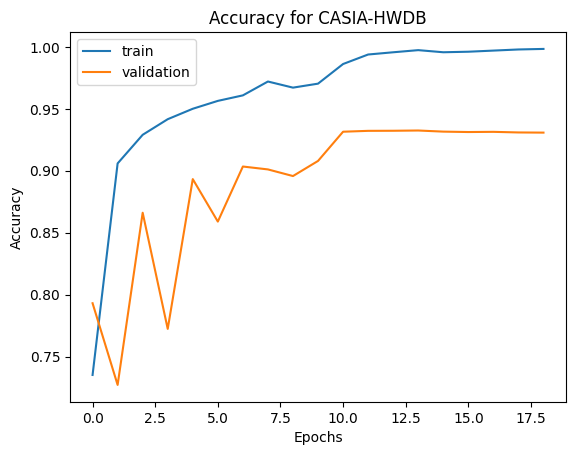

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for CASIA-HWDB", "Accuracy")

Text(0.5, 1.0, 'Loss for CASIA-HWDB')

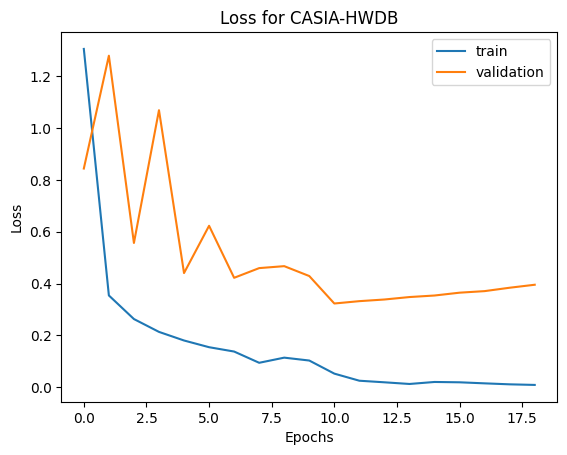

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for CASIA-HWDB", "Loss")

In [23]:
# Testing model

testing_model(class_amount=6764, model_suff_path="/kaggle/working/model_CASIA_HWDB_stuff")

/tmp/ipykernel_30/2314565953.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))  0%|          | 0/176 [00:

Test: loss 0.3478907644748688 accuracy 0.9325065612792969

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b01725d9ab0>Traceback (most recent call last):  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__    self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers    if w.is_alive():  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive    assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b01725d9ab0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b01725d9ab0>Traceback (most recent call last):  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__    Traceback (most recent call last):  File "/opt/conda/lib/python3.10/site-packages/torch/utils

乾 1.0 144.0亵 1.0 58.0仫 1.0 60.0佧 1.0 60.0俎 1.0 59.0俜 1.0 60.0俪 1.0 60.0倏 1.0 60.0傣 1.0 142.0傧 1.0 59.0儇 1.0 58.0兕 1.0 59.0凹 1.0 142.0凿 1.0 145.0剽 1.0 60.0劁 1.0 60.0劐 1.0 60.0劓 1.0 60.0勰 1.0 60.0匏 1.0 60.0卺 1.0 58.0厝 1.0 60.0厣 1.0 59.0咧 1.0 83.0咫 1.0 59.0哿 1.0 59.0唣 1.0 59.0唳 1.0 60.0啊 1.0 142.0啕 1.0 60.0喃 1.0 60.0嗫 1.0 60.0嗲 1.0 60.0嘤 1.0 60.0嘭 1.0 59.0嘶 1.0 143.0噔 1.0 60.0噗 1.0 60.0噤 1.0 60.0噱 1.0 60.0圳 1.0 60.0坩 1.0 59.0垴 1.0 60.0堙 1.0 59.0墁 1.0 59.0夔 1.0 59.0奘 1.0 59.0妤 1.0 59.0妯 1.0 60.0姹 1.0 60.0娉 1.0 60.0婀 1.0 60.0媲 1.0 60.0媾 1.0 60.0嫔 1.0 59.0嫦 1.0 59.0嬗 1.0 59.0嬷 1.0 58.0孀 1.0 59.0孬 1.0 58.0孱 1.0 60.0寰 1.0 60.0屐 1.0 60.0峤 1.0 60.0崂 1.0 60.0崛 1.0 59.0嵇 1.0 60.0嵊 1.0 60.0嵬 1.0 60.0嶙 1.0 60.0嶷 1.0 59.0帼 1.0 60.0幄 1.0 60.0幞 1.0 60.0幡 1.0 60.0庑 1.0 60.0廑 1.0 60.0廨 1.0 60.0弑 1.0 60.0彀 1.0 60.0彘 1.0 59.0徕 1.0 60.0恐 1.0 143.0恸 1.0 60.0恹 1.0 60.0悒 1.0 59.0悖 1.0 60.0悱 1.0 60.0惬 1.0 60.0愆 1.0 60.0愍 1.0 60.0懿 1.0 59.0戟 1.0 60.0戡 1.0 60.0戤 1.0 60.0戬 1.0 60.0揆 1.0 60.0揸 1.0 60.0搋 1.0 60.0搠 1

In [7]:
import gc
empty, testloader, original_dataset = get_dataloaders_CASIA_HWDB(batch_size=4096)
empty = None
casia_hwdb = {"testloader": testloader, "original_dataset": original_dataset}
gc.collect()

0

In [8]:
testing_models_metrics(class_amount=6764, model_suff_path="/kaggle/input/casia-hwdb/model_CASIA_HWDB_stuff/model_CASIA_HWDB_stuff", casia_hwdb=casia_hwdb)

/tmp/ipykernel_23/2245620070.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
/tmp/ipykernel_23/22456200

Per-class accuracy:
乾: 1.00000 
亵: 1.00000 
仫: 1.00000 
佧: 1.00000 
俎: 1.00000 
俜: 1.00000 
俪: 1.00000 
倏: 1.00000 
傣: 1.00000 
傧: 1.00000 
儇: 1.00000 
兕: 1.00000 
凹: 1.00000 
凿: 1.00000 
剽: 1.00000 
劁: 1.00000 
劐: 1.00000 
劓: 1.00000 
勰: 1.00000 
匏: 1.00000 
卺: 1.00000 
厝: 1.00000 
厣: 1.00000 
咧: 1.00000 
咫: 1.00000 
哿: 1.00000 
唣: 1.00000 
唳: 1.00000 
啊: 1.00000 
啕: 1.00000 
喃: 1.00000 
嗫: 1.00000 
嗲: 1.00000 
嘤: 1.00000 
嘭: 1.00000 
嘶: 1.00000 
噔: 1.00000 
噗: 1.00000 
噤: 1.00000 
噱: 1.00000 
圳: 1.00000 
坩: 1.00000 
垴: 1.00000 
堙: 1.00000 
墁: 1.00000 
夔: 1.00000 
奘: 1.00000 
妤: 1.00000 
妯: 1.00000 
姹: 1.00000 
娉: 1.00000 
婀: 1.00000 
媲: 1.00000 
媾: 1.00000 
嫔: 1.00000 
嫦: 1.00000 
嬗: 1.00000 
嬷: 1.00000 
孀: 1.00000 
孬: 1.00000 
孱: 1.00000 
寰: 1.00000 
屐: 1.00000 
峤: 1.00000 
崂: 1.00000 
崛: 1.00000 
嵇: 1.00000 
嵊: 1.00000 
嵬: 1.00000 
嶙: 1.00000 
嶷: 1.00000 
帼: 1.00000 
幄: 1.00000 
幞: 1.00000 
幡: 1.00000 
庑: 1.00000 
廑: 1.00000 
廨: 1.00000 
弑: 1.00000 
彀: 1.00000 
彘: 1.00000 
徕: 1.000